In [227]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [228]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [229]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [230]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [231]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [232]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [233]:
pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [234]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[min(100, (x.yard_line + x.yards_gained))].ep - ep_data.iloc[x.yard_line].ep, axis=1)

In [235]:
pbp_data.head()

,index,id,offense,defense,home,away,offense_score,defense_score,drive_id,period,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
1,1,322430009007,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Northern Arizona,Arizona State,Northern Arizona,6,0,32243000901,1,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Northern Arizona,Arizona State,Northern Arizona,0,0,32243000901,1,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [236]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [237]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'HavocRate': [havoc]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)
    #return translate(team_stat_pack.IsoPPPDiff, pbp_data.EqPPP.min(), pbp_data.EqPPP.max(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 4.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 5.5)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,5) + translate(team_stat_pack.OppSRDiff, -1,1,0,5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.05 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[min(100, (x.yard_line + x.yards_gained))].ep - ep_data.iloc[x.yard_line].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,-0.052381,0.118588,0.994779,-0.66,0.103211,2.077885,0.124959,-0.040309,4.740123,-0.019753
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,0.052381,-0.118588,-0.994779,0.66,-0.103211,-2.077885,-0.124959,0.040309,4.759877,0.019753


In [238]:
# %%timeit
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/6644] Getting game information for ESPN game_id: 322432309
[1/6644] Started processing game information for ESPN game_id: 322432309
[1/6644] Skipping checking game_id 322432309 bc one of the teams isn't FBS
[2/6644] Getting game information for ESPN game_id: 322432006
[2/6644] Started processing game information for ESPN game_id: 322432006
[2/6644] Completed processing game information for ESPN game_id: 322432006
[2/6644] Aggreggating game_id 322432006 to master data copy
[3/6644] Getting game information for ESPN game_id: 322430238
[3/6644] Started processing game information for ESPN game_id: 322430238
[3/6644] Completed processing game information for ESPN game_id: 322430238
[3/6644] Aggreggating game_id 322430238 to master data copy
[4/6644] Getting game information for ESPN game_id: 322432117
[4/6644] Started processing game information for ESPN game_id: 322432117
[4/6644] Skipping checking game_id 322432117 bc one of the teams isn't FBS
[5/6644] Getting game information for ES

[36/6644] Completed processing game information for ESPN game_id: 322450103
[36/6644] Aggreggating game_id 322450103 to master data copy
[37/6644] Getting game information for ESPN game_id: 322450275
[37/6644] Started processing game information for ESPN game_id: 322450275
[37/6644] Skipping checking game_id 322450275 bc one of the teams isn't FBS
[38/6644] Getting game information for ESPN game_id: 322452509
[38/6644] Started processing game information for ESPN game_id: 322452509
[38/6644] Skipping checking game_id 322452509 bc one of the teams isn't FBS
[39/6644] Getting game information for ESPN game_id: 322450158
[39/6644] Started processing game information for ESPN game_id: 322450158
[39/6644] Completed processing game information for ESPN game_id: 322450158
[39/6644] Aggreggating game_id 322450158 to master data copy
[40/6644] Getting game information for ESPN game_id: 322450066
[40/6644] Started processing game information for ESPN game_id: 322450066
[40/6644] Completed proces

[70/6644] Completed processing game information for ESPN game_id: 322452483
[70/6644] Aggreggating game_id 322452483 to master data copy
[71/6644] Getting game information for ESPN game_id: 322452638
[71/6644] Started processing game information for ESPN game_id: 322452638
[71/6644] Completed processing game information for ESPN game_id: 322452638
[71/6644] Aggreggating game_id 322452638 to master data copy
[72/6644] Getting game information for ESPN game_id: 322450264
[72/6644] Started processing game information for ESPN game_id: 322450264
[72/6644] Completed processing game information for ESPN game_id: 322450264
[72/6644] Aggreggating game_id 322450264 to master data copy
[73/6644] Getting game information for ESPN game_id: 322450012
[73/6644] Started processing game information for ESPN game_id: 322450012
[73/6644] Completed processing game information for ESPN game_id: 322450012
[73/6644] Aggreggating game_id 322450012 to master data copy
[74/6644] Getting game information for ES

[104/6644] Completed processing game information for ESPN game_id: 322522117
[104/6644] Aggreggating game_id 322522117 to master data copy
[105/6644] Getting game information for ESPN game_id: 322520113
[105/6644] Started processing game information for ESPN game_id: 322520113
[105/6644] Completed processing game information for ESPN game_id: 322520113
[105/6644] Aggreggating game_id 322520113 to master data copy
[106/6644] Getting game information for ESPN game_id: 322520130
[106/6644] Started processing game information for ESPN game_id: 322520130
[106/6644] Completed processing game information for ESPN game_id: 322520130
[106/6644] Aggreggating game_id 322520130 to master data copy
[107/6644] Getting game information for ESPN game_id: 322522305
[107/6644] Started processing game information for ESPN game_id: 322522305
[107/6644] Completed processing game information for ESPN game_id: 322522305
[107/6644] Aggreggating game_id 322522305 to master data copy
[108/6644] Getting game inf

[137/6644] Completed processing game information for ESPN game_id: 322520096
[137/6644] Aggreggating game_id 322520096 to master data copy
[138/6644] Getting game information for ESPN game_id: 322520142
[138/6644] Started processing game information for ESPN game_id: 322520142
[138/6644] Completed processing game information for ESPN game_id: 322520142
[138/6644] Aggreggating game_id 322520142 to master data copy
[139/6644] Getting game information for ESPN game_id: 322520026
[139/6644] Started processing game information for ESPN game_id: 322520026
[139/6644] Completed processing game information for ESPN game_id: 322520026
[139/6644] Aggreggating game_id 322520026 to master data copy
[140/6644] Getting game information for ESPN game_id: 322520251
[140/6644] Started processing game information for ESPN game_id: 322520251
[140/6644] Completed processing game information for ESPN game_id: 322520251
[140/6644] Aggreggating game_id 322520251 to master data copy
[141/6644] Getting game inf

[169/6644] Completed processing game information for ESPN game_id: 322590213
[169/6644] Aggreggating game_id 322590213 to master data copy
[170/6644] Getting game information for ESPN game_id: 322592006
[170/6644] Started processing game information for ESPN game_id: 322592006
[170/6644] Skipping checking game_id 322592006 bc one of the teams isn't FBS
[171/6644] Getting game information for ESPN game_id: 322590097
[171/6644] Started processing game information for ESPN game_id: 322590097
[171/6644] Completed processing game information for ESPN game_id: 322590097
[171/6644] Aggreggating game_id 322590097 to master data copy
[172/6644] Getting game information for ESPN game_id: 322592572
[172/6644] Started processing game information for ESPN game_id: 322592572
Could not find drive data for game_id 322592572 locally, checking CFB Data API
Could not find drive data for game_id 322592572 on CFB Data API, bailing out
[172/6644] Got 'None' for game_id 322592572's box score, skipping proces

[201/6644] Completed processing game information for ESPN game_id: 322590024
[201/6644] Aggreggating game_id 322590024 to master data copy
[202/6644] Getting game information for ESPN game_id: 322590061
[202/6644] Started processing game information for ESPN game_id: 322590061
[202/6644] Completed processing game information for ESPN game_id: 322590061
[202/6644] Aggreggating game_id 322590061 to master data copy
[203/6644] Getting game information for ESPN game_id: 322590099
[203/6644] Started processing game information for ESPN game_id: 322590099
[203/6644] Skipping checking game_id 322590099 bc one of the teams isn't FBS
[204/6644] Getting game information for ESPN game_id: 322590127
[204/6644] Started processing game information for ESPN game_id: 322590127
[204/6644] Completed processing game information for ESPN game_id: 322590127
[204/6644] Aggreggating game_id 322590127 to master data copy
[205/6644] Getting game information for ESPN game_id: 322590021
[205/6644] Started proces

[232/6644] Completed processing game information for ESPN game_id: 322662711
[232/6644] Aggreggating game_id 322662711 to master data copy
[233/6644] Getting game information for ESPN game_id: 322660059
[233/6644] Started processing game information for ESPN game_id: 322660059
[233/6644] Completed processing game information for ESPN game_id: 322660059
[233/6644] Aggreggating game_id 322660059 to master data copy
[234/6644] Getting game information for ESPN game_id: 322660213
[234/6644] Started processing game information for ESPN game_id: 322660213
[234/6644] Completed processing game information for ESPN game_id: 322660213
[234/6644] Aggreggating game_id 322660213 to master data copy
[235/6644] Getting game information for ESPN game_id: 322662579
[235/6644] Started processing game information for ESPN game_id: 322662579
[235/6644] Completed processing game information for ESPN game_id: 322662579
[235/6644] Aggreggating game_id 322662579 to master data copy
[236/6644] Getting game inf

[265/6644] Completed processing game information for ESPN game_id: 322660061
[265/6644] Aggreggating game_id 322660061 to master data copy
[266/6644] Getting game information for ESPN game_id: 322660201
[266/6644] Started processing game information for ESPN game_id: 322660201
[266/6644] Completed processing game information for ESPN game_id: 322660201
[266/6644] Aggreggating game_id 322660201 to master data copy
[267/6644] Getting game information for ESPN game_id: 322660356
[267/6644] Started processing game information for ESPN game_id: 322660356
[267/6644] Completed processing game information for ESPN game_id: 322660356
[267/6644] Aggreggating game_id 322660356 to master data copy
[268/6644] Getting game information for ESPN game_id: 322660052
[268/6644] Started processing game information for ESPN game_id: 322660052
[268/6644] Completed processing game information for ESPN game_id: 322660052
[268/6644] Aggreggating game_id 322660052 to master data copy
[269/6644] Getting game inf

[296/6644] Completed processing game information for ESPN game_id: 322732132
[296/6644] Aggreggating game_id 322732132 to master data copy
[297/6644] Getting game information for ESPN game_id: 322730127
[297/6644] Started processing game information for ESPN game_id: 322730127
[297/6644] Completed processing game information for ESPN game_id: 322730127
[297/6644] Aggreggating game_id 322730127 to master data copy
[298/6644] Getting game information for ESPN game_id: 322730103
[298/6644] Started processing game information for ESPN game_id: 322730103
[298/6644] Completed processing game information for ESPN game_id: 322730103
[298/6644] Aggreggating game_id 322730103 to master data copy
[299/6644] Getting game information for ESPN game_id: 322730189
[299/6644] Started processing game information for ESPN game_id: 322730189
[299/6644] Skipping checking game_id 322730189 bc one of the teams isn't FBS
[300/6644] Getting game information for ESPN game_id: 322730258
[300/6644] Started proces

[326/6644] Completed processing game information for ESPN game_id: 322730166
[326/6644] Aggreggating game_id 322730166 to master data copy
[327/6644] Getting game information for ESPN game_id: 322730333
[327/6644] Started processing game information for ESPN game_id: 322730333
[327/6644] Completed processing game information for ESPN game_id: 322730333
[327/6644] Aggreggating game_id 322730333 to master data copy
[328/6644] Getting game information for ESPN game_id: 322730012
[328/6644] Started processing game information for ESPN game_id: 322730012
[328/6644] Completed processing game information for ESPN game_id: 322730012
[328/6644] Aggreggating game_id 322730012 to master data copy
[329/6644] Getting game information for ESPN game_id: 322730278
[329/6644] Started processing game information for ESPN game_id: 322730278
[329/6644] Completed processing game information for ESPN game_id: 322730278
[329/6644] Aggreggating game_id 322730278 to master data copy
[330/6644] Getting game inf

[357/6644] Completed processing game information for ESPN game_id: 322802393
[357/6644] Aggreggating game_id 322802393 to master data copy
[358/6644] Getting game information for ESPN game_id: 322800120
[358/6644] Started processing game information for ESPN game_id: 322800120
[358/6644] Completed processing game information for ESPN game_id: 322800120
[358/6644] Aggreggating game_id 322800120 to master data copy
[359/6644] Getting game information for ESPN game_id: 322800057
[359/6644] Started processing game information for ESPN game_id: 322800057
[359/6644] Completed processing game information for ESPN game_id: 322800057
[359/6644] Aggreggating game_id 322800057 to master data copy
[360/6644] Getting game information for ESPN game_id: 322800228
[360/6644] Started processing game information for ESPN game_id: 322800228
[360/6644] Completed processing game information for ESPN game_id: 322800228
[360/6644] Aggreggating game_id 322800228 to master data copy
[361/6644] Getting game inf

[388/6644] Completed processing game information for ESPN game_id: 322850038
[388/6644] Aggreggating game_id 322850038 to master data copy
[389/6644] Getting game information for ESPN game_id: 322862117
[389/6644] Started processing game information for ESPN game_id: 322862117
[389/6644] Completed processing game information for ESPN game_id: 322862117
[389/6644] Aggreggating game_id 322862117 to master data copy
[390/6644] Getting game information for ESPN game_id: 322870221
[390/6644] Started processing game information for ESPN game_id: 322870221
[390/6644] Completed processing game information for ESPN game_id: 322870221
[390/6644] Aggreggating game_id 322870221 to master data copy
[391/6644] Getting game information for ESPN game_id: 322870248
[391/6644] Started processing game information for ESPN game_id: 322870248
[391/6644] Completed processing game information for ESPN game_id: 322870248
[391/6644] Aggreggating game_id 322870248 to master data copy
[392/6644] Getting game inf

[418/6644] Completed processing game information for ESPN game_id: 322870252
[418/6644] Aggreggating game_id 322870252 to master data copy
[419/6644] Getting game information for ESPN game_id: 322870068
[419/6644] Started processing game information for ESPN game_id: 322870068
[419/6644] Completed processing game information for ESPN game_id: 322870068
[419/6644] Aggreggating game_id 322870068 to master data copy
[420/6644] Getting game information for ESPN game_id: 322870023
[420/6644] Started processing game information for ESPN game_id: 322870023
[420/6644] Completed processing game information for ESPN game_id: 322870023
[420/6644] Aggreggating game_id 322870023 to master data copy
[421/6644] Getting game information for ESPN game_id: 322870151
[421/6644] Started processing game information for ESPN game_id: 322870151
[421/6644] Completed processing game information for ESPN game_id: 322870151
[421/6644] Aggreggating game_id 322870151 to master data copy
[422/6644] Getting game inf

[448/6644] Completed processing game information for ESPN game_id: 322940275
[448/6644] Aggreggating game_id 322940275 to master data copy
[449/6644] Getting game information for ESPN game_id: 322940194
[449/6644] Started processing game information for ESPN game_id: 322940194
[449/6644] Completed processing game information for ESPN game_id: 322940194
[449/6644] Aggreggating game_id 322940194 to master data copy
[450/6644] Getting game information for ESPN game_id: 322940197
[450/6644] Started processing game information for ESPN game_id: 322940197
[450/6644] Completed processing game information for ESPN game_id: 322940197
[450/6644] Aggreggating game_id 322940197 to master data copy
[451/6644] Getting game information for ESPN game_id: 322940218
[451/6644] Started processing game information for ESPN game_id: 322940218
[451/6644] Completed processing game information for ESPN game_id: 322940218
[451/6644] Aggreggating game_id 322940218 to master data copy
[452/6644] Getting game inf

[478/6644] Completed processing game information for ESPN game_id: 322940277
[478/6644] Aggreggating game_id 322940277 to master data copy
[479/6644] Getting game information for ESPN game_id: 322942633
[479/6644] Started processing game information for ESPN game_id: 322942633
[479/6644] Completed processing game information for ESPN game_id: 322942633
[479/6644] Aggreggating game_id 322942633 to master data copy
[480/6644] Getting game information for ESPN game_id: 322942005
[480/6644] Started processing game information for ESPN game_id: 322942005
[480/6644] Completed processing game information for ESPN game_id: 322942005
[480/6644] Aggreggating game_id 322942005 to master data copy
[481/6644] Getting game information for ESPN game_id: 322942572
[481/6644] Started processing game information for ESPN game_id: 322942572
[481/6644] Completed processing game information for ESPN game_id: 322942572
[481/6644] Aggreggating game_id 322942572 to master data copy
[482/6644] Getting game inf

[509/6644] Completed processing game information for ESPN game_id: 323010008
[509/6644] Aggreggating game_id 323010008 to master data copy
[510/6644] Getting game information for ESPN game_id: 323010153
[510/6644] Started processing game information for ESPN game_id: 323010153
[510/6644] Completed processing game information for ESPN game_id: 323010153
[510/6644] Aggreggating game_id 323010153 to master data copy
[511/6644] Getting game information for ESPN game_id: 323010242
[511/6644] Started processing game information for ESPN game_id: 323010242
[511/6644] Completed processing game information for ESPN game_id: 323010242
[511/6644] Aggreggating game_id 323010242 to master data copy
[512/6644] Getting game information for ESPN game_id: 323010103
[512/6644] Started processing game information for ESPN game_id: 323010103
[512/6644] Completed processing game information for ESPN game_id: 323010103
[512/6644] Aggreggating game_id 323010103 to master data copy
[513/6644] Getting game inf

[539/6644] Completed processing game information for ESPN game_id: 323012229
[539/6644] Aggreggating game_id 323012229 to master data copy
[540/6644] Getting game information for ESPN game_id: 323010024
[540/6644] Started processing game information for ESPN game_id: 323010024
[540/6644] Completed processing game information for ESPN game_id: 323010024
[540/6644] Aggreggating game_id 323010024 to master data copy
[541/6644] Getting game information for ESPN game_id: 323010002
[541/6644] Started processing game information for ESPN game_id: 323010002
[541/6644] Completed processing game information for ESPN game_id: 323010002
[541/6644] Aggreggating game_id 323010002 to master data copy
[542/6644] Getting game information for ESPN game_id: 323010238
[542/6644] Started processing game information for ESPN game_id: 323010238
[542/6644] Completed processing game information for ESPN game_id: 323010238
[542/6644] Aggreggating game_id 323010238 to master data copy
[543/6644] Getting game inf

[569/6644] Completed processing game information for ESPN game_id: 323082084
[569/6644] Aggreggating game_id 323082084 to master data copy
[570/6644] Getting game information for ESPN game_id: 323080008
[570/6644] Started processing game information for ESPN game_id: 323080008
[570/6644] Completed processing game information for ESPN game_id: 323080008
[570/6644] Aggreggating game_id 323080008 to master data copy
[571/6644] Getting game information for ESPN game_id: 323080120
[571/6644] Started processing game information for ESPN game_id: 323080120
[571/6644] Completed processing game information for ESPN game_id: 323080120
[571/6644] Aggreggating game_id 323080120 to master data copy
[572/6644] Getting game information for ESPN game_id: 323080152
[572/6644] Started processing game information for ESPN game_id: 323080152
[572/6644] Completed processing game information for ESPN game_id: 323080152
[572/6644] Aggreggating game_id 323080152 to master data copy
[573/6644] Getting game inf

[600/6644] Completed processing game information for ESPN game_id: 323080058
[600/6644] Aggreggating game_id 323080058 to master data copy
[601/6644] Getting game information for ESPN game_id: 323082116
[601/6644] Started processing game information for ESPN game_id: 323082116
[601/6644] Completed processing game information for ESPN game_id: 323082116
[601/6644] Aggreggating game_id 323082116 to master data copy
[602/6644] Getting game information for ESPN game_id: 323080278
[602/6644] Started processing game information for ESPN game_id: 323080278
[602/6644] Completed processing game information for ESPN game_id: 323080278
[602/6644] Aggreggating game_id 323080278 to master data copy
[603/6644] Getting game information for ESPN game_id: 323080150
[603/6644] Started processing game information for ESPN game_id: 323080150
[603/6644] Completed processing game information for ESPN game_id: 323080150
[603/6644] Aggreggating game_id 323080150 to master data copy
[604/6644] Getting game inf

[630/6644] Completed processing game information for ESPN game_id: 323150193
[630/6644] Aggreggating game_id 323150193 to master data copy
[631/6644] Getting game information for ESPN game_id: 323150098
[631/6644] Started processing game information for ESPN game_id: 323150098
[631/6644] Completed processing game information for ESPN game_id: 323150098
[631/6644] Aggreggating game_id 323150098 to master data copy
[632/6644] Getting game information for ESPN game_id: 323150012
[632/6644] Started processing game information for ESPN game_id: 323150012
[632/6644] Completed processing game information for ESPN game_id: 323150012
[632/6644] Aggreggating game_id 323150012 to master data copy
[633/6644] Getting game information for ESPN game_id: 323152006
[633/6644] Started processing game information for ESPN game_id: 323152006
Could not find drive data for game_id 323152006 locally, checking CFB Data API
Could not find drive data for game_id 323152006 on CFB Data API, bailing out
[633/6644]

[660/6644] Completed processing game information for ESPN game_id: 323150326
[660/6644] Aggreggating game_id 323150326 to master data copy
[661/6644] Getting game information for ESPN game_id: 323150099
[661/6644] Started processing game information for ESPN game_id: 323150099
[661/6644] Completed processing game information for ESPN game_id: 323150099
[661/6644] Aggreggating game_id 323150099 to master data copy
[662/6644] Getting game information for ESPN game_id: 323150103
[662/6644] Started processing game information for ESPN game_id: 323150103
[662/6644] Completed processing game information for ESPN game_id: 323150103
[662/6644] Aggreggating game_id 323150103 to master data copy
[663/6644] Getting game information for ESPN game_id: 323150252
[663/6644] Started processing game information for ESPN game_id: 323150252
[663/6644] Skipping checking game_id 323150252 bc one of the teams isn't FBS
[664/6644] Getting game information for ESPN game_id: 323150264
[664/6644] Started proces

[691/6644] Completed processing game information for ESPN game_id: 323222711
[691/6644] Aggreggating game_id 323222711 to master data copy
[692/6644] Getting game information for ESPN game_id: 323220002
[692/6644] Started processing game information for ESPN game_id: 323220002
[692/6644] Skipping checking game_id 323220002 bc one of the teams isn't FBS
[693/6644] Getting game information for ESPN game_id: 323220005
[693/6644] Started processing game information for ESPN game_id: 323220005
[693/6644] Completed processing game information for ESPN game_id: 323220005
[693/6644] Aggreggating game_id 323220005 to master data copy
[694/6644] Getting game information for ESPN game_id: 323220009
[694/6644] Started processing game information for ESPN game_id: 323220009
[694/6644] Completed processing game information for ESPN game_id: 323220009
[694/6644] Aggreggating game_id 323220009 to master data copy
[695/6644] Getting game information for ESPN game_id: 323222390
[695/6644] Started proces

[722/6644] Completed processing game information for ESPN game_id: 323220277
[722/6644] Aggreggating game_id 323220277 to master data copy
[723/6644] Getting game information for ESPN game_id: 323220096
[723/6644] Started processing game information for ESPN game_id: 323220096
[723/6644] Skipping checking game_id 323220096 bc one of the teams isn't FBS
[724/6644] Getting game information for ESPN game_id: 323222572
[724/6644] Started processing game information for ESPN game_id: 323222572
[724/6644] Completed processing game information for ESPN game_id: 323222572
[724/6644] Aggreggating game_id 323222572 to master data copy
[725/6644] Getting game information for ESPN game_id: 323220239
[725/6644] Started processing game information for ESPN game_id: 323220239
[725/6644] Completed processing game information for ESPN game_id: 323220239
[725/6644] Aggreggating game_id 323220239 to master data copy
[726/6644] Getting game information for ESPN game_id: 323222483
[726/6644] Started proces

[753/6644] Completed processing game information for ESPN game_id: 323290259
[753/6644] Aggreggating game_id 323290259 to master data copy
[754/6644] Getting game information for ESPN game_id: 323290077
[754/6644] Started processing game information for ESPN game_id: 323290077
[754/6644] Completed processing game information for ESPN game_id: 323290077
[754/6644] Aggreggating game_id 323290077 to master data copy
[755/6644] Getting game information for ESPN game_id: 323292633
[755/6644] Started processing game information for ESPN game_id: 323292633
[755/6644] Completed processing game information for ESPN game_id: 323292633
[755/6644] Aggreggating game_id 323292633 to master data copy
[756/6644] Getting game information for ESPN game_id: 323290150
[756/6644] Started processing game information for ESPN game_id: 323290150
[756/6644] Completed processing game information for ESPN game_id: 323290150
[756/6644] Aggreggating game_id 323290150 to master data copy
[757/6644] Getting game inf

[784/6644] Completed processing game information for ESPN game_id: 323290030
[784/6644] Aggreggating game_id 323290030 to master data copy
[785/6644] Getting game information for ESPN game_id: 323290023
[785/6644] Started processing game information for ESPN game_id: 323290023
[785/6644] Completed processing game information for ESPN game_id: 323290023
[785/6644] Aggreggating game_id 323290023 to master data copy
[786/6644] Getting game information for ESPN game_id: 323290062
[786/6644] Started processing game information for ESPN game_id: 323290062
[786/6644] Completed processing game information for ESPN game_id: 323290062
[786/6644] Aggreggating game_id 323290062 to master data copy
[787/6644] Getting game information for ESPN game_id: 323340164
[787/6644] Started processing game information for ESPN game_id: 323340164
[787/6644] Completed processing game information for ESPN game_id: 323340164
[787/6644] Aggreggating game_id 323340164 to master data copy
[788/6644] Getting game inf

[820/6644] Completed processing game information for ESPN game_id: 332410238
[820/6644] Aggreggating game_id 332410238 to master data copy
[821/6644] Getting game information for ESPN game_id: 332410023
[821/6644] Started processing game information for ESPN game_id: 332410023
[821/6644] Skipping checking game_id 332410023 bc one of the teams isn't FBS
[822/6644] Getting game information for ESPN game_id: 332410278
[822/6644] Started processing game information for ESPN game_id: 332410278
[822/6644] Completed processing game information for ESPN game_id: 332410278
[822/6644] Aggreggating game_id 332410278 to master data copy
[823/6644] Getting game information for ESPN game_id: 332410062
[823/6644] Started processing game information for ESPN game_id: 332410062
[823/6644] Completed processing game information for ESPN game_id: 332410062
[823/6644] Aggreggating game_id 332410062 to master data copy
[824/6644] Getting game information for ESPN game_id: 332420349
[824/6644] Started proces

[853/6644] Completed processing game information for ESPN game_id: 332430259
[853/6644] Aggreggating game_id 332430259 to master data copy
[854/6644] Getting game information for ESPN game_id: 332432199
[854/6644] Started processing game information for ESPN game_id: 332432199
[854/6644] Skipping checking game_id 332432199 bc one of the teams isn't FBS
[855/6644] Getting game information for ESPN game_id: 332430204
[855/6644] Started processing game information for ESPN game_id: 332430204
[855/6644] Skipping checking game_id 332430204 bc one of the teams isn't FBS
[856/6644] Getting game information for ESPN game_id: 332432633
[856/6644] Started processing game information for ESPN game_id: 332432633
[856/6644] Skipping checking game_id 332432633 bc one of the teams isn't FBS
[857/6644] Getting game information for ESPN game_id: 332430201
[857/6644] Started processing game information for ESPN game_id: 332430201
[857/6644] Completed processing game information for ESPN game_id: 3324302

[887/6644] Completed processing game information for ESPN game_id: 332502309
[887/6644] Aggreggating game_id 332502309 to master data copy
[888/6644] Getting game information for ESPN game_id: 332502509
[888/6644] Started processing game information for ESPN game_id: 332502509
[888/6644] Skipping checking game_id 332502509 bc one of the teams isn't FBS
[889/6644] Getting game information for ESPN game_id: 332502390
[889/6644] Started processing game information for ESPN game_id: 332502390
[889/6644] Completed processing game information for ESPN game_id: 332502390
[889/6644] Aggreggating game_id 332502390 to master data copy
[890/6644] Getting game information for ESPN game_id: 332502636
[890/6644] Started processing game information for ESPN game_id: 332502636
[890/6644] Completed processing game information for ESPN game_id: 332502636
[890/6644] Aggreggating game_id 332502636 to master data copy
[891/6644] Getting game information for ESPN game_id: 332500275
[891/6644] Started proces

[923/6644] Completed processing game information for ESPN game_id: 332500084
[923/6644] Aggreggating game_id 332500084 to master data copy
[924/6644] Getting game information for ESPN game_id: 332500158
[924/6644] Started processing game information for ESPN game_id: 332500158
[924/6644] Completed processing game information for ESPN game_id: 332500158
[924/6644] Aggreggating game_id 332500158 to master data copy
[925/6644] Getting game information for ESPN game_id: 332500077
[925/6644] Started processing game information for ESPN game_id: 332500077
[925/6644] Completed processing game information for ESPN game_id: 332500077
[925/6644] Aggreggating game_id 332500077 to master data copy
[926/6644] Getting game information for ESPN game_id: 332502006
[926/6644] Started processing game information for ESPN game_id: 332502006
[926/6644] Skipping checking game_id 332502006 bc one of the teams isn't FBS
[927/6644] Getting game information for ESPN game_id: 332502306
[927/6644] Started proces

[958/6644] Completed processing game information for ESPN game_id: 332552348
[958/6644] Aggreggating game_id 332552348 to master data copy
[959/6644] Getting game information for ESPN game_id: 332552641
[959/6644] Started processing game information for ESPN game_id: 332552641
[959/6644] Completed processing game information for ESPN game_id: 332552641
[959/6644] Aggreggating game_id 332552641 to master data copy
[960/6644] Getting game information for ESPN game_id: 332560068
[960/6644] Started processing game information for ESPN game_id: 332560068
[960/6644] Completed processing game information for ESPN game_id: 332560068
[960/6644] Aggreggating game_id 332560068 to master data copy
[961/6644] Getting game information for ESPN game_id: 332570349
[961/6644] Started processing game information for ESPN game_id: 332570349
[961/6644] Completed processing game information for ESPN game_id: 332570349
[961/6644] Aggreggating game_id 332570349 to master data copy
[962/6644] Getting game inf

[990/6644] Completed processing game information for ESPN game_id: 332570066
[990/6644] Aggreggating game_id 332570066 to master data copy
[991/6644] Getting game information for ESPN game_id: 332570356
[991/6644] Started processing game information for ESPN game_id: 332570356
[991/6644] Completed processing game information for ESPN game_id: 332570356
[991/6644] Aggreggating game_id 332570356 to master data copy
[992/6644] Getting game information for ESPN game_id: 332572229
[992/6644] Started processing game information for ESPN game_id: 332572229
[992/6644] Skipping checking game_id 332572229 bc one of the teams isn't FBS
[993/6644] Getting game information for ESPN game_id: 332570265
[993/6644] Started processing game information for ESPN game_id: 332570265
[993/6644] Skipping checking game_id 332570265 bc one of the teams isn't FBS
[994/6644] Getting game information for ESPN game_id: 332570099
[994/6644] Started processing game information for ESPN game_id: 332570099
[994/6644] C

[1021/6644] Completed processing game information for ESPN game_id: 332642226
[1021/6644] Aggreggating game_id 332642226 to master data copy
[1022/6644] Getting game information for ESPN game_id: 332642294
[1022/6644] Started processing game information for ESPN game_id: 332642294
[1022/6644] Completed processing game information for ESPN game_id: 332642294
[1022/6644] Aggreggating game_id 332642294 to master data copy
[1023/6644] Getting game information for ESPN game_id: 332642305
[1023/6644] Started processing game information for ESPN game_id: 332642305
[1023/6644] Completed processing game information for ESPN game_id: 332642305
[1023/6644] Aggreggating game_id 332642305 to master data copy
[1024/6644] Getting game information for ESPN game_id: 332640194
[1024/6644] Started processing game information for ESPN game_id: 332640194
[1024/6644] Skipping checking game_id 332640194 bc one of the teams isn't FBS
[1025/6644] Getting game information for ESPN game_id: 332640097
[1025/6644]

[1054/6644] Completed processing game information for ESPN game_id: 332642006
[1054/6644] Aggreggating game_id 332642006 to master data copy
[1055/6644] Getting game information for ESPN game_id: 332640052
[1055/6644] Started processing game information for ESPN game_id: 332640052
[1055/6644] Skipping checking game_id 332640052 bc one of the teams isn't FBS
[1056/6644] Getting game information for ESPN game_id: 332640295
[1056/6644] Started processing game information for ESPN game_id: 332640295
[1056/6644] Skipping checking game_id 332640295 bc one of the teams isn't FBS
[1057/6644] Getting game information for ESPN game_id: 332640024
[1057/6644] Started processing game information for ESPN game_id: 332640024
[1057/6644] Completed processing game information for ESPN game_id: 332640024
[1057/6644] Aggreggating game_id 332640024 to master data copy
[1058/6644] Getting game information for ESPN game_id: 332642390
[1058/6644] Started processing game information for ESPN game_id: 33264239

[1085/6644] Completed processing game information for ESPN game_id: 332712628
[1085/6644] Aggreggating game_id 332712628 to master data copy
[1086/6644] Getting game information for ESPN game_id: 332710356
[1086/6644] Started processing game information for ESPN game_id: 332710356
[1086/6644] Completed processing game information for ESPN game_id: 332710356
[1086/6644] Aggreggating game_id 332710356 to master data copy
[1087/6644] Getting game information for ESPN game_id: 332712633
[1087/6644] Started processing game information for ESPN game_id: 332712633
[1087/6644] Completed processing game information for ESPN game_id: 332712633
[1087/6644] Aggreggating game_id 332712633 to master data copy
[1088/6644] Getting game information for ESPN game_id: 332710153
[1088/6644] Started processing game information for ESPN game_id: 332710153
[1088/6644] Completed processing game information for ESPN game_id: 332710153
[1088/6644] Aggreggating game_id 332710153 to master data copy
[1089/6644] G

[1115/6644] Completed processing game information for ESPN game_id: 332710238
[1115/6644] Aggreggating game_id 332710238 to master data copy
[1116/6644] Getting game information for ESPN game_id: 332710142
[1116/6644] Started processing game information for ESPN game_id: 332710142
[1116/6644] Completed processing game information for ESPN game_id: 332710142
[1116/6644] Aggreggating game_id 332710142 to master data copy
[1117/6644] Getting game information for ESPN game_id: 332710166
[1117/6644] Started processing game information for ESPN game_id: 332710166
[1117/6644] Completed processing game information for ESPN game_id: 332710166
[1117/6644] Aggreggating game_id 332710166 to master data copy
[1118/6644] Getting game information for ESPN game_id: 332710167
[1118/6644] Started processing game information for ESPN game_id: 332710167
[1118/6644] Completed processing game information for ESPN game_id: 332710167
[1118/6644] Aggreggating game_id 332710167 to master data copy
[1119/6644] G

[1145/6644] Completed processing game information for ESPN game_id: 332780103
[1145/6644] Aggreggating game_id 332780103 to master data copy
[1146/6644] Getting game information for ESPN game_id: 332780276
[1146/6644] Started processing game information for ESPN game_id: 332780276
[1146/6644] Completed processing game information for ESPN game_id: 332780276
[1146/6644] Aggreggating game_id 332780276 to master data copy
[1147/6644] Getting game information for ESPN game_id: 332782006
[1147/6644] Started processing game information for ESPN game_id: 332782006
[1147/6644] Completed processing game information for ESPN game_id: 332782006
[1147/6644] Aggreggating game_id 332782006 to master data copy
[1148/6644] Getting game information for ESPN game_id: 332782649
[1148/6644] Started processing game information for ESPN game_id: 332782649
[1148/6644] Completed processing game information for ESPN game_id: 332782649
[1148/6644] Aggreggating game_id 332782649 to master data copy
[1149/6644] G

[1176/6644] Completed processing game information for ESPN game_id: 332782579
[1176/6644] Aggreggating game_id 332782579 to master data copy
[1177/6644] Getting game information for ESPN game_id: 332780087
[1177/6644] Started processing game information for ESPN game_id: 332780087
[1177/6644] Completed processing game information for ESPN game_id: 332780087
[1177/6644] Aggreggating game_id 332780087 to master data copy
[1178/6644] Getting game information for ESPN game_id: 332780239
[1178/6644] Started processing game information for ESPN game_id: 332780239
[1178/6644] Completed processing game information for ESPN game_id: 332780239
[1178/6644] Aggreggating game_id 332780239 to master data copy
[1179/6644] Getting game information for ESPN game_id: 332780077
[1179/6644] Started processing game information for ESPN game_id: 332780077
[1179/6644] Completed processing game information for ESPN game_id: 332780077
[1179/6644] Aggreggating game_id 332780077 to master data copy
[1180/6644] G

[1207/6644] Completed processing game information for ESPN game_id: 332850120
[1207/6644] Aggreggating game_id 332850120 to master data copy
[1208/6644] Getting game information for ESPN game_id: 332850152
[1208/6644] Started processing game information for ESPN game_id: 332850152
[1208/6644] Completed processing game information for ESPN game_id: 332850152
[1208/6644] Aggreggating game_id 332850152 to master data copy
[1209/6644] Getting game information for ESPN game_id: 332850036
[1209/6644] Started processing game information for ESPN game_id: 332850036
[1209/6644] Completed processing game information for ESPN game_id: 332850036
[1209/6644] Aggreggating game_id 332850036 to master data copy
[1210/6644] Getting game information for ESPN game_id: 332852247
[1210/6644] Started processing game information for ESPN game_id: 332852247
[1210/6644] Completed processing game information for ESPN game_id: 332852247
[1210/6644] Aggreggating game_id 332852247 to master data copy
[1211/6644] G

[1238/6644] Completed processing game information for ESPN game_id: 332922633
[1238/6644] Aggreggating game_id 332922633 to master data copy
[1239/6644] Getting game information for ESPN game_id: 332920238
[1239/6644] Started processing game information for ESPN game_id: 332920238
[1239/6644] Completed processing game information for ESPN game_id: 332920238
[1239/6644] Aggreggating game_id 332920238 to master data copy
[1240/6644] Getting game information for ESPN game_id: 332920277
[1240/6644] Started processing game information for ESPN game_id: 332920277
[1240/6644] Completed processing game information for ESPN game_id: 332920277
[1240/6644] Aggreggating game_id 332920277 to master data copy
[1241/6644] Getting game information for ESPN game_id: 332920197
[1241/6644] Started processing game information for ESPN game_id: 332920197
[1241/6644] Completed processing game information for ESPN game_id: 332920197
[1241/6644] Aggreggating game_id 332920197 to master data copy
[1242/6644] G

[1269/6644] Completed processing game information for ESPN game_id: 332920333
[1269/6644] Aggreggating game_id 332920333 to master data copy
[1270/6644] Getting game information for ESPN game_id: 332920326
[1270/6644] Started processing game information for ESPN game_id: 332920326
[1270/6644] Completed processing game information for ESPN game_id: 332920326
[1270/6644] Aggreggating game_id 332920326 to master data copy
[1271/6644] Getting game information for ESPN game_id: 332920145
[1271/6644] Started processing game information for ESPN game_id: 332920145
[1271/6644] Completed processing game information for ESPN game_id: 332920145
[1271/6644] Aggreggating game_id 332920145 to master data copy
[1272/6644] Getting game information for ESPN game_id: 332920087
[1272/6644] Started processing game information for ESPN game_id: 332920087
[1272/6644] Completed processing game information for ESPN game_id: 332920087
[1272/6644] Aggreggating game_id 332920087 to master data copy
[1273/6644] G

[1300/6644] Completed processing game information for ESPN game_id: 332990113
[1300/6644] Aggreggating game_id 332990113 to master data copy
[1301/6644] Getting game information for ESPN game_id: 332992567
[1301/6644] Started processing game information for ESPN game_id: 332992567
[1301/6644] Completed processing game information for ESPN game_id: 332992567
[1301/6644] Aggreggating game_id 332992567 to master data copy
[1302/6644] Getting game information for ESPN game_id: 332990259
[1302/6644] Started processing game information for ESPN game_id: 332990259
[1302/6644] Completed processing game information for ESPN game_id: 332990259
[1302/6644] Aggreggating game_id 332990259 to master data copy
[1303/6644] Getting game information for ESPN game_id: 332992459
[1303/6644] Started processing game information for ESPN game_id: 332992459
[1303/6644] Completed processing game information for ESPN game_id: 332992459
[1303/6644] Aggreggating game_id 332992459 to master data copy
[1304/6644] G

[1330/6644] Completed processing game information for ESPN game_id: 332990002
[1330/6644] Aggreggating game_id 332990002 to master data copy
[1331/6644] Getting game information for ESPN game_id: 332990194
[1331/6644] Started processing game information for ESPN game_id: 332990194
[1331/6644] Completed processing game information for ESPN game_id: 332990194
[1331/6644] Aggreggating game_id 332990194 to master data copy
[1332/6644] Getting game information for ESPN game_id: 332990166
[1332/6644] Started processing game information for ESPN game_id: 332990166
[1332/6644] Skipping checking game_id 332990166 bc one of the teams isn't FBS
[1333/6644] Getting game information for ESPN game_id: 332990038
[1333/6644] Started processing game information for ESPN game_id: 332990038
[1333/6644] Completed processing game information for ESPN game_id: 332990038
[1333/6644] Aggreggating game_id 332990038 to master data copy
[1334/6644] Getting game information for ESPN game_id: 332990021
[1334/6644]

[1360/6644] Completed processing game information for ESPN game_id: 333060127
[1360/6644] Aggreggating game_id 333060127 to master data copy
[1361/6644] Getting game information for ESPN game_id: 333060087
[1361/6644] Started processing game information for ESPN game_id: 333060087
[1361/6644] Completed processing game information for ESPN game_id: 333060087
[1361/6644] Aggreggating game_id 333060087 to master data copy
[1362/6644] Getting game information for ESPN game_id: 333060084
[1362/6644] Started processing game information for ESPN game_id: 333060084
[1362/6644] Completed processing game information for ESPN game_id: 333060084
[1362/6644] Aggreggating game_id 333060084 to master data copy
[1363/6644] Getting game information for ESPN game_id: 333060251
[1363/6644] Started processing game information for ESPN game_id: 333060251
[1363/6644] Completed processing game information for ESPN game_id: 333060251
[1363/6644] Aggreggating game_id 333060251 to master data copy
[1364/6644] G

[1390/6644] Completed processing game information for ESPN game_id: 333092084
[1390/6644] Aggreggating game_id 333092084 to master data copy
[1391/6644] Getting game information for ESPN game_id: 333102050
[1391/6644] Started processing game information for ESPN game_id: 333102050
[1391/6644] Completed processing game information for ESPN game_id: 333102050
[1391/6644] Aggreggating game_id 333102050 to master data copy
[1392/6644] Getting game information for ESPN game_id: 333110309
[1392/6644] Started processing game information for ESPN game_id: 333110309
[1392/6644] Completed processing game information for ESPN game_id: 333110309
[1392/6644] Aggreggating game_id 333110309 to master data copy
[1393/6644] Getting game information for ESPN game_id: 333110239
[1393/6644] Started processing game information for ESPN game_id: 333110239
[1393/6644] Completed processing game information for ESPN game_id: 333110239
[1393/6644] Aggreggating game_id 333110239 to master data copy
[1394/6644] G

[1420/6644] Completed processing game information for ESPN game_id: 333130084
[1420/6644] Aggreggating game_id 333130084 to master data copy
[1421/6644] Getting game information for ESPN game_id: 333130166
[1421/6644] Started processing game information for ESPN game_id: 333130166
[1421/6644] Completed processing game information for ESPN game_id: 333130166
[1421/6644] Aggreggating game_id 333130166 to master data copy
[1422/6644] Getting game information for ESPN game_id: 333132426
[1422/6644] Started processing game information for ESPN game_id: 333132426
[1422/6644] Completed processing game information for ESPN game_id: 333132426
[1422/6644] Aggreggating game_id 333132426 to master data copy
[1423/6644] Getting game information for ESPN game_id: 333130151
[1423/6644] Started processing game information for ESPN game_id: 333130151
[1423/6644] Completed processing game information for ESPN game_id: 333130151
[1423/6644] Aggreggating game_id 333130151 to master data copy
[1424/6644] G

[1450/6644] Completed processing game information for ESPN game_id: 333200356
[1450/6644] Aggreggating game_id 333200356 to master data copy
[1451/6644] Getting game information for ESPN game_id: 333200275
[1451/6644] Started processing game information for ESPN game_id: 333200275
[1451/6644] Completed processing game information for ESPN game_id: 333200275
[1451/6644] Aggreggating game_id 333200275 to master data copy
[1452/6644] Getting game information for ESPN game_id: 333202711
[1452/6644] Started processing game information for ESPN game_id: 333202711
[1452/6644] Completed processing game information for ESPN game_id: 333202711
[1452/6644] Aggreggating game_id 333202711 to master data copy
[1453/6644] Getting game information for ESPN game_id: 333202305
[1453/6644] Started processing game information for ESPN game_id: 333202305
[1453/6644] Completed processing game information for ESPN game_id: 333202305
[1453/6644] Aggreggating game_id 333202305 to master data copy
[1454/6644] G

[1480/6644] Completed processing game information for ESPN game_id: 333200058
[1480/6644] Aggreggating game_id 333200058 to master data copy
[1481/6644] Getting game information for ESPN game_id: 333200242
[1481/6644] Started processing game information for ESPN game_id: 333200242
[1481/6644] Completed processing game information for ESPN game_id: 333200242
[1481/6644] Aggreggating game_id 333200242 to master data copy
[1482/6644] Getting game information for ESPN game_id: 333200167
[1482/6644] Started processing game information for ESPN game_id: 333200167
[1482/6644] Completed processing game information for ESPN game_id: 333200167
[1482/6644] Aggreggating game_id 333200167 to master data copy
[1483/6644] Getting game information for ESPN game_id: 333202579
[1483/6644] Started processing game information for ESPN game_id: 333202579
[1483/6644] Completed processing game information for ESPN game_id: 333202579
[1483/6644] Aggreggating game_id 333202579 to master data copy
[1484/6644] G

[1511/6644] Completed processing game information for ESPN game_id: 333270008
[1511/6644] Aggreggating game_id 333270008 to master data copy
[1512/6644] Getting game information for ESPN game_id: 333270152
[1512/6644] Started processing game information for ESPN game_id: 333270152
[1512/6644] Completed processing game information for ESPN game_id: 333270152
[1512/6644] Aggreggating game_id 333270152 to master data copy
[1513/6644] Getting game information for ESPN game_id: 333270183
[1513/6644] Started processing game information for ESPN game_id: 333270183
[1513/6644] Completed processing game information for ESPN game_id: 333270183
[1513/6644] Aggreggating game_id 333270183 to master data copy
[1514/6644] Getting game information for ESPN game_id: 333272199
[1514/6644] Started processing game information for ESPN game_id: 333272199
[1514/6644] Completed processing game information for ESPN game_id: 333272199
[1514/6644] Aggreggating game_id 333272199 to master data copy
[1515/6644] G

[1542/6644] Completed processing game information for ESPN game_id: 333270061
[1542/6644] Aggreggating game_id 333270061 to master data copy
[1543/6644] Getting game information for ESPN game_id: 333270058
[1543/6644] Started processing game information for ESPN game_id: 333270058
[1543/6644] Completed processing game information for ESPN game_id: 333270058
[1543/6644] Aggreggating game_id 333270058 to master data copy
[1544/6644] Getting game information for ESPN game_id: 333272633
[1544/6644] Started processing game information for ESPN game_id: 333272633
[1544/6644] Completed processing game information for ESPN game_id: 333272633
[1544/6644] Aggreggating game_id 333272633 to master data copy
[1545/6644] Getting game information for ESPN game_id: 333272348
[1545/6644] Started processing game information for ESPN game_id: 333272348
[1545/6644] Completed processing game information for ESPN game_id: 333272348
[1545/6644] Aggreggating game_id 333272348 to master data copy
[1546/6644] G

[1572/6644] Completed processing game information for ESPN game_id: 333340041
[1572/6644] Aggreggating game_id 333340041 to master data copy
[1573/6644] Getting game information for ESPN game_id: 333340127
[1573/6644] Started processing game information for ESPN game_id: 333340127
[1573/6644] Completed processing game information for ESPN game_id: 333340127
[1573/6644] Aggreggating game_id 333340127 to master data copy
[1574/6644] Getting game information for ESPN game_id: 333340130
[1574/6644] Started processing game information for ESPN game_id: 333340130
[1574/6644] Completed processing game information for ESPN game_id: 333340130
[1574/6644] Aggreggating game_id 333340130 to master data copy
[1575/6644] Getting game information for ESPN game_id: 333340057
[1575/6644] Started processing game information for ESPN game_id: 333340057
[1575/6644] Completed processing game information for ESPN game_id: 333340057
[1575/6644] Aggreggating game_id 333340057 to master data copy
[1576/6644] G

[1603/6644] Completed processing game information for ESPN game_id: 333340309
[1603/6644] Aggreggating game_id 333340309 to master data copy
[1604/6644] Getting game information for ESPN game_id: 333340024
[1604/6644] Started processing game information for ESPN game_id: 333340024
[1604/6644] Completed processing game information for ESPN game_id: 333340024
[1604/6644] Aggreggating game_id 333340024 to master data copy
[1605/6644] Getting game information for ESPN game_id: 333342579
[1605/6644] Started processing game information for ESPN game_id: 333342579
[1605/6644] Completed processing game information for ESPN game_id: 333342579
[1605/6644] Aggreggating game_id 333342579 to master data copy
[1606/6644] Getting game information for ESPN game_id: 333340142
[1606/6644] Started processing game information for ESPN game_id: 333340142
[1606/6644] Completed processing game information for ESPN game_id: 333340142
[1606/6644] Aggreggating game_id 333340142 to master data copy
[1607/6644] G

[1636/6644] Completed processing game information for ESPN game_id: 400548169
[1636/6644] Aggreggating game_id 400548169 to master data copy
[1637/6644] Getting game information for ESPN game_id: 400548404
[1637/6644] Started processing game information for ESPN game_id: 400548404
[1637/6644] Skipping checking game_id 400548404 bc one of the teams isn't FBS
[1638/6644] Getting game information for ESPN game_id: 400547993
[1638/6644] Started processing game information for ESPN game_id: 400547993
[1638/6644] Completed processing game information for ESPN game_id: 400547993
[1638/6644] Aggreggating game_id 400547993 to master data copy
[1639/6644] Getting game information for ESPN game_id: 400553383
[1639/6644] Started processing game information for ESPN game_id: 400553383
[1639/6644] Skipping checking game_id 400553383 bc one of the teams isn't FBS
[1640/6644] Getting game information for ESPN game_id: 400548255
[1640/6644] Started processing game information for ESPN game_id: 40054825

[1670/6644] Completed processing game information for ESPN game_id: 400547975
[1670/6644] Aggreggating game_id 400547975 to master data copy
[1671/6644] Getting game information for ESPN game_id: 400548094
[1671/6644] Started processing game information for ESPN game_id: 400548094
[1671/6644] Skipping checking game_id 400548094 bc one of the teams isn't FBS
[1672/6644] Getting game information for ESPN game_id: 400548007
[1672/6644] Started processing game information for ESPN game_id: 400548007
[1672/6644] Skipping checking game_id 400548007 bc one of the teams isn't FBS
[1673/6644] Getting game information for ESPN game_id: 400548005
[1673/6644] Started processing game information for ESPN game_id: 400548005
[1673/6644] Completed processing game information for ESPN game_id: 400548005
[1673/6644] Aggreggating game_id 400548005 to master data copy
[1674/6644] Getting game information for ESPN game_id: 400547835
[1674/6644] Started processing game information for ESPN game_id: 40054783

[1704/6644] Completed processing game information for ESPN game_id: 400547836
[1704/6644] Aggreggating game_id 400547836 to master data copy
[1705/6644] Getting game information for ESPN game_id: 400548000
[1705/6644] Started processing game information for ESPN game_id: 400548000
[1705/6644] Completed processing game information for ESPN game_id: 400548000
[1705/6644] Aggreggating game_id 400548000 to master data copy
[1706/6644] Getting game information for ESPN game_id: 400548173
[1706/6644] Started processing game information for ESPN game_id: 400548173
Could not find drive data for game_id 400548173 locally, checking CFB Data API
Could not find drive data for game_id 400548173 bc of issues with 2016 and 2014 data source, bailing out
[1706/6644] Got 'None' for game_id 400548173's box score, skipping processing
[1707/6644] Getting game information for ESPN game_id: 400548257
[1707/6644] Started processing game information for ESPN game_id: 400548257
[1707/6644] Skipping checking gam

[1735/6644] Completed processing game information for ESPN game_id: 400548099
[1735/6644] Aggreggating game_id 400548099 to master data copy
[1736/6644] Getting game information for ESPN game_id: 400548261
[1736/6644] Started processing game information for ESPN game_id: 400548261
[1736/6644] Skipping checking game_id 400548261 bc one of the teams isn't FBS
[1737/6644] Getting game information for ESPN game_id: 400547654
[1737/6644] Started processing game information for ESPN game_id: 400547654
[1737/6644] Completed processing game information for ESPN game_id: 400547654
[1737/6644] Aggreggating game_id 400547654 to master data copy
[1738/6644] Getting game information for ESPN game_id: 400547976
[1738/6644] Started processing game information for ESPN game_id: 400547976
[1738/6644] Completed processing game information for ESPN game_id: 400547976
[1738/6644] Aggreggating game_id 400547976 to master data copy
[1739/6644] Getting game information for ESPN game_id: 400548260
[1739/6644]

[1769/6644] Completed processing game information for ESPN game_id: 400547944
[1769/6644] Aggreggating game_id 400547944 to master data copy
[1770/6644] Getting game information for ESPN game_id: 400548394
[1770/6644] Started processing game information for ESPN game_id: 400548394
[1770/6644] Skipping checking game_id 400548394 bc one of the teams isn't FBS
[1771/6644] Getting game information for ESPN game_id: 400547842
[1771/6644] Started processing game information for ESPN game_id: 400547842
[1771/6644] Skipping checking game_id 400547842 bc one of the teams isn't FBS
[1772/6644] Getting game information for ESPN game_id: 400548397
[1772/6644] Started processing game information for ESPN game_id: 400548397
[1772/6644] Skipping checking game_id 400548397 bc one of the teams isn't FBS
[1773/6644] Getting game information for ESPN game_id: 400547763
[1773/6644] Started processing game information for ESPN game_id: 400547763
[1773/6644] Skipping checking game_id 400547763 bc one of the

[1801/6644] Completed processing game information for ESPN game_id: 400548189
[1801/6644] Aggreggating game_id 400548189 to master data copy
[1802/6644] Getting game information for ESPN game_id: 400548193
[1802/6644] Started processing game information for ESPN game_id: 400548193
[1802/6644] Completed processing game information for ESPN game_id: 400548193
[1802/6644] Aggreggating game_id 400548193 to master data copy
[1803/6644] Getting game information for ESPN game_id: 400548107
[1803/6644] Started processing game information for ESPN game_id: 400548107
[1803/6644] Skipping checking game_id 400548107 bc one of the teams isn't FBS
[1804/6644] Getting game information for ESPN game_id: 400548190
[1804/6644] Started processing game information for ESPN game_id: 400548190
[1804/6644] Skipping checking game_id 400548190 bc one of the teams isn't FBS
[1805/6644] Getting game information for ESPN game_id: 400547852
[1805/6644] Started processing game information for ESPN game_id: 40054785

[1833/6644] Completed processing game information for ESPN game_id: 400547995
[1833/6644] Aggreggating game_id 400547995 to master data copy
[1834/6644] Getting game information for ESPN game_id: 400548026
[1834/6644] Started processing game information for ESPN game_id: 400548026
[1834/6644] Completed processing game information for ESPN game_id: 400548026
[1834/6644] Aggreggating game_id 400548026 to master data copy
[1835/6644] Getting game information for ESPN game_id: 400548412
[1835/6644] Started processing game information for ESPN game_id: 400548412
[1835/6644] Completed processing game information for ESPN game_id: 400548412
[1835/6644] Aggreggating game_id 400548412 to master data copy
[1836/6644] Getting game information for ESPN game_id: 400548264
[1836/6644] Started processing game information for ESPN game_id: 400548264
[1836/6644] Skipping checking game_id 400548264 bc one of the teams isn't FBS
[1837/6644] Getting game information for ESPN game_id: 400547848
[1837/6644]

[1865/6644] Completed processing game information for ESPN game_id: 400547857
[1865/6644] Aggreggating game_id 400547857 to master data copy
[1866/6644] Getting game information for ESPN game_id: 400547996
[1866/6644] Started processing game information for ESPN game_id: 400547996
[1866/6644] Completed processing game information for ESPN game_id: 400547996
[1866/6644] Aggreggating game_id 400547996 to master data copy
[1867/6644] Getting game information for ESPN game_id: 400547946
[1867/6644] Started processing game information for ESPN game_id: 400547946
[1867/6644] Completed processing game information for ESPN game_id: 400547946
[1867/6644] Aggreggating game_id 400547946 to master data copy
[1868/6644] Getting game information for ESPN game_id: 400547671
[1868/6644] Started processing game information for ESPN game_id: 400547671
[1868/6644] Completed processing game information for ESPN game_id: 400547671
[1868/6644] Aggreggating game_id 400547671 to master data copy
[1869/6644] G

[1897/6644] Completed processing game information for ESPN game_id: 400548194
[1897/6644] Aggreggating game_id 400548194 to master data copy
[1898/6644] Getting game information for ESPN game_id: 400548267
[1898/6644] Started processing game information for ESPN game_id: 400548267
[1898/6644] Completed processing game information for ESPN game_id: 400548267
[1898/6644] Aggreggating game_id 400548267 to master data copy
[1899/6644] Getting game information for ESPN game_id: 400548198
[1899/6644] Started processing game information for ESPN game_id: 400548198
[1899/6644] Completed processing game information for ESPN game_id: 400548198
[1899/6644] Aggreggating game_id 400548198 to master data copy
[1900/6644] Getting game information for ESPN game_id: 400547859
[1900/6644] Started processing game information for ESPN game_id: 400547859
[1900/6644] Completed processing game information for ESPN game_id: 400547859
[1900/6644] Aggreggating game_id 400547859 to master data copy
[1901/6644] G

[1927/6644] Completed processing game information for ESPN game_id: 400547833
[1927/6644] Aggreggating game_id 400547833 to master data copy
[1928/6644] Getting game information for ESPN game_id: 400548119
[1928/6644] Started processing game information for ESPN game_id: 400548119
[1928/6644] Completed processing game information for ESPN game_id: 400548119
[1928/6644] Aggreggating game_id 400548119 to master data copy
[1929/6644] Getting game information for ESPN game_id: 400548035
[1929/6644] Started processing game information for ESPN game_id: 400548035
[1929/6644] Completed processing game information for ESPN game_id: 400548035
[1929/6644] Aggreggating game_id 400548035 to master data copy
[1930/6644] Getting game information for ESPN game_id: 400547675
[1930/6644] Started processing game information for ESPN game_id: 400547675
[1930/6644] Completed processing game information for ESPN game_id: 400547675
[1930/6644] Aggreggating game_id 400547675 to master data copy
[1931/6644] G

[1958/6644] Completed processing game information for ESPN game_id: 400548207
[1958/6644] Aggreggating game_id 400548207 to master data copy
[1959/6644] Getting game information for ESPN game_id: 400548204
[1959/6644] Started processing game information for ESPN game_id: 400548204
[1959/6644] Completed processing game information for ESPN game_id: 400548204
[1959/6644] Aggreggating game_id 400548204 to master data copy
[1960/6644] Getting game information for ESPN game_id: 400548042
[1960/6644] Started processing game information for ESPN game_id: 400548042
[1960/6644] Completed processing game information for ESPN game_id: 400548042
[1960/6644] Aggreggating game_id 400548042 to master data copy
[1961/6644] Getting game information for ESPN game_id: 400548377
[1961/6644] Started processing game information for ESPN game_id: 400548377
[1961/6644] Completed processing game information for ESPN game_id: 400548377
[1961/6644] Aggreggating game_id 400548377 to master data copy
[1962/6644] G

[1988/6644] Completed processing game information for ESPN game_id: 400548123
[1988/6644] Aggreggating game_id 400548123 to master data copy
[1989/6644] Getting game information for ESPN game_id: 400548418
[1989/6644] Started processing game information for ESPN game_id: 400548418
[1989/6644] Completed processing game information for ESPN game_id: 400548418
[1989/6644] Aggreggating game_id 400548418 to master data copy
[1990/6644] Getting game information for ESPN game_id: 400548125
[1990/6644] Started processing game information for ESPN game_id: 400548125
Could not find drive data for game_id 400548125 locally, checking CFB Data API
Could not find drive data for game_id 400548125 bc of issues with 2016 and 2014 data source, bailing out
[1990/6644] Got 'None' for game_id 400548125's box score, skipping processing
[1991/6644] Getting game information for ESPN game_id: 400548419
[1991/6644] Started processing game information for ESPN game_id: 400548419
[1991/6644] Completed processing 

[2018/6644] Completed processing game information for ESPN game_id: 400547963
[2018/6644] Aggreggating game_id 400547963 to master data copy
[2019/6644] Getting game information for ESPN game_id: 400547921
[2019/6644] Started processing game information for ESPN game_id: 400547921
[2019/6644] Completed processing game information for ESPN game_id: 400547921
[2019/6644] Aggreggating game_id 400547921 to master data copy
[2020/6644] Getting game information for ESPN game_id: 400547870
[2020/6644] Started processing game information for ESPN game_id: 400547870
[2020/6644] Completed processing game information for ESPN game_id: 400547870
[2020/6644] Aggreggating game_id 400547870 to master data copy
[2021/6644] Getting game information for ESPN game_id: 400547910
[2021/6644] Started processing game information for ESPN game_id: 400547910
[2021/6644] Completed processing game information for ESPN game_id: 400547910
[2021/6644] Aggreggating game_id 400547910 to master data copy
[2022/6644] G

[2048/6644] Completed processing game information for ESPN game_id: 400548129
[2048/6644] Aggreggating game_id 400548129 to master data copy
[2049/6644] Getting game information for ESPN game_id: 400548425
[2049/6644] Started processing game information for ESPN game_id: 400548425
[2049/6644] Skipping checking game_id 400548425 bc one of the teams isn't FBS
[2050/6644] Getting game information for ESPN game_id: 400548365
[2050/6644] Started processing game information for ESPN game_id: 400548365
[2050/6644] Completed processing game information for ESPN game_id: 400548365
[2050/6644] Aggreggating game_id 400548365 to master data copy
[2051/6644] Getting game information for ESPN game_id: 400548283
[2051/6644] Started processing game information for ESPN game_id: 400548283
[2051/6644] Completed processing game information for ESPN game_id: 400548283
[2051/6644] Aggreggating game_id 400548283 to master data copy
[2052/6644] Getting game information for ESPN game_id: 400548045
[2052/6644]

[2079/6644] Completed processing game information for ESPN game_id: 400547964
[2079/6644] Aggreggating game_id 400547964 to master data copy
[2080/6644] Getting game information for ESPN game_id: 400547756
[2080/6644] Started processing game information for ESPN game_id: 400547756
[2080/6644] Completed processing game information for ESPN game_id: 400547756
[2080/6644] Aggreggating game_id 400547756 to master data copy
[2081/6644] Getting game information for ESPN game_id: 400548138
[2081/6644] Started processing game information for ESPN game_id: 400548138
[2081/6644] Completed processing game information for ESPN game_id: 400548138
[2081/6644] Aggreggating game_id 400548138 to master data copy
[2082/6644] Getting game information for ESPN game_id: 400548133
[2082/6644] Started processing game information for ESPN game_id: 400548133
[2082/6644] Completed processing game information for ESPN game_id: 400548133
[2082/6644] Aggreggating game_id 400548133 to master data copy
[2083/6644] G

[2110/6644] Completed processing game information for ESPN game_id: 400548360
[2110/6644] Aggreggating game_id 400548360 to master data copy
[2111/6644] Getting game information for ESPN game_id: 400547971
[2111/6644] Started processing game information for ESPN game_id: 400547971
[2111/6644] Completed processing game information for ESPN game_id: 400547971
[2111/6644] Aggreggating game_id 400547971 to master data copy
[2112/6644] Getting game information for ESPN game_id: 400547875
[2112/6644] Started processing game information for ESPN game_id: 400547875
[2112/6644] Completed processing game information for ESPN game_id: 400547875
[2112/6644] Aggreggating game_id 400547875 to master data copy
[2113/6644] Getting game information for ESPN game_id: 400548288
[2113/6644] Started processing game information for ESPN game_id: 400548288
[2113/6644] Completed processing game information for ESPN game_id: 400548288
[2113/6644] Aggreggating game_id 400548288 to master data copy
[2114/6644] G

[2140/6644] Completed processing game information for ESPN game_id: 400548141
[2140/6644] Aggreggating game_id 400548141 to master data copy
[2141/6644] Getting game information for ESPN game_id: 400547735
[2141/6644] Started processing game information for ESPN game_id: 400547735
[2141/6644] Completed processing game information for ESPN game_id: 400547735
[2141/6644] Aggreggating game_id 400547735 to master data copy
[2142/6644] Getting game information for ESPN game_id: 400548355
[2142/6644] Started processing game information for ESPN game_id: 400548355
[2142/6644] Completed processing game information for ESPN game_id: 400548355
[2142/6644] Aggreggating game_id 400548355 to master data copy
[2143/6644] Getting game information for ESPN game_id: 400547949
[2143/6644] Started processing game information for ESPN game_id: 400547949
[2143/6644] Completed processing game information for ESPN game_id: 400547949
[2143/6644] Aggreggating game_id 400547949 to master data copy
[2144/6644] G

[2169/6644] Completed processing game information for ESPN game_id: 400547700
[2169/6644] Aggreggating game_id 400547700 to master data copy
[2170/6644] Getting game information for ESPN game_id: 400547701
[2170/6644] Started processing game information for ESPN game_id: 400547701
[2170/6644] Completed processing game information for ESPN game_id: 400547701
[2170/6644] Aggreggating game_id 400547701 to master data copy
[2171/6644] Getting game information for ESPN game_id: 400548226
[2171/6644] Started processing game information for ESPN game_id: 400548226
[2171/6644] Completed processing game information for ESPN game_id: 400548226
[2171/6644] Aggreggating game_id 400548226 to master data copy
[2172/6644] Getting game information for ESPN game_id: 400547883
[2172/6644] Started processing game information for ESPN game_id: 400547883
[2172/6644] Completed processing game information for ESPN game_id: 400547883
[2172/6644] Aggreggating game_id 400547883 to master data copy
[2173/6644] G

[2199/6644] Completed processing game information for ESPN game_id: 400548297
[2199/6644] Aggreggating game_id 400548297 to master data copy
[2200/6644] Getting game information for ESPN game_id: 400548438
[2200/6644] Started processing game information for ESPN game_id: 400548438
[2200/6644] Completed processing game information for ESPN game_id: 400548438
[2200/6644] Aggreggating game_id 400548438 to master data copy
[2201/6644] Getting game information for ESPN game_id: 400548436
[2201/6644] Started processing game information for ESPN game_id: 400548436
[2201/6644] Skipping checking game_id 400548436 bc one of the teams isn't FBS
[2202/6644] Getting game information for ESPN game_id: 400548231
[2202/6644] Started processing game information for ESPN game_id: 400548231
[2202/6644] Completed processing game information for ESPN game_id: 400548231
[2202/6644] Aggreggating game_id 400548231 to master data copy
[2203/6644] Getting game information for ESPN game_id: 400548349
[2203/6644]

[2228/6644] Completed processing game information for ESPN game_id: 400548071
[2228/6644] Aggreggating game_id 400548071 to master data copy
[2229/6644] Getting game information for ESPN game_id: 400548344
[2229/6644] Started processing game information for ESPN game_id: 400548344
[2229/6644] Skipping checking game_id 400548344 bc one of the teams isn't FBS
[2230/6644] Getting game information for ESPN game_id: 400547888
[2230/6644] Started processing game information for ESPN game_id: 400547888
[2230/6644] Completed processing game information for ESPN game_id: 400547888
[2230/6644] Aggreggating game_id 400547888 to master data copy
[2231/6644] Getting game information for ESPN game_id: 400548343
[2231/6644] Started processing game information for ESPN game_id: 400548343
[2231/6644] Completed processing game information for ESPN game_id: 400548343
[2231/6644] Aggreggating game_id 400548343 to master data copy
[2232/6644] Getting game information for ESPN game_id: 400547992
[2232/6644]

[2260/6644] Completed processing game information for ESPN game_id: 400548070
[2260/6644] Aggreggating game_id 400548070 to master data copy
[2261/6644] Getting game information for ESPN game_id: 400548234
[2261/6644] Started processing game information for ESPN game_id: 400548234
[2261/6644] Completed processing game information for ESPN game_id: 400548234
[2261/6644] Aggreggating game_id 400548234 to master data copy
[2262/6644] Getting game information for ESPN game_id: 400547737
[2262/6644] Started processing game information for ESPN game_id: 400547737
[2262/6644] Completed processing game information for ESPN game_id: 400547737
[2262/6644] Aggreggating game_id 400547737 to master data copy
[2263/6644] Getting game information for ESPN game_id: 400548347
[2263/6644] Started processing game information for ESPN game_id: 400548347
[2263/6644] Completed processing game information for ESPN game_id: 400548347
[2263/6644] Aggreggating game_id 400548347 to master data copy
[2264/6644] G

[2290/6644] Completed processing game information for ESPN game_id: 400548074
[2290/6644] Aggreggating game_id 400548074 to master data copy
[2291/6644] Getting game information for ESPN game_id: 400547892
[2291/6644] Started processing game information for ESPN game_id: 400547892
[2291/6644] Completed processing game information for ESPN game_id: 400547892
[2291/6644] Aggreggating game_id 400547892 to master data copy
[2292/6644] Getting game information for ESPN game_id: 400547807
[2292/6644] Started processing game information for ESPN game_id: 400547807
[2292/6644] Completed processing game information for ESPN game_id: 400547807
[2292/6644] Aggreggating game_id 400547807 to master data copy
[2293/6644] Getting game information for ESPN game_id: 400548445
[2293/6644] Started processing game information for ESPN game_id: 400548445
[2293/6644] Completed processing game information for ESPN game_id: 400548445
[2293/6644] Aggreggating game_id 400548445 to master data copy
[2294/6644] G

[2321/6644] Completed processing game information for ESPN game_id: 400548158
[2321/6644] Aggreggating game_id 400548158 to master data copy
[2322/6644] Getting game information for ESPN game_id: 400548157
[2322/6644] Started processing game information for ESPN game_id: 400548157
[2322/6644] Completed processing game information for ESPN game_id: 400548157
[2322/6644] Aggreggating game_id 400548157 to master data copy
[2323/6644] Getting game information for ESPN game_id: 400548159
[2323/6644] Started processing game information for ESPN game_id: 400548159
[2323/6644] Completed processing game information for ESPN game_id: 400548159
[2323/6644] Aggreggating game_id 400548159 to master data copy
[2324/6644] Getting game information for ESPN game_id: 400547893
[2324/6644] Started processing game information for ESPN game_id: 400547893
[2324/6644] Completed processing game information for ESPN game_id: 400547893
[2324/6644] Aggreggating game_id 400547893 to master data copy
[2325/6644] G

[2352/6644] Completed processing game information for ESPN game_id: 400547716
[2352/6644] Aggreggating game_id 400547716 to master data copy
[2353/6644] Getting game information for ESPN game_id: 400547814
[2353/6644] Started processing game information for ESPN game_id: 400547814
[2353/6644] Completed processing game information for ESPN game_id: 400547814
[2353/6644] Aggreggating game_id 400547814 to master data copy
[2354/6644] Getting game information for ESPN game_id: 400547895
[2354/6644] Started processing game information for ESPN game_id: 400547895
[2354/6644] Completed processing game information for ESPN game_id: 400547895
[2354/6644] Aggreggating game_id 400547895 to master data copy
[2355/6644] Getting game information for ESPN game_id: 400547941
[2355/6644] Started processing game information for ESPN game_id: 400547941
[2355/6644] Completed processing game information for ESPN game_id: 400547941
[2355/6644] Aggreggating game_id 400547941 to master data copy
[2356/6644] G

[2382/6644] Completed processing game information for ESPN game_id: 400547897
[2382/6644] Aggreggating game_id 400547897 to master data copy
[2383/6644] Getting game information for ESPN game_id: 400548167
[2383/6644] Started processing game information for ESPN game_id: 400548167
[2383/6644] Completed processing game information for ESPN game_id: 400548167
[2383/6644] Aggreggating game_id 400548167 to master data copy
[2384/6644] Getting game information for ESPN game_id: 400547719
[2384/6644] Started processing game information for ESPN game_id: 400547719
[2384/6644] Completed processing game information for ESPN game_id: 400547719
[2384/6644] Aggreggating game_id 400547719 to master data copy
[2385/6644] Getting game information for ESPN game_id: 400547721
[2385/6644] Started processing game information for ESPN game_id: 400547721
[2385/6644] Completed processing game information for ESPN game_id: 400547721
[2385/6644] Aggreggating game_id 400547721 to master data copy
[2386/6644] G

[2412/6644] Completed processing game information for ESPN game_id: 400547801
[2412/6644] Aggreggating game_id 400547801 to master data copy
[2413/6644] Getting game information for ESPN game_id: 400548319
[2413/6644] Started processing game information for ESPN game_id: 400548319
[2413/6644] Completed processing game information for ESPN game_id: 400548319
[2413/6644] Aggreggating game_id 400548319 to master data copy
[2414/6644] Getting game information for ESPN game_id: 400548454
[2414/6644] Started processing game information for ESPN game_id: 400548454
[2414/6644] Skipping checking game_id 400548454 bc one of the teams isn't FBS
[2415/6644] Getting game information for ESPN game_id: 400548456
[2415/6644] Started processing game information for ESPN game_id: 400548456
[2415/6644] Completed processing game information for ESPN game_id: 400548456
[2415/6644] Aggreggating game_id 400548456 to master data copy
[2416/6644] Getting game information for ESPN game_id: 400548455
[2416/6644]

[2443/6644] Completed processing game information for ESPN game_id: 400609076
[2443/6644] Aggreggating game_id 400609076 to master data copy
[2444/6644] Getting game information for ESPN game_id: 400547902
[2444/6644] Started processing game information for ESPN game_id: 400547902
[2444/6644] Completed processing game information for ESPN game_id: 400547902
[2444/6644] Aggreggating game_id 400547902 to master data copy
[2445/6644] Getting game information for ESPN game_id: 400547726
[2445/6644] Started processing game information for ESPN game_id: 400547726
[2445/6644] Completed processing game information for ESPN game_id: 400547726
[2445/6644] Aggreggating game_id 400547726 to master data copy
[2446/6644] Getting game information for ESPN game_id: 400547725
[2446/6644] Started processing game information for ESPN game_id: 400547725
[2446/6644] Completed processing game information for ESPN game_id: 400547725
[2446/6644] Aggreggating game_id 400547725 to master data copy
[2447/6644] G

[2475/6644] Completed processing game information for ESPN game_id: 400764855
[2475/6644] Aggreggating game_id 400764855 to master data copy
[2476/6644] Getting game information for ESPN game_id: 400760491
[2476/6644] Started processing game information for ESPN game_id: 400760491
[2476/6644] Skipping checking game_id 400760491 bc one of the teams isn't FBS
[2477/6644] Getting game information for ESPN game_id: 400756903
[2477/6644] Started processing game information for ESPN game_id: 400756903
[2477/6644] Skipping checking game_id 400756903 bc one of the teams isn't FBS
[2478/6644] Getting game information for ESPN game_id: 400763470
[2478/6644] Started processing game information for ESPN game_id: 400763470
[2478/6644] Completed processing game information for ESPN game_id: 400763470
[2478/6644] Aggreggating game_id 400763470 to master data copy
[2479/6644] Getting game information for ESPN game_id: 400756887
[2479/6644] Started processing game information for ESPN game_id: 40075688

[2513/6644] Completed processing game information for ESPN game_id: 400756901
[2513/6644] Aggreggating game_id 400756901 to master data copy
[2514/6644] Getting game information for ESPN game_id: 400787414
[2514/6644] Started processing game information for ESPN game_id: 400787414
[2514/6644] Skipping checking game_id 400787414 bc one of the teams isn't FBS
[2515/6644] Getting game information for ESPN game_id: 400756900
[2515/6644] Started processing game information for ESPN game_id: 400756900
[2515/6644] Skipping checking game_id 400756900 bc one of the teams isn't FBS
[2516/6644] Getting game information for ESPN game_id: 400764857
[2516/6644] Started processing game information for ESPN game_id: 400764857
[2516/6644] Skipping checking game_id 400764857 bc one of the teams isn't FBS
[2517/6644] Getting game information for ESPN game_id: 400763590
[2517/6644] Started processing game information for ESPN game_id: 400763590
[2517/6644] Skipping checking game_id 400763590 bc one of the

[2546/6644] Completed processing game information for ESPN game_id: 400760492
[2546/6644] Aggreggating game_id 400760492 to master data copy
[2547/6644] Getting game information for ESPN game_id: 400763506
[2547/6644] Started processing game information for ESPN game_id: 400763506
[2547/6644] Completed processing game information for ESPN game_id: 400763506
[2547/6644] Aggreggating game_id 400763506 to master data copy
[2548/6644] Getting game information for ESPN game_id: 400603863
[2548/6644] Started processing game information for ESPN game_id: 400603863
[2548/6644] Skipping checking game_id 400603863 bc one of the teams isn't FBS
[2549/6644] Getting game information for ESPN game_id: 400756911
[2549/6644] Started processing game information for ESPN game_id: 400756911
[2549/6644] Completed processing game information for ESPN game_id: 400756911
[2549/6644] Aggreggating game_id 400756911 to master data copy
[2550/6644] Getting game information for ESPN game_id: 400763502
[2550/6644]

[2579/6644] Completed processing game information for ESPN game_id: 400763409
[2579/6644] Aggreggating game_id 400763409 to master data copy
[2580/6644] Getting game information for ESPN game_id: 400757022
[2580/6644] Started processing game information for ESPN game_id: 400757022
[2580/6644] Completed processing game information for ESPN game_id: 400757022
[2580/6644] Aggreggating game_id 400757022 to master data copy
[2581/6644] Getting game information for ESPN game_id: 400756915
[2581/6644] Started processing game information for ESPN game_id: 400756915
[2581/6644] Completed processing game information for ESPN game_id: 400756915
[2581/6644] Aggreggating game_id 400756915 to master data copy
[2582/6644] Getting game information for ESPN game_id: 400603868
[2582/6644] Started processing game information for ESPN game_id: 400603868
[2582/6644] Completed processing game information for ESPN game_id: 400603868
[2582/6644] Aggreggating game_id 400603868 to master data copy
[2583/6644] G

[2611/6644] Completed processing game information for ESPN game_id: 400603865
[2611/6644] Aggreggating game_id 400603865 to master data copy
[2612/6644] Getting game information for ESPN game_id: 400787117
[2612/6644] Started processing game information for ESPN game_id: 400787117
[2612/6644] Completed processing game information for ESPN game_id: 400787117
[2612/6644] Aggreggating game_id 400787117 to master data copy
[2613/6644] Getting game information for ESPN game_id: 400787118
[2613/6644] Started processing game information for ESPN game_id: 400787118
[2613/6644] Completed processing game information for ESPN game_id: 400787118
[2613/6644] Aggreggating game_id 400787118 to master data copy
[2614/6644] Getting game information for ESPN game_id: 400757015
[2614/6644] Started processing game information for ESPN game_id: 400757015
[2614/6644] Completed processing game information for ESPN game_id: 400757015
[2614/6644] Aggreggating game_id 400757015 to master data copy
[2615/6644] G

[2641/6644] Completed processing game information for ESPN game_id: 400756929
[2641/6644] Aggreggating game_id 400756929 to master data copy
[2642/6644] Getting game information for ESPN game_id: 400756922
[2642/6644] Started processing game information for ESPN game_id: 400756922
[2642/6644] Completed processing game information for ESPN game_id: 400756922
[2642/6644] Aggreggating game_id 400756922 to master data copy
[2643/6644] Getting game information for ESPN game_id: 400603854
[2643/6644] Started processing game information for ESPN game_id: 400603854
[2643/6644] Completed processing game information for ESPN game_id: 400603854
[2643/6644] Aggreggating game_id 400603854 to master data copy
[2644/6644] Getting game information for ESPN game_id: 400763516
[2644/6644] Started processing game information for ESPN game_id: 400763516
[2644/6644] Completed processing game information for ESPN game_id: 400763516
[2644/6644] Aggreggating game_id 400763516 to master data copy
[2645/6644] G

[2674/6644] Completed processing game information for ESPN game_id: 400756926
[2674/6644] Aggreggating game_id 400756926 to master data copy
[2675/6644] Getting game information for ESPN game_id: 400757031
[2675/6644] Started processing game information for ESPN game_id: 400757031
[2675/6644] Completed processing game information for ESPN game_id: 400757031
[2675/6644] Aggreggating game_id 400757031 to master data copy
[2676/6644] Getting game information for ESPN game_id: 400763421
[2676/6644] Started processing game information for ESPN game_id: 400763421
[2676/6644] Completed processing game information for ESPN game_id: 400763421
[2676/6644] Aggreggating game_id 400763421 to master data copy
[2677/6644] Getting game information for ESPN game_id: 400763515
[2677/6644] Started processing game information for ESPN game_id: 400763515
[2677/6644] Completed processing game information for ESPN game_id: 400763515
[2677/6644] Aggreggating game_id 400763515 to master data copy
[2678/6644] G

[2706/6644] Completed processing game information for ESPN game_id: 400763426
[2706/6644] Aggreggating game_id 400763426 to master data copy
[2707/6644] Getting game information for ESPN game_id: 400763518
[2707/6644] Started processing game information for ESPN game_id: 400763518
[2707/6644] Completed processing game information for ESPN game_id: 400763518
[2707/6644] Aggreggating game_id 400763518 to master data copy
[2708/6644] Getting game information for ESPN game_id: 400763521
[2708/6644] Started processing game information for ESPN game_id: 400763521
[2708/6644] Completed processing game information for ESPN game_id: 400763521
[2708/6644] Aggreggating game_id 400763521 to master data copy
[2709/6644] Getting game information for ESPN game_id: 400756937
[2709/6644] Started processing game information for ESPN game_id: 400756937
[2709/6644] Completed processing game information for ESPN game_id: 400756937
[2709/6644] Aggreggating game_id 400756937 to master data copy
[2710/6644] G

[2736/6644] Completed processing game information for ESPN game_id: 400757036
[2736/6644] Aggreggating game_id 400757036 to master data copy
[2737/6644] Getting game information for ESPN game_id: 400756936
[2737/6644] Started processing game information for ESPN game_id: 400756936
[2737/6644] Completed processing game information for ESPN game_id: 400756936
[2737/6644] Aggreggating game_id 400756936 to master data copy
[2738/6644] Getting game information for ESPN game_id: 400763611
[2738/6644] Started processing game information for ESPN game_id: 400763611
[2738/6644] Skipping checking game_id 400763611 bc one of the teams isn't FBS
[2739/6644] Getting game information for ESPN game_id: 400764872
[2739/6644] Started processing game information for ESPN game_id: 400764872
[2739/6644] Completed processing game information for ESPN game_id: 400764872
[2739/6644] Aggreggating game_id 400764872 to master data copy
[2740/6644] Getting game information for ESPN game_id: 400757039
[2740/6644]

[2767/6644] Completed processing game information for ESPN game_id: 400763529
[2767/6644] Aggreggating game_id 400763529 to master data copy
[2768/6644] Getting game information for ESPN game_id: 400603879
[2768/6644] Started processing game information for ESPN game_id: 400603879
[2768/6644] Completed processing game information for ESPN game_id: 400603879
[2768/6644] Aggreggating game_id 400603879 to master data copy
[2769/6644] Getting game information for ESPN game_id: 400756941
[2769/6644] Started processing game information for ESPN game_id: 400756941
[2769/6644] Completed processing game information for ESPN game_id: 400756941
[2769/6644] Aggreggating game_id 400756941 to master data copy
[2770/6644] Getting game information for ESPN game_id: 400764876
[2770/6644] Started processing game information for ESPN game_id: 400764876
[2770/6644] Completed processing game information for ESPN game_id: 400764876
[2770/6644] Aggreggating game_id 400764876 to master data copy
[2771/6644] G

[2799/6644] Completed processing game information for ESPN game_id: 400787252
[2799/6644] Aggreggating game_id 400787252 to master data copy
[2800/6644] Getting game information for ESPN game_id: 400756940
[2800/6644] Started processing game information for ESPN game_id: 400756940
[2800/6644] Completed processing game information for ESPN game_id: 400756940
[2800/6644] Aggreggating game_id 400756940 to master data copy
[2801/6644] Getting game information for ESPN game_id: 400787248
[2801/6644] Started processing game information for ESPN game_id: 400787248
[2801/6644] Completed processing game information for ESPN game_id: 400787248
[2801/6644] Aggreggating game_id 400787248 to master data copy
[2802/6644] Getting game information for ESPN game_id: 400787250
[2802/6644] Started processing game information for ESPN game_id: 400787250
[2802/6644] Completed processing game information for ESPN game_id: 400787250
[2802/6644] Aggreggating game_id 400787250 to master data copy
[2803/6644] G

[2829/6644] Completed processing game information for ESPN game_id: 400603903
[2829/6644] Aggreggating game_id 400603903 to master data copy
[2830/6644] Getting game information for ESPN game_id: 400763535
[2830/6644] Started processing game information for ESPN game_id: 400763535
[2830/6644] Completed processing game information for ESPN game_id: 400763535
[2830/6644] Aggreggating game_id 400763535 to master data copy
[2831/6644] Getting game information for ESPN game_id: 400763584
[2831/6644] Started processing game information for ESPN game_id: 400763584
[2831/6644] Completed processing game information for ESPN game_id: 400763584
[2831/6644] Aggreggating game_id 400763584 to master data copy
[2832/6644] Getting game information for ESPN game_id: 400787448
[2832/6644] Started processing game information for ESPN game_id: 400787448
[2832/6644] Completed processing game information for ESPN game_id: 400787448
[2832/6644] Aggreggating game_id 400787448 to master data copy
[2833/6644] G

[2860/6644] Completed processing game information for ESPN game_id: 400787257
[2860/6644] Aggreggating game_id 400787257 to master data copy
[2861/6644] Getting game information for ESPN game_id: 400787450
[2861/6644] Started processing game information for ESPN game_id: 400787450
[2861/6644] Completed processing game information for ESPN game_id: 400787450
[2861/6644] Aggreggating game_id 400787450 to master data copy
[2862/6644] Getting game information for ESPN game_id: 400603898
[2862/6644] Started processing game information for ESPN game_id: 400603898
[2862/6644] Completed processing game information for ESPN game_id: 400603898
[2862/6644] Aggreggating game_id 400603898 to master data copy
[2863/6644] Getting game information for ESPN game_id: 400763629
[2863/6644] Started processing game information for ESPN game_id: 400763629
[2863/6644] Completed processing game information for ESPN game_id: 400763629
[2863/6644] Aggreggating game_id 400763629 to master data copy
[2864/6644] G

[2891/6644] Completed processing game information for ESPN game_id: 400787260
[2891/6644] Aggreggating game_id 400787260 to master data copy
[2892/6644] Getting game information for ESPN game_id: 400787453
[2892/6644] Started processing game information for ESPN game_id: 400787453
[2892/6644] Skipping checking game_id 400787453 bc one of the teams isn't FBS
[2893/6644] Getting game information for ESPN game_id: 400756956
[2893/6644] Started processing game information for ESPN game_id: 400756956
[2893/6644] Completed processing game information for ESPN game_id: 400756956
[2893/6644] Aggreggating game_id 400756956 to master data copy
[2894/6644] Getting game information for ESPN game_id: 400756958
[2894/6644] Started processing game information for ESPN game_id: 400756958
[2894/6644] Completed processing game information for ESPN game_id: 400756958
[2894/6644] Aggreggating game_id 400756958 to master data copy
[2895/6644] Getting game information for ESPN game_id: 400763541
[2895/6644]

[2921/6644] Completed processing game information for ESPN game_id: 400757056
[2921/6644] Aggreggating game_id 400757056 to master data copy
[2922/6644] Getting game information for ESPN game_id: 400764891
[2922/6644] Started processing game information for ESPN game_id: 400764891
[2922/6644] Completed processing game information for ESPN game_id: 400764891
[2922/6644] Aggreggating game_id 400764891 to master data copy
[2923/6644] Getting game information for ESPN game_id: 400790884
[2923/6644] Started processing game information for ESPN game_id: 400790884
[2923/6644] Completed processing game information for ESPN game_id: 400790884
[2923/6644] Aggreggating game_id 400790884 to master data copy
[2924/6644] Getting game information for ESPN game_id: 400763444
[2924/6644] Started processing game information for ESPN game_id: 400763444
[2924/6644] Completed processing game information for ESPN game_id: 400763444
[2924/6644] Aggreggating game_id 400763444 to master data copy
[2925/6644] G

[2952/6644] Completed processing game information for ESPN game_id: 400756963
[2952/6644] Aggreggating game_id 400756963 to master data copy
[2953/6644] Getting game information for ESPN game_id: 400787333
[2953/6644] Started processing game information for ESPN game_id: 400787333
[2953/6644] Completed processing game information for ESPN game_id: 400787333
[2953/6644] Aggreggating game_id 400787333 to master data copy
[2954/6644] Getting game information for ESPN game_id: 400603891
[2954/6644] Started processing game information for ESPN game_id: 400603891
[2954/6644] Completed processing game information for ESPN game_id: 400603891
[2954/6644] Aggreggating game_id 400603891 to master data copy
[2955/6644] Getting game information for ESPN game_id: 400764894
[2955/6644] Started processing game information for ESPN game_id: 400764894
[2955/6644] Completed processing game information for ESPN game_id: 400764894
[2955/6644] Aggreggating game_id 400764894 to master data copy
[2956/6644] G

[2983/6644] Completed processing game information for ESPN game_id: 400790885
[2983/6644] Aggreggating game_id 400790885 to master data copy
[2984/6644] Getting game information for ESPN game_id: 400763555
[2984/6644] Started processing game information for ESPN game_id: 400763555
[2984/6644] Completed processing game information for ESPN game_id: 400763555
[2984/6644] Aggreggating game_id 400763555 to master data copy
[2985/6644] Getting game information for ESPN game_id: 400764897
[2985/6644] Started processing game information for ESPN game_id: 400764897
[2985/6644] Completed processing game information for ESPN game_id: 400764897
[2985/6644] Aggreggating game_id 400764897 to master data copy
[2986/6644] Getting game information for ESPN game_id: 400764899
[2986/6644] Started processing game information for ESPN game_id: 400764899
[2986/6644] Completed processing game information for ESPN game_id: 400764899
[2986/6644] Aggreggating game_id 400764899 to master data copy
[2987/6644] G

[3014/6644] Completed processing game information for ESPN game_id: 400763446
[3014/6644] Aggreggating game_id 400763446 to master data copy
[3015/6644] Getting game information for ESPN game_id: 400763639
[3015/6644] Started processing game information for ESPN game_id: 400763639
[3015/6644] Completed processing game information for ESPN game_id: 400763639
[3015/6644] Aggreggating game_id 400763639 to master data copy
[3016/6644] Getting game information for ESPN game_id: 400764898
[3016/6644] Started processing game information for ESPN game_id: 400764898
[3016/6644] Completed processing game information for ESPN game_id: 400764898
[3016/6644] Aggreggating game_id 400764898 to master data copy
[3017/6644] Getting game information for ESPN game_id: 400763553
[3017/6644] Started processing game information for ESPN game_id: 400763553
[3017/6644] Completed processing game information for ESPN game_id: 400763553
[3017/6644] Aggreggating game_id 400763553 to master data copy
[3018/6644] G

[3043/6644] Completed processing game information for ESPN game_id: 400763563
[3043/6644] Aggreggating game_id 400763563 to master data copy
[3044/6644] Getting game information for ESPN game_id: 400603906
[3044/6644] Started processing game information for ESPN game_id: 400603906
[3044/6644] Completed processing game information for ESPN game_id: 400603906
[3044/6644] Aggreggating game_id 400603906 to master data copy
[3045/6644] Getting game information for ESPN game_id: 400764906
[3045/6644] Started processing game information for ESPN game_id: 400764906
[3045/6644] Completed processing game information for ESPN game_id: 400764906
[3045/6644] Aggreggating game_id 400764906 to master data copy
[3046/6644] Getting game information for ESPN game_id: 400756978
[3046/6644] Started processing game information for ESPN game_id: 400756978
[3046/6644] Completed processing game information for ESPN game_id: 400756978
[3046/6644] Aggreggating game_id 400756978 to master data copy
[3047/6644] G

[3073/6644] Completed processing game information for ESPN game_id: 400757069
[3073/6644] Aggreggating game_id 400757069 to master data copy
[3074/6644] Getting game information for ESPN game_id: 400787277
[3074/6644] Started processing game information for ESPN game_id: 400787277
[3074/6644] Completed processing game information for ESPN game_id: 400787277
[3074/6644] Aggreggating game_id 400787277 to master data copy
[3075/6644] Getting game information for ESPN game_id: 400763647
[3075/6644] Started processing game information for ESPN game_id: 400763647
[3075/6644] Completed processing game information for ESPN game_id: 400763647
[3075/6644] Aggreggating game_id 400763647 to master data copy
[3076/6644] Getting game information for ESPN game_id: 400764904
[3076/6644] Started processing game information for ESPN game_id: 400764904
[3076/6644] Completed processing game information for ESPN game_id: 400764904
[3076/6644] Aggreggating game_id 400764904 to master data copy
[3077/6644] G

[3103/6644] Completed processing game information for ESPN game_id: 400763652
[3103/6644] Aggreggating game_id 400763652 to master data copy
[3104/6644] Getting game information for ESPN game_id: 400763456
[3104/6644] Started processing game information for ESPN game_id: 400763456
[3104/6644] Completed processing game information for ESPN game_id: 400763456
[3104/6644] Aggreggating game_id 400763456 to master data copy
[3105/6644] Getting game information for ESPN game_id: 400763568
[3105/6644] Started processing game information for ESPN game_id: 400763568
[3105/6644] Completed processing game information for ESPN game_id: 400763568
[3105/6644] Aggreggating game_id 400763568 to master data copy
[3106/6644] Getting game information for ESPN game_id: 400756981
[3106/6644] Started processing game information for ESPN game_id: 400756981
[3106/6644] Completed processing game information for ESPN game_id: 400756981
[3106/6644] Aggreggating game_id 400756981 to master data copy
[3107/6644] G

[3133/6644] Completed processing game information for ESPN game_id: 400764910
[3133/6644] Aggreggating game_id 400764910 to master data copy
[3134/6644] Getting game information for ESPN game_id: 400603932
[3134/6644] Started processing game information for ESPN game_id: 400603932
[3134/6644] Completed processing game information for ESPN game_id: 400603932
[3134/6644] Aggreggating game_id 400603932 to master data copy
[3135/6644] Getting game information for ESPN game_id: 400757077
[3135/6644] Started processing game information for ESPN game_id: 400757077
[3135/6644] Completed processing game information for ESPN game_id: 400757077
[3135/6644] Aggreggating game_id 400757077 to master data copy
[3136/6644] Getting game information for ESPN game_id: 400764907
[3136/6644] Started processing game information for ESPN game_id: 400764907
[3136/6644] Completed processing game information for ESPN game_id: 400764907
[3136/6644] Aggreggating game_id 400764907 to master data copy
[3137/6644] G

[3163/6644] Completed processing game information for ESPN game_id: 400763655
[3163/6644] Aggreggating game_id 400763655 to master data copy
[3164/6644] Getting game information for ESPN game_id: 400603929
[3164/6644] Started processing game information for ESPN game_id: 400603929
[3164/6644] Skipping checking game_id 400603929 bc one of the teams isn't FBS
[3165/6644] Getting game information for ESPN game_id: 400760499
[3165/6644] Started processing game information for ESPN game_id: 400760499
[3165/6644] Completed processing game information for ESPN game_id: 400760499
[3165/6644] Aggreggating game_id 400760499 to master data copy
[3166/6644] Getting game information for ESPN game_id: 400756990
[3166/6644] Started processing game information for ESPN game_id: 400756990
[3166/6644] Completed processing game information for ESPN game_id: 400756990
[3166/6644] Aggreggating game_id 400756990 to master data copy
[3167/6644] Getting game information for ESPN game_id: 400756993
[3167/6644]

[3193/6644] Completed processing game information for ESPN game_id: 400603925
[3193/6644] Aggreggating game_id 400603925 to master data copy
[3194/6644] Getting game information for ESPN game_id: 400763658
[3194/6644] Started processing game information for ESPN game_id: 400763658
[3194/6644] Completed processing game information for ESPN game_id: 400763658
[3194/6644] Aggreggating game_id 400763658 to master data copy
[3195/6644] Getting game information for ESPN game_id: 400764916
[3195/6644] Started processing game information for ESPN game_id: 400764916
[3195/6644] Completed processing game information for ESPN game_id: 400764916
[3195/6644] Aggreggating game_id 400764916 to master data copy
[3196/6644] Getting game information for ESPN game_id: 400603927
[3196/6644] Started processing game information for ESPN game_id: 400603927
[3196/6644] Completed processing game information for ESPN game_id: 400603927
[3196/6644] Aggreggating game_id 400603927 to master data copy
[3197/6644] G

[3223/6644] Completed processing game information for ESPN game_id: 400787365
[3223/6644] Aggreggating game_id 400787365 to master data copy
[3224/6644] Getting game information for ESPN game_id: 400763464
[3224/6644] Started processing game information for ESPN game_id: 400763464
[3224/6644] Completed processing game information for ESPN game_id: 400763464
[3224/6644] Aggreggating game_id 400763464 to master data copy
[3225/6644] Getting game information for ESPN game_id: 400764922
[3225/6644] Started processing game information for ESPN game_id: 400764922
[3225/6644] Completed processing game information for ESPN game_id: 400764922
[3225/6644] Aggreggating game_id 400764922 to master data copy
[3226/6644] Getting game information for ESPN game_id: 400603916
[3226/6644] Started processing game information for ESPN game_id: 400603916
[3226/6644] Completed processing game information for ESPN game_id: 400603916
[3226/6644] Aggreggating game_id 400603916 to master data copy
[3227/6644] G

[3254/6644] Completed processing game information for ESPN game_id: 400787479
[3254/6644] Aggreggating game_id 400787479 to master data copy
[3255/6644] Getting game information for ESPN game_id: 400763465
[3255/6644] Started processing game information for ESPN game_id: 400763465
[3255/6644] Completed processing game information for ESPN game_id: 400763465
[3255/6644] Aggreggating game_id 400763465 to master data copy
[3256/6644] Getting game information for ESPN game_id: 400603920
[3256/6644] Started processing game information for ESPN game_id: 400603920
[3256/6644] Completed processing game information for ESPN game_id: 400603920
[3256/6644] Aggreggating game_id 400603920 to master data copy
[3257/6644] Getting game information for ESPN game_id: 400787481
[3257/6644] Started processing game information for ESPN game_id: 400787481
[3257/6644] Skipping checking game_id 400787481 bc one of the teams isn't FBS
[3258/6644] Getting game information for ESPN game_id: 400764921
[3258/6644]

[3284/6644] Completed processing game information for ESPN game_id: 400760500
[3284/6644] Aggreggating game_id 400760500 to master data copy
[3285/6644] Getting game information for ESPN game_id: 400869090
[3285/6644] Started processing game information for ESPN game_id: 400869090
[3285/6644] Completed processing game information for ESPN game_id: 400869090
[3285/6644] Aggreggating game_id 400869090 to master data copy
[3286/6644] Getting game information for ESPN game_id: 400869421
[3286/6644] Started processing game information for ESPN game_id: 400869421
[3286/6644] Completed processing game information for ESPN game_id: 400869421
[3286/6644] Aggreggating game_id 400869421 to master data copy
[3287/6644] Getting game information for ESPN game_id: 400869257
[3287/6644] Started processing game information for ESPN game_id: 400869257
[3287/6644] Skipping checking game_id 400869257 bc one of the teams isn't FBS
[3288/6644] Getting game information for ESPN game_id: 400869502
[3288/6644]

[3317/6644] Completed processing game information for ESPN game_id: 400869176
[3317/6644] Aggreggating game_id 400869176 to master data copy
[3318/6644] Getting game information for ESPN game_id: 400868975
[3318/6644] Started processing game information for ESPN game_id: 400868975
[3318/6644] Completed processing game information for ESPN game_id: 400868975
[3318/6644] Aggreggating game_id 400868975 to master data copy
[3319/6644] Getting game information for ESPN game_id: 400868976
[3319/6644] Started processing game information for ESPN game_id: 400868976
[3319/6644] Completed processing game information for ESPN game_id: 400868976
[3319/6644] Aggreggating game_id 400868976 to master data copy
[3320/6644] Getting game information for ESPN game_id: 400869507
[3320/6644] Started processing game information for ESPN game_id: 400869507
[3320/6644] Completed processing game information for ESPN game_id: 400869507
[3320/6644] Aggreggating game_id 400869507 to master data copy
[3321/6644] G

[3350/6644] Completed processing game information for ESPN game_id: 400869183
[3350/6644] Aggreggating game_id 400869183 to master data copy
[3351/6644] Getting game information for ESPN game_id: 400869506
[3351/6644] Started processing game information for ESPN game_id: 400869506
[3351/6644] Skipping checking game_id 400869506 bc one of the teams isn't FBS
[3352/6644] Getting game information for ESPN game_id: 400869504
[3352/6644] Started processing game information for ESPN game_id: 400869504
[3352/6644] Skipping checking game_id 400869504 bc one of the teams isn't FBS
[3353/6644] Getting game information for ESPN game_id: 400869597
[3353/6644] Started processing game information for ESPN game_id: 400869597
[3353/6644] Skipping checking game_id 400869597 bc one of the teams isn't FBS
[3354/6644] Getting game information for ESPN game_id: 400869508
[3354/6644] Started processing game information for ESPN game_id: 400869508
[3354/6644] Skipping checking game_id 400869508 bc one of the

[3382/6644] Completed processing game information for ESPN game_id: 400869270
[3382/6644] Aggreggating game_id 400869270 to master data copy
[3383/6644] Getting game information for ESPN game_id: 400869654
[3383/6644] Started processing game information for ESPN game_id: 400869654
[3383/6644] Skipping checking game_id 400869654 bc one of the teams isn't FBS
[3384/6644] Getting game information for ESPN game_id: 400869435
[3384/6644] Started processing game information for ESPN game_id: 400869435
[3384/6644] Completed processing game information for ESPN game_id: 400869435
[3384/6644] Aggreggating game_id 400869435 to master data copy
[3385/6644] Getting game information for ESPN game_id: 400869436
[3385/6644] Started processing game information for ESPN game_id: 400869436
[3385/6644] Completed processing game information for ESPN game_id: 400869436
[3385/6644] Aggreggating game_id 400869436 to master data copy
[3386/6644] Getting game information for ESPN game_id: 400869511
[3386/6644]

[3414/6644] Completed processing game information for ESPN game_id: 400869719
[3414/6644] Aggreggating game_id 400869719 to master data copy
[3415/6644] Getting game information for ESPN game_id: 400869274
[3415/6644] Started processing game information for ESPN game_id: 400869274
[3415/6644] Skipping checking game_id 400869274 bc one of the teams isn't FBS
[3416/6644] Getting game information for ESPN game_id: 400869353
[3416/6644] Started processing game information for ESPN game_id: 400869353
[3416/6644] Skipping checking game_id 400869353 bc one of the teams isn't FBS
[3417/6644] Getting game information for ESPN game_id: 400869350
[3417/6644] Started processing game information for ESPN game_id: 400869350
[3417/6644] Skipping checking game_id 400869350 bc one of the teams isn't FBS
[3418/6644] Getting game information for ESPN game_id: 400869811
[3418/6644] Started processing game information for ESPN game_id: 400869811
[3418/6644] Completed processing game information for ESPN ga

[3448/6644] Completed processing game information for ESPN game_id: 400869361
[3448/6644] Aggreggating game_id 400869361 to master data copy
[3449/6644] Getting game information for ESPN game_id: 400869193
[3449/6644] Started processing game information for ESPN game_id: 400869193
[3449/6644] Completed processing game information for ESPN game_id: 400869193
[3449/6644] Aggreggating game_id 400869193 to master data copy
[3450/6644] Getting game information for ESPN game_id: 400869109
[3450/6644] Started processing game information for ESPN game_id: 400869109
[3450/6644] Completed processing game information for ESPN game_id: 400869109
[3450/6644] Aggreggating game_id 400869109 to master data copy
[3451/6644] Getting game information for ESPN game_id: 400869438
[3451/6644] Started processing game information for ESPN game_id: 400869438
[3451/6644] Skipping checking game_id 400869438 bc one of the teams isn't FBS
[3452/6644] Getting game information for ESPN game_id: 400869440
[3452/6644]

[3479/6644] Completed processing game information for ESPN game_id: 400869442
[3479/6644] Aggreggating game_id 400869442 to master data copy
[3480/6644] Getting game information for ESPN game_id: 400868997
[3480/6644] Started processing game information for ESPN game_id: 400868997
[3480/6644] Completed processing game information for ESPN game_id: 400868997
[3480/6644] Aggreggating game_id 400868997 to master data copy
[3481/6644] Getting game information for ESPN game_id: 400869113
[3481/6644] Started processing game information for ESPN game_id: 400869113
[3481/6644] Completed processing game information for ESPN game_id: 400869113
[3481/6644] Aggreggating game_id 400869113 to master data copy
[3482/6644] Getting game information for ESPN game_id: 400869194
[3482/6644] Started processing game information for ESPN game_id: 400869194
[3482/6644] Skipping checking game_id 400869194 bc one of the teams isn't FBS
[3483/6644] Getting game information for ESPN game_id: 400869284
[3483/6644]

[3510/6644] Completed processing game information for ESPN game_id: 400868924
[3510/6644] Aggreggating game_id 400868924 to master data copy
[3511/6644] Getting game information for ESPN game_id: 400869117
[3511/6644] Started processing game information for ESPN game_id: 400869117
[3511/6644] Completed processing game information for ESPN game_id: 400869117
[3511/6644] Aggreggating game_id 400869117 to master data copy
[3512/6644] Getting game information for ESPN game_id: 400869112
[3512/6644] Started processing game information for ESPN game_id: 400869112
[3512/6644] Completed processing game information for ESPN game_id: 400869112
[3512/6644] Aggreggating game_id 400869112 to master data copy
[3513/6644] Getting game information for ESPN game_id: 400869108
[3513/6644] Started processing game information for ESPN game_id: 400869108
[3513/6644] Completed processing game information for ESPN game_id: 400869108
[3513/6644] Aggreggating game_id 400869108 to master data copy
[3514/6644] G

[3541/6644] Completed processing game information for ESPN game_id: 400869452
[3541/6644] Aggreggating game_id 400869452 to master data copy
[3542/6644] Getting game information for ESPN game_id: 400868925
[3542/6644] Started processing game information for ESPN game_id: 400868925
[3542/6644] Completed processing game information for ESPN game_id: 400868925
[3542/6644] Aggreggating game_id 400868925 to master data copy
[3543/6644] Getting game information for ESPN game_id: 400868949
[3543/6644] Started processing game information for ESPN game_id: 400868949
[3543/6644] Completed processing game information for ESPN game_id: 400868949
[3543/6644] Aggreggating game_id 400868949 to master data copy
[3544/6644] Getting game information for ESPN game_id: 400869006
[3544/6644] Started processing game information for ESPN game_id: 400869006
[3544/6644] Skipping checking game_id 400869006 bc one of the teams isn't FBS
[3545/6644] Getting game information for ESPN game_id: 400869009
[3545/6644]

[3572/6644] Completed processing game information for ESPN game_id: 400869119
[3572/6644] Aggreggating game_id 400869119 to master data copy
[3573/6644] Getting game information for ESPN game_id: 400869527
[3573/6644] Started processing game information for ESPN game_id: 400869527
[3573/6644] Completed processing game information for ESPN game_id: 400869527
[3573/6644] Aggreggating game_id 400869527 to master data copy
[3574/6644] Getting game information for ESPN game_id: 400869598
[3574/6644] Started processing game information for ESPN game_id: 400869598
[3574/6644] Completed processing game information for ESPN game_id: 400869598
[3574/6644] Aggreggating game_id 400869598 to master data copy
[3575/6644] Getting game information for ESPN game_id: 400869124
[3575/6644] Started processing game information for ESPN game_id: 400869124
[3575/6644] Completed processing game information for ESPN game_id: 400869124
[3575/6644] Aggreggating game_id 400869124 to master data copy
[3576/6644] G

[3603/6644] Completed processing game information for ESPN game_id: 400869663
[3603/6644] Aggreggating game_id 400869663 to master data copy
[3604/6644] Getting game information for ESPN game_id: 400869606
[3604/6644] Started processing game information for ESPN game_id: 400869606
[3604/6644] Completed processing game information for ESPN game_id: 400869606
[3604/6644] Aggreggating game_id 400869606 to master data copy
[3605/6644] Getting game information for ESPN game_id: 400869666
[3605/6644] Started processing game information for ESPN game_id: 400869666
[3605/6644] Completed processing game information for ESPN game_id: 400869666
[3605/6644] Aggreggating game_id 400869666 to master data copy
[3606/6644] Getting game information for ESPN game_id: 400869016
[3606/6644] Started processing game information for ESPN game_id: 400869016
[3606/6644] Completed processing game information for ESPN game_id: 400869016
[3606/6644] Aggreggating game_id 400869016 to master data copy
[3607/6644] G

[3633/6644] Completed processing game information for ESPN game_id: 400869125
[3633/6644] Aggreggating game_id 400869125 to master data copy
[3634/6644] Getting game information for ESPN game_id: 400869211
[3634/6644] Started processing game information for ESPN game_id: 400869211
[3634/6644] Completed processing game information for ESPN game_id: 400869211
[3634/6644] Aggreggating game_id 400869211 to master data copy
[3635/6644] Getting game information for ESPN game_id: 400869822
[3635/6644] Started processing game information for ESPN game_id: 400869822
[3635/6644] Completed processing game information for ESPN game_id: 400869822
[3635/6644] Aggreggating game_id 400869822 to master data copy
[3636/6644] Getting game information for ESPN game_id: 400869531
[3636/6644] Started processing game information for ESPN game_id: 400869531
[3636/6644] Completed processing game information for ESPN game_id: 400869531
[3636/6644] Aggreggating game_id 400869531 to master data copy
[3637/6644] G

[3663/6644] Completed processing game information for ESPN game_id: 400869643
[3663/6644] Aggreggating game_id 400869643 to master data copy
[3664/6644] Getting game information for ESPN game_id: 400869459
[3664/6644] Started processing game information for ESPN game_id: 400869459
[3664/6644] Completed processing game information for ESPN game_id: 400869459
[3664/6644] Aggreggating game_id 400869459 to master data copy
[3665/6644] Getting game information for ESPN game_id: 400869023
[3665/6644] Started processing game information for ESPN game_id: 400869023
[3665/6644] Completed processing game information for ESPN game_id: 400869023
[3665/6644] Aggreggating game_id 400869023 to master data copy
[3666/6644] Getting game information for ESPN game_id: 400868914
[3666/6644] Started processing game information for ESPN game_id: 400868914
Could not find drive data for game_id 400868914 locally, checking CFB Data API
Could not find drive data for game_id 400868914 bc of issues with 2016 and 

[3693/6644] Completed processing game information for ESPN game_id: 400868928
[3693/6644] Aggreggating game_id 400868928 to master data copy
[3694/6644] Getting game information for ESPN game_id: 400869026
[3694/6644] Started processing game information for ESPN game_id: 400869026
[3694/6644] Completed processing game information for ESPN game_id: 400869026
[3694/6644] Aggreggating game_id 400869026 to master data copy
[3695/6644] Getting game information for ESPN game_id: 400869462
[3695/6644] Started processing game information for ESPN game_id: 400869462
[3695/6644] Completed processing game information for ESPN game_id: 400869462
[3695/6644] Aggreggating game_id 400869462 to master data copy
[3696/6644] Getting game information for ESPN game_id: 400869608
[3696/6644] Started processing game information for ESPN game_id: 400869608
[3696/6644] Completed processing game information for ESPN game_id: 400869608
[3696/6644] Aggreggating game_id 400869608 to master data copy
[3697/6644] G

[3723/6644] Completed processing game information for ESPN game_id: 400869025
[3723/6644] Aggreggating game_id 400869025 to master data copy
[3724/6644] Getting game information for ESPN game_id: 400869828
[3724/6644] Started processing game information for ESPN game_id: 400869828
[3724/6644] Skipping checking game_id 400869828 bc one of the teams isn't FBS
[3725/6644] Getting game information for ESPN game_id: 400869382
[3725/6644] Started processing game information for ESPN game_id: 400869382
[3725/6644] Completed processing game information for ESPN game_id: 400869382
[3725/6644] Aggreggating game_id 400869382 to master data copy
[3726/6644] Getting game information for ESPN game_id: 400869541
[3726/6644] Started processing game information for ESPN game_id: 400869541
[3726/6644] Completed processing game information for ESPN game_id: 400869541
[3726/6644] Aggreggating game_id 400869541 to master data copy
[3727/6644] Getting game information for ESPN game_id: 400869024
[3727/6644]

[3753/6644] Completed processing game information for ESPN game_id: 400869678
[3753/6644] Aggreggating game_id 400869678 to master data copy
[3754/6644] Getting game information for ESPN game_id: 400869600
[3754/6644] Started processing game information for ESPN game_id: 400869600
[3754/6644] Completed processing game information for ESPN game_id: 400869600
[3754/6644] Aggreggating game_id 400869600 to master data copy
[3755/6644] Getting game information for ESPN game_id: 400869609
[3755/6644] Started processing game information for ESPN game_id: 400869609
[3755/6644] Completed processing game information for ESPN game_id: 400869609
[3755/6644] Aggreggating game_id 400869609 to master data copy
[3756/6644] Getting game information for ESPN game_id: 400869638
[3756/6644] Started processing game information for ESPN game_id: 400869638
[3756/6644] Completed processing game information for ESPN game_id: 400869638
[3756/6644] Aggreggating game_id 400869638 to master data copy
[3757/6644] G

[3784/6644] Completed processing game information for ESPN game_id: 400869544
[3784/6644] Aggreggating game_id 400869544 to master data copy
[3785/6644] Getting game information for ESPN game_id: 400869834
[3785/6644] Started processing game information for ESPN game_id: 400869834
[3785/6644] Completed processing game information for ESPN game_id: 400869834
[3785/6644] Aggreggating game_id 400869834 to master data copy
[3786/6644] Getting game information for ESPN game_id: 400869388
[3786/6644] Started processing game information for ESPN game_id: 400869388
[3786/6644] Completed processing game information for ESPN game_id: 400869388
[3786/6644] Aggreggating game_id 400869388 to master data copy
[3787/6644] Getting game information for ESPN game_id: 400869545
[3787/6644] Started processing game information for ESPN game_id: 400869545
[3787/6644] Completed processing game information for ESPN game_id: 400869545
[3787/6644] Aggreggating game_id 400869545 to master data copy
[3788/6644] G

[3813/6644] Completed processing game information for ESPN game_id: 400869682
[3813/6644] Aggreggating game_id 400869682 to master data copy
[3814/6644] Getting game information for ESPN game_id: 400869038
[3814/6644] Started processing game information for ESPN game_id: 400869038
[3814/6644] Completed processing game information for ESPN game_id: 400869038
[3814/6644] Aggreggating game_id 400869038 to master data copy
[3815/6644] Getting game information for ESPN game_id: 400868965
[3815/6644] Started processing game information for ESPN game_id: 400868965
[3815/6644] Skipping checking game_id 400868965 bc one of the teams isn't FBS
[3816/6644] Getting game information for ESPN game_id: 400869549
[3816/6644] Started processing game information for ESPN game_id: 400869549
[3816/6644] Completed processing game information for ESPN game_id: 400869549
[3816/6644] Aggreggating game_id 400869549 to master data copy
[3817/6644] Getting game information for ESPN game_id: 400869551
[3817/6644]

[3843/6644] Completed processing game information for ESPN game_id: 400869391
[3843/6644] Aggreggating game_id 400869391 to master data copy
[3844/6644] Getting game information for ESPN game_id: 400869039
[3844/6644] Started processing game information for ESPN game_id: 400869039
[3844/6644] Completed processing game information for ESPN game_id: 400869039
[3844/6644] Aggreggating game_id 400869039 to master data copy
[3845/6644] Getting game information for ESPN game_id: 400869036
[3845/6644] Started processing game information for ESPN game_id: 400869036
[3845/6644] Completed processing game information for ESPN game_id: 400869036
[3845/6644] Aggreggating game_id 400869036 to master data copy
[3846/6644] Getting game information for ESPN game_id: 400869040
[3846/6644] Started processing game information for ESPN game_id: 400869040
[3846/6644] Completed processing game information for ESPN game_id: 400869040
[3846/6644] Aggreggating game_id 400869040 to master data copy
[3847/6644] G

[3873/6644] Completed processing game information for ESPN game_id: 400869046
[3873/6644] Aggreggating game_id 400869046 to master data copy
[3874/6644] Getting game information for ESPN game_id: 400869481
[3874/6644] Started processing game information for ESPN game_id: 400869481
[3874/6644] Completed processing game information for ESPN game_id: 400869481
[3874/6644] Aggreggating game_id 400869481 to master data copy
[3875/6644] Getting game information for ESPN game_id: 400869480
[3875/6644] Started processing game information for ESPN game_id: 400869480
[3875/6644] Completed processing game information for ESPN game_id: 400869480
[3875/6644] Aggreggating game_id 400869480 to master data copy
[3876/6644] Getting game information for ESPN game_id: 400869403
[3876/6644] Started processing game information for ESPN game_id: 400869403
[3876/6644] Completed processing game information for ESPN game_id: 400869403
[3876/6644] Aggreggating game_id 400869403 to master data copy
[3877/6644] G

[3903/6644] Completed processing game information for ESPN game_id: 400869479
[3903/6644] Aggreggating game_id 400869479 to master data copy
[3904/6644] Getting game information for ESPN game_id: 400869602
[3904/6644] Started processing game information for ESPN game_id: 400869602
[3904/6644] Completed processing game information for ESPN game_id: 400869602
[3904/6644] Aggreggating game_id 400869602 to master data copy
[3905/6644] Getting game information for ESPN game_id: 400869401
[3905/6644] Started processing game information for ESPN game_id: 400869401
[3905/6644] Completed processing game information for ESPN game_id: 400869401
[3905/6644] Aggreggating game_id 400869401 to master data copy
[3906/6644] Getting game information for ESPN game_id: 400869043
[3906/6644] Started processing game information for ESPN game_id: 400869043
[3906/6644] Completed processing game information for ESPN game_id: 400869043
[3906/6644] Aggreggating game_id 400869043 to master data copy
[3907/6644] G

[3933/6644] Completed processing game information for ESPN game_id: 400869640
[3933/6644] Aggreggating game_id 400869640 to master data copy
[3934/6644] Getting game information for ESPN game_id: 400869692
[3934/6644] Started processing game information for ESPN game_id: 400869692
[3934/6644] Completed processing game information for ESPN game_id: 400869692
[3934/6644] Aggreggating game_id 400869692 to master data copy
[3935/6644] Getting game information for ESPN game_id: 400869488
[3935/6644] Started processing game information for ESPN game_id: 400869488
[3935/6644] Completed processing game information for ESPN game_id: 400869488
[3935/6644] Aggreggating game_id 400869488 to master data copy
[3936/6644] Getting game information for ESPN game_id: 400869329
[3936/6644] Started processing game information for ESPN game_id: 400869329
[3936/6644] Completed processing game information for ESPN game_id: 400869329
[3936/6644] Aggreggating game_id 400869329 to master data copy
[3937/6644] G

[3964/6644] Completed processing game information for ESPN game_id: 400869055
[3964/6644] Aggreggating game_id 400869055 to master data copy
[3965/6644] Getting game information for ESPN game_id: 400869157
[3965/6644] Started processing game information for ESPN game_id: 400869157
[3965/6644] Completed processing game information for ESPN game_id: 400869157
[3965/6644] Aggreggating game_id 400869157 to master data copy
[3966/6644] Getting game information for ESPN game_id: 400869691
[3966/6644] Started processing game information for ESPN game_id: 400869691
[3966/6644] Completed processing game information for ESPN game_id: 400869691
[3966/6644] Aggreggating game_id 400869691 to master data copy
[3967/6644] Getting game information for ESPN game_id: 400869690
[3967/6644] Started processing game information for ESPN game_id: 400869690
[3967/6644] Completed processing game information for ESPN game_id: 400869690
[3967/6644] Aggreggating game_id 400869690 to master data copy
[3968/6644] G

[3993/6644] Completed processing game information for ESPN game_id: 400869495
[3993/6644] Aggreggating game_id 400869495 to master data copy
[3994/6644] Getting game information for ESPN game_id: 400869490
[3994/6644] Started processing game information for ESPN game_id: 400869490
[3994/6644] Completed processing game information for ESPN game_id: 400869490
[3994/6644] Aggreggating game_id 400869490 to master data copy
[3995/6644] Getting game information for ESPN game_id: 400922862
[3995/6644] Started processing game information for ESPN game_id: 400922862
[3995/6644] Completed processing game information for ESPN game_id: 400922862
[3995/6644] Aggreggating game_id 400922862 to master data copy
[3996/6644] Getting game information for ESPN game_id: 400869165
[3996/6644] Started processing game information for ESPN game_id: 400869165
[3996/6644] Completed processing game information for ESPN game_id: 400869165
[3996/6644] Aggreggating game_id 400869165 to master data copy
[3997/6644] G

[4024/6644] Completed processing game information for ESPN game_id: 400869565
[4024/6644] Aggreggating game_id 400869565 to master data copy
[4025/6644] Getting game information for ESPN game_id: 400925661
[4025/6644] Started processing game information for ESPN game_id: 400925661
[4025/6644] Skipping checking game_id 400925661 bc one of the teams isn't FBS
[4026/6644] Getting game information for ESPN game_id: 400869411
[4026/6644] Started processing game information for ESPN game_id: 400869411
[4026/6644] Completed processing game information for ESPN game_id: 400869411
[4026/6644] Aggreggating game_id 400869411 to master data copy
[4027/6644] Getting game information for ESPN game_id: 400869491
[4027/6644] Started processing game information for ESPN game_id: 400869491
[4027/6644] Completed processing game information for ESPN game_id: 400869491
[4027/6644] Aggreggating game_id 400869491 to master data copy
[4028/6644] Getting game information for ESPN game_id: 400869056
[4028/6644]

[4055/6644] Completed processing game information for ESPN game_id: 400869567
[4055/6644] Aggreggating game_id 400869567 to master data copy
[4056/6644] Getting game information for ESPN game_id: 400869167
[4056/6644] Started processing game information for ESPN game_id: 400869167
[4056/6644] Completed processing game information for ESPN game_id: 400869167
[4056/6644] Aggreggating game_id 400869167 to master data copy
[4057/6644] Getting game information for ESPN game_id: 400869701
[4057/6644] Started processing game information for ESPN game_id: 400869701
[4057/6644] Completed processing game information for ESPN game_id: 400869701
[4057/6644] Aggreggating game_id 400869701 to master data copy
[4058/6644] Getting game information for ESPN game_id: 400869501
[4058/6644] Started processing game information for ESPN game_id: 400869501
[4058/6644] Completed processing game information for ESPN game_id: 400869501
[4058/6644] Aggreggating game_id 400869501 to master data copy
[4059/6644] G

[4085/6644] Completed processing game information for ESPN game_id: 400869570
[4085/6644] Aggreggating game_id 400869570 to master data copy
[4086/6644] Getting game information for ESPN game_id: 400869417
[4086/6644] Started processing game information for ESPN game_id: 400869417
[4086/6644] Completed processing game information for ESPN game_id: 400869417
[4086/6644] Aggreggating game_id 400869417 to master data copy
[4087/6644] Getting game information for ESPN game_id: 400869415
[4087/6644] Started processing game information for ESPN game_id: 400869415
[4087/6644] Completed processing game information for ESPN game_id: 400869415
[4087/6644] Aggreggating game_id 400869415 to master data copy
[4088/6644] Getting game information for ESPN game_id: 400869419
[4088/6644] Started processing game information for ESPN game_id: 400869419
[4088/6644] Completed processing game information for ESPN game_id: 400869419
[4088/6644] Aggreggating game_id 400869419 to master data copy
[4089/6644] G

[4116/6644] Completed processing game information for ESPN game_id: 400868921
[4116/6644] Aggreggating game_id 400868921 to master data copy
[4117/6644] Getting game information for ESPN game_id: 400935282
[4117/6644] Started processing game information for ESPN game_id: 400935282
[4117/6644] Completed processing game information for ESPN game_id: 400935282
[4117/6644] Aggreggating game_id 400935282 to master data copy
[4118/6644] Getting game information for ESPN game_id: 400945031
[4118/6644] Started processing game information for ESPN game_id: 400945031
[4118/6644] Skipping checking game_id 400945031 bc one of the teams isn't FBS
[4119/6644] Getting game information for ESPN game_id: 400938887
[4119/6644] Started processing game information for ESPN game_id: 400938887
[4119/6644] Completed processing game information for ESPN game_id: 400938887
[4119/6644] Aggreggating game_id 400938887 to master data copy
[4120/6644] Getting game information for ESPN game_id: 400941786
[4120/6644]

[4148/6644] Completed processing game information for ESPN game_id: 400935232
[4148/6644] Aggreggating game_id 400935232 to master data copy
[4149/6644] Getting game information for ESPN game_id: 400935233
[4149/6644] Started processing game information for ESPN game_id: 400935233
[4149/6644] Completed processing game information for ESPN game_id: 400935233
[4149/6644] Aggreggating game_id 400935233 to master data copy
[4150/6644] Getting game information for ESPN game_id: 400935234
[4150/6644] Started processing game information for ESPN game_id: 400935234
[4150/6644] Completed processing game information for ESPN game_id: 400935234
[4150/6644] Aggreggating game_id 400935234 to master data copy
[4151/6644] Getting game information for ESPN game_id: 400933836
[4151/6644] Started processing game information for ESPN game_id: 400933836
[4151/6644] Skipping checking game_id 400933836 bc one of the teams isn't FBS
[4152/6644] Getting game information for ESPN game_id: 400935256
[4152/6644]

[4186/6644] Completed processing game information for ESPN game_id: 400933834
[4186/6644] Aggreggating game_id 400933834 to master data copy
[4187/6644] Getting game information for ESPN game_id: 400933829
[4187/6644] Started processing game information for ESPN game_id: 400933829
[4187/6644] Completed processing game information for ESPN game_id: 400933829
[4187/6644] Aggreggating game_id 400933829 to master data copy
[4188/6644] Getting game information for ESPN game_id: 400935238
[4188/6644] Started processing game information for ESPN game_id: 400935238
[4188/6644] Completed processing game information for ESPN game_id: 400935238
[4188/6644] Aggreggating game_id 400935238 to master data copy
[4189/6644] Getting game information for ESPN game_id: 400945251
[4189/6644] Started processing game information for ESPN game_id: 400945251
[4189/6644] Skipping checking game_id 400945251 bc one of the teams isn't FBS
[4190/6644] Getting game information for ESPN game_id: 400934488
[4190/6644]

[4218/6644] Completed processing game information for ESPN game_id: 400934562
[4218/6644] Aggreggating game_id 400934562 to master data copy
[4219/6644] Getting game information for ESPN game_id: 400935242
[4219/6644] Started processing game information for ESPN game_id: 400935242
[4219/6644] Skipping checking game_id 400935242 bc one of the teams isn't FBS
[4220/6644] Getting game information for ESPN game_id: 400933846
[4220/6644] Started processing game information for ESPN game_id: 400933846
[4220/6644] Skipping checking game_id 400933846 bc one of the teams isn't FBS
[4221/6644] Getting game information for ESPN game_id: 400933848
[4221/6644] Started processing game information for ESPN game_id: 400933848
[4221/6644] Skipping checking game_id 400933848 bc one of the teams isn't FBS
[4222/6644] Getting game information for ESPN game_id: 400934499
[4222/6644] Started processing game information for ESPN game_id: 400934499
[4222/6644] Completed processing game information for ESPN ga

[4252/6644] Completed processing game information for ESPN game_id: 400935261
[4252/6644] Aggreggating game_id 400935261 to master data copy
[4253/6644] Getting game information for ESPN game_id: 400944897
[4253/6644] Started processing game information for ESPN game_id: 400944897
[4253/6644] Skipping checking game_id 400944897 bc one of the teams isn't FBS
[4254/6644] Getting game information for ESPN game_id: 400944835
[4254/6644] Started processing game information for ESPN game_id: 400944835
[4254/6644] Skipping checking game_id 400944835 bc one of the teams isn't FBS
[4255/6644] Getting game information for ESPN game_id: 400937458
[4255/6644] Started processing game information for ESPN game_id: 400937458
[4255/6644] Completed processing game information for ESPN game_id: 400937458
[4255/6644] Aggreggating game_id 400937458 to master data copy
[4256/6644] Getting game information for ESPN game_id: 400944893
[4256/6644] Started processing game information for ESPN game_id: 40094489

[4284/6644] Completed processing game information for ESPN game_id: 400935270
[4284/6644] Aggreggating game_id 400935270 to master data copy
[4285/6644] Getting game information for ESPN game_id: 400934507
[4285/6644] Started processing game information for ESPN game_id: 400934507
[4285/6644] Completed processing game information for ESPN game_id: 400934507
[4285/6644] Aggreggating game_id 400934507 to master data copy
[4286/6644] Getting game information for ESPN game_id: 400933862
[4286/6644] Started processing game information for ESPN game_id: 400933862
[4286/6644] Completed processing game information for ESPN game_id: 400933862
[4286/6644] Aggreggating game_id 400933862 to master data copy
[4287/6644] Getting game information for ESPN game_id: 400937467
[4287/6644] Started processing game information for ESPN game_id: 400937467
[4287/6644] Completed processing game information for ESPN game_id: 400937467
[4287/6644] Aggreggating game_id 400937467 to master data copy
[4288/6644] G

[4318/6644] Completed processing game information for ESPN game_id: 400933859
[4318/6644] Aggreggating game_id 400933859 to master data copy
[4319/6644] Getting game information for ESPN game_id: 400933854
[4319/6644] Started processing game information for ESPN game_id: 400933854
[4319/6644] Completed processing game information for ESPN game_id: 400933854
[4319/6644] Aggreggating game_id 400933854 to master data copy
[4320/6644] Getting game information for ESPN game_id: 400938611
[4320/6644] Started processing game information for ESPN game_id: 400938611
[4320/6644] Completed processing game information for ESPN game_id: 400938611
[4320/6644] Aggreggating game_id 400938611 to master data copy
[4321/6644] Getting game information for ESPN game_id: 400938613
[4321/6644] Started processing game information for ESPN game_id: 400938613
[4321/6644] Skipping checking game_id 400938613 bc one of the teams isn't FBS
[4322/6644] Getting game information for ESPN game_id: 400938608
[4322/6644]

[4349/6644] Completed processing game information for ESPN game_id: 400937472
[4349/6644] Aggreggating game_id 400937472 to master data copy
[4350/6644] Getting game information for ESPN game_id: 400937474
[4350/6644] Started processing game information for ESPN game_id: 400937474
[4350/6644] Completed processing game information for ESPN game_id: 400937474
[4350/6644] Aggreggating game_id 400937474 to master data copy
[4351/6644] Getting game information for ESPN game_id: 400934518
[4351/6644] Started processing game information for ESPN game_id: 400934518
[4351/6644] Completed processing game information for ESPN game_id: 400934518
[4351/6644] Aggreggating game_id 400934518 to master data copy
[4352/6644] Getting game information for ESPN game_id: 400934561
[4352/6644] Started processing game information for ESPN game_id: 400934561
[4352/6644] Completed processing game information for ESPN game_id: 400934561
[4352/6644] Aggreggating game_id 400934561 to master data copy
[4353/6644] G

[4379/6644] Completed processing game information for ESPN game_id: 400938618
[4379/6644] Aggreggating game_id 400938618 to master data copy
[4380/6644] Getting game information for ESPN game_id: 400934515
[4380/6644] Started processing game information for ESPN game_id: 400934515
[4380/6644] Completed processing game information for ESPN game_id: 400934515
[4380/6644] Aggreggating game_id 400934515 to master data copy
[4381/6644] Getting game information for ESPN game_id: 400933867
[4381/6644] Started processing game information for ESPN game_id: 400933867
[4381/6644] Completed processing game information for ESPN game_id: 400933867
[4381/6644] Aggreggating game_id 400933867 to master data copy
[4382/6644] Getting game information for ESPN game_id: 400933865
[4382/6644] Started processing game information for ESPN game_id: 400933865
[4382/6644] Completed processing game information for ESPN game_id: 400933865
[4382/6644] Aggreggating game_id 400933865 to master data copy
[4383/6644] G

[4409/6644] Completed processing game information for ESPN game_id: 400935370
[4409/6644] Aggreggating game_id 400935370 to master data copy
[4410/6644] Getting game information for ESPN game_id: 400941810
[4410/6644] Started processing game information for ESPN game_id: 400941810
[4410/6644] Completed processing game information for ESPN game_id: 400941810
[4410/6644] Aggreggating game_id 400941810 to master data copy
[4411/6644] Getting game information for ESPN game_id: 400933875
[4411/6644] Started processing game information for ESPN game_id: 400933875
[4411/6644] Completed processing game information for ESPN game_id: 400933875
[4411/6644] Aggreggating game_id 400933875 to master data copy
[4412/6644] Getting game information for ESPN game_id: 400941811
[4412/6644] Started processing game information for ESPN game_id: 400941811
[4412/6644] Completed processing game information for ESPN game_id: 400941811
[4412/6644] Aggreggating game_id 400941811 to master data copy
[4413/6644] G

[4439/6644] Completed processing game information for ESPN game_id: 400938625
[4439/6644] Aggreggating game_id 400938625 to master data copy
[4440/6644] Getting game information for ESPN game_id: 400938626
[4440/6644] Started processing game information for ESPN game_id: 400938626
[4440/6644] Completed processing game information for ESPN game_id: 400938626
[4440/6644] Aggreggating game_id 400938626 to master data copy
[4441/6644] Getting game information for ESPN game_id: 400944905
[4441/6644] Started processing game information for ESPN game_id: 400944905
[4441/6644] Completed processing game information for ESPN game_id: 400944905
[4441/6644] Aggreggating game_id 400944905 to master data copy
[4442/6644] Getting game information for ESPN game_id: 400944844
[4442/6644] Started processing game information for ESPN game_id: 400944844
[4442/6644] Completed processing game information for ESPN game_id: 400944844
[4442/6644] Aggreggating game_id 400944844 to master data copy
[4443/6644] G

[4469/6644] Completed processing game information for ESPN game_id: 400934525
[4469/6644] Aggreggating game_id 400934525 to master data copy
[4470/6644] Getting game information for ESPN game_id: 400933885
[4470/6644] Started processing game information for ESPN game_id: 400933885
[4470/6644] Completed processing game information for ESPN game_id: 400933885
[4470/6644] Aggreggating game_id 400933885 to master data copy
[4471/6644] Getting game information for ESPN game_id: 400937490
[4471/6644] Started processing game information for ESPN game_id: 400937490
[4471/6644] Completed processing game information for ESPN game_id: 400937490
[4471/6644] Aggreggating game_id 400937490 to master data copy
[4472/6644] Getting game information for ESPN game_id: 400937491
[4472/6644] Started processing game information for ESPN game_id: 400937491
[4472/6644] Completed processing game information for ESPN game_id: 400937491
[4472/6644] Aggreggating game_id 400937491 to master data copy
[4473/6644] G

[4499/6644] Completed processing game information for ESPN game_id: 400941818
[4499/6644] Aggreggating game_id 400941818 to master data copy
[4500/6644] Getting game information for ESPN game_id: 400938676
[4500/6644] Started processing game information for ESPN game_id: 400938676
[4500/6644] Completed processing game information for ESPN game_id: 400938676
[4500/6644] Aggreggating game_id 400938676 to master data copy
[4501/6644] Getting game information for ESPN game_id: 400937488
[4501/6644] Started processing game information for ESPN game_id: 400937488
[4501/6644] Completed processing game information for ESPN game_id: 400937488
[4501/6644] Aggreggating game_id 400937488 to master data copy
[4502/6644] Getting game information for ESPN game_id: 400933884
[4502/6644] Started processing game information for ESPN game_id: 400933884
[4502/6644] Completed processing game information for ESPN game_id: 400933884
[4502/6644] Aggreggating game_id 400933884 to master data copy
[4503/6644] G

[4529/6644] Completed processing game information for ESPN game_id: 400937494
[4529/6644] Aggreggating game_id 400937494 to master data copy
[4530/6644] Getting game information for ESPN game_id: 400945272
[4530/6644] Started processing game information for ESPN game_id: 400945272
[4530/6644] Completed processing game information for ESPN game_id: 400945272
[4530/6644] Aggreggating game_id 400945272 to master data copy
[4531/6644] Getting game information for ESPN game_id: 400938634
[4531/6644] Started processing game information for ESPN game_id: 400938634
[4531/6644] Completed processing game information for ESPN game_id: 400938634
[4531/6644] Aggreggating game_id 400938634 to master data copy
[4532/6644] Getting game information for ESPN game_id: 400934530
[4532/6644] Started processing game information for ESPN game_id: 400934530
[4532/6644] Completed processing game information for ESPN game_id: 400934530
[4532/6644] Aggreggating game_id 400934530 to master data copy
[4533/6644] G

[4560/6644] Completed processing game information for ESPN game_id: 400933886
[4560/6644] Aggreggating game_id 400933886 to master data copy
[4561/6644] Getting game information for ESPN game_id: 400933888
[4561/6644] Started processing game information for ESPN game_id: 400933888
[4561/6644] Completed processing game information for ESPN game_id: 400933888
[4561/6644] Aggreggating game_id 400933888 to master data copy
[4562/6644] Getting game information for ESPN game_id: 400935381
[4562/6644] Started processing game information for ESPN game_id: 400935381
[4562/6644] Completed processing game information for ESPN game_id: 400935381
[4562/6644] Aggreggating game_id 400935381 to master data copy
[4563/6644] Getting game information for ESPN game_id: 400941832
[4563/6644] Started processing game information for ESPN game_id: 400941832
[4563/6644] Completed processing game information for ESPN game_id: 400941832
[4563/6644] Aggreggating game_id 400941832 to master data copy
[4564/6644] G

[4591/6644] Completed processing game information for ESPN game_id: 400937498
[4591/6644] Aggreggating game_id 400937498 to master data copy
[4592/6644] Getting game information for ESPN game_id: 400945002
[4592/6644] Started processing game information for ESPN game_id: 400945002
[4592/6644] Completed processing game information for ESPN game_id: 400945002
[4592/6644] Aggreggating game_id 400945002 to master data copy
[4593/6644] Getting game information for ESPN game_id: 400944860
[4593/6644] Started processing game information for ESPN game_id: 400944860
Could not find drive data for game_id 400944860 locally, checking CFB Data API
Could not find drive data for game_id 400944860 on CFB Data API, bailing out
[4593/6644] Got 'None' for game_id 400944860's box score, skipping processing
[4594/6644] Getting game information for ESPN game_id: 400945003
[4594/6644] Started processing game information for ESPN game_id: 400945003
[4594/6644] Completed processing game information for ESPN ga

[4621/6644] Completed processing game information for ESPN game_id: 400934578
[4621/6644] Aggreggating game_id 400934578 to master data copy
[4622/6644] Getting game information for ESPN game_id: 400933894
[4622/6644] Started processing game information for ESPN game_id: 400933894
[4622/6644] Completed processing game information for ESPN game_id: 400933894
[4622/6644] Aggreggating game_id 400933894 to master data copy
[4623/6644] Getting game information for ESPN game_id: 400937501
[4623/6644] Started processing game information for ESPN game_id: 400937501
[4623/6644] Completed processing game information for ESPN game_id: 400937501
[4623/6644] Aggreggating game_id 400937501 to master data copy
[4624/6644] Getting game information for ESPN game_id: 400935300
[4624/6644] Started processing game information for ESPN game_id: 400935300
[4624/6644] Completed processing game information for ESPN game_id: 400935300
[4624/6644] Aggreggating game_id 400935300 to master data copy
[4625/6644] G

[4651/6644] Completed processing game information for ESPN game_id: 400944864
[4651/6644] Aggreggating game_id 400944864 to master data copy
[4652/6644] Getting game information for ESPN game_id: 400938893
[4652/6644] Started processing game information for ESPN game_id: 400938893
[4652/6644] Completed processing game information for ESPN game_id: 400938893
[4652/6644] Aggreggating game_id 400938893 to master data copy
[4653/6644] Getting game information for ESPN game_id: 400938645
[4653/6644] Started processing game information for ESPN game_id: 400938645
[4653/6644] Completed processing game information for ESPN game_id: 400938645
[4653/6644] Aggreggating game_id 400938645 to master data copy
[4654/6644] Getting game information for ESPN game_id: 400935392
[4654/6644] Started processing game information for ESPN game_id: 400935392
[4654/6644] Completed processing game information for ESPN game_id: 400935392
[4654/6644] Aggreggating game_id 400935392 to master data copy
[4655/6644] G

[4681/6644] Completed processing game information for ESPN game_id: 400935305
[4681/6644] Aggreggating game_id 400935305 to master data copy
[4682/6644] Getting game information for ESPN game_id: 400945286
[4682/6644] Started processing game information for ESPN game_id: 400945286
[4682/6644] Completed processing game information for ESPN game_id: 400945286
[4682/6644] Aggreggating game_id 400945286 to master data copy
[4683/6644] Getting game information for ESPN game_id: 400945284
[4683/6644] Started processing game information for ESPN game_id: 400945284
[4683/6644] Completed processing game information for ESPN game_id: 400945284
[4683/6644] Aggreggating game_id 400945284 to master data copy
[4684/6644] Getting game information for ESPN game_id: 400935306
[4684/6644] Started processing game information for ESPN game_id: 400935306
[4684/6644] Completed processing game information for ESPN game_id: 400935306
[4684/6644] Aggreggating game_id 400935306 to master data copy
[4685/6644] G

[4712/6644] Completed processing game information for ESPN game_id: 400935397
[4712/6644] Aggreggating game_id 400935397 to master data copy
[4713/6644] Getting game information for ESPN game_id: 400937510
[4713/6644] Started processing game information for ESPN game_id: 400937510
[4713/6644] Completed processing game information for ESPN game_id: 400937510
[4713/6644] Aggreggating game_id 400937510 to master data copy
[4714/6644] Getting game information for ESPN game_id: 400934542
[4714/6644] Started processing game information for ESPN game_id: 400934542
[4714/6644] Completed processing game information for ESPN game_id: 400934542
[4714/6644] Aggreggating game_id 400934542 to master data copy
[4715/6644] Getting game information for ESPN game_id: 400934580
[4715/6644] Started processing game information for ESPN game_id: 400934580
[4715/6644] Completed processing game information for ESPN game_id: 400934580
[4715/6644] Aggreggating game_id 400934580 to master data copy
[4716/6644] G

[4742/6644] Completed processing game information for ESPN game_id: 400935312
[4742/6644] Aggreggating game_id 400935312 to master data copy
[4743/6644] Getting game information for ESPN game_id: 400935313
[4743/6644] Started processing game information for ESPN game_id: 400935313
[4743/6644] Completed processing game information for ESPN game_id: 400935313
[4743/6644] Aggreggating game_id 400935313 to master data copy
[4744/6644] Getting game information for ESPN game_id: 400945294
[4744/6644] Started processing game information for ESPN game_id: 400945294
[4744/6644] Completed processing game information for ESPN game_id: 400945294
[4744/6644] Aggreggating game_id 400945294 to master data copy
[4745/6644] Getting game information for ESPN game_id: 400945292
[4745/6644] Started processing game information for ESPN game_id: 400945292
[4745/6644] Completed processing game information for ESPN game_id: 400945292
[4745/6644] Aggreggating game_id 400945292 to master data copy
[4746/6644] G

[4772/6644] Completed processing game information for ESPN game_id: 400937519
[4772/6644] Aggreggating game_id 400937519 to master data copy
[4773/6644] Getting game information for ESPN game_id: 400937518
[4773/6644] Started processing game information for ESPN game_id: 400937518
[4773/6644] Completed processing game information for ESPN game_id: 400937518
[4773/6644] Aggreggating game_id 400937518 to master data copy
[4774/6644] Getting game information for ESPN game_id: 400941841
[4774/6644] Started processing game information for ESPN game_id: 400941841
[4774/6644] Completed processing game information for ESPN game_id: 400941841
[4774/6644] Aggreggating game_id 400941841 to master data copy
[4775/6644] Getting game information for ESPN game_id: 400938656
[4775/6644] Started processing game information for ESPN game_id: 400938656
[4775/6644] Completed processing game information for ESPN game_id: 400938656
[4775/6644] Aggreggating game_id 400938656 to master data copy
[4776/6644] G

[4801/6644] Completed processing game information for ESPN game_id: 400934550
[4801/6644] Aggreggating game_id 400934550 to master data copy
[4802/6644] Getting game information for ESPN game_id: 400935318
[4802/6644] Started processing game information for ESPN game_id: 400935318
[4802/6644] Completed processing game information for ESPN game_id: 400935318
[4802/6644] Aggreggating game_id 400935318 to master data copy
[4803/6644] Getting game information for ESPN game_id: 400935317
[4803/6644] Started processing game information for ESPN game_id: 400935317
[4803/6644] Completed processing game information for ESPN game_id: 400935317
[4803/6644] Aggreggating game_id 400935317 to master data copy
[4804/6644] Getting game information for ESPN game_id: 400945295
[4804/6644] Started processing game information for ESPN game_id: 400945295
[4804/6644] Completed processing game information for ESPN game_id: 400945295
[4804/6644] Aggreggating game_id 400945295 to master data copy
[4805/6644] G

[4832/6644] Completed processing game information for ESPN game_id: 400945304
[4832/6644] Aggreggating game_id 400945304 to master data copy
[4833/6644] Getting game information for ESPN game_id: 400934551
[4833/6644] Started processing game information for ESPN game_id: 400934551
[4833/6644] Completed processing game information for ESPN game_id: 400934551
[4833/6644] Aggreggating game_id 400934551 to master data copy
[4834/6644] Getting game information for ESPN game_id: 400944877
[4834/6644] Started processing game information for ESPN game_id: 400944877
[4834/6644] Completed processing game information for ESPN game_id: 400944877
[4834/6644] Aggreggating game_id 400944877 to master data copy
[4835/6644] Getting game information for ESPN game_id: 400935322
[4835/6644] Started processing game information for ESPN game_id: 400935322
[4835/6644] Completed processing game information for ESPN game_id: 400935322
[4835/6644] Aggreggating game_id 400935322 to master data copy
[4836/6644] G

[4863/6644] Completed processing game information for ESPN game_id: 400933928
[4863/6644] Aggreggating game_id 400933928 to master data copy
[4864/6644] Getting game information for ESPN game_id: 400935321
[4864/6644] Started processing game information for ESPN game_id: 400935321
[4864/6644] Completed processing game information for ESPN game_id: 400935321
[4864/6644] Aggreggating game_id 400935321 to master data copy
[4865/6644] Getting game information for ESPN game_id: 400937527
[4865/6644] Started processing game information for ESPN game_id: 400937527
[4865/6644] Completed processing game information for ESPN game_id: 400937527
[4865/6644] Aggreggating game_id 400937527 to master data copy
[4866/6644] Getting game information for ESPN game_id: 400935325
[4866/6644] Started processing game information for ESPN game_id: 400935325
[4866/6644] Completed processing game information for ESPN game_id: 400935325
[4866/6644] Aggreggating game_id 400935325 to master data copy
[4867/6644] G

[4893/6644] Completed processing game information for ESPN game_id: 400941854
[4893/6644] Aggreggating game_id 400941854 to master data copy
[4894/6644] Getting game information for ESPN game_id: 400933934
[4894/6644] Started processing game information for ESPN game_id: 400933934
[4894/6644] Completed processing game information for ESPN game_id: 400933934
[4894/6644] Aggreggating game_id 400933934 to master data copy
[4895/6644] Getting game information for ESPN game_id: 400935420
[4895/6644] Started processing game information for ESPN game_id: 400935420
[4895/6644] Completed processing game information for ESPN game_id: 400935420
[4895/6644] Aggreggating game_id 400935420 to master data copy
[4896/6644] Getting game information for ESPN game_id: 400934559
[4896/6644] Started processing game information for ESPN game_id: 400934559
[4896/6644] Completed processing game information for ESPN game_id: 400934559
[4896/6644] Aggreggating game_id 400934559 to master data copy
[4897/6644] G

[4923/6644] Completed processing game information for ESPN game_id: 400945309
[4923/6644] Aggreggating game_id 400945309 to master data copy
[4924/6644] Getting game information for ESPN game_id: 400944881
[4924/6644] Started processing game information for ESPN game_id: 400944881
[4924/6644] Completed processing game information for ESPN game_id: 400944881
[4924/6644] Aggreggating game_id 400944881 to master data copy
[4925/6644] Getting game information for ESPN game_id: 400935327
[4925/6644] Started processing game information for ESPN game_id: 400935327
[4925/6644] Completed processing game information for ESPN game_id: 400935327
[4925/6644] Aggreggating game_id 400935327 to master data copy
[4926/6644] Getting game information for ESPN game_id: 400938669
[4926/6644] Started processing game information for ESPN game_id: 400938669
[4926/6644] Completed processing game information for ESPN game_id: 400938669
[4926/6644] Aggreggating game_id 400938669 to master data copy
[4927/6644] G

[4954/6644] Completed processing game information for ESPN game_id: 401013437
[4954/6644] Aggreggating game_id 401013437 to master data copy
[4955/6644] Getting game information for ESPN game_id: 401020671
[4955/6644] Started processing game information for ESPN game_id: 401020671
[4955/6644] Skipping checking game_id 401020671 bc one of the teams isn't FBS
[4956/6644] Getting game information for ESPN game_id: 401019470
[4956/6644] Started processing game information for ESPN game_id: 401019470
[4956/6644] Completed processing game information for ESPN game_id: 401019470
[4956/6644] Aggreggating game_id 401019470 to master data copy
[4957/6644] Getting game information for ESPN game_id: 401021651
[4957/6644] Started processing game information for ESPN game_id: 401021651
[4957/6644] Skipping checking game_id 401021651 bc one of the teams isn't FBS
[4958/6644] Getting game information for ESPN game_id: 401013328
[4958/6644] Started processing game information for ESPN game_id: 40101332

[4991/6644] Completed processing game information for ESPN game_id: 401012257
[4991/6644] Aggreggating game_id 401012257 to master data copy
[4992/6644] Getting game information for ESPN game_id: 401013092
[4992/6644] Started processing game information for ESPN game_id: 401013092
[4992/6644] Skipping checking game_id 401013092 bc one of the teams isn't FBS
[4993/6644] Getting game information for ESPN game_id: 401012250
[4993/6644] Started processing game information for ESPN game_id: 401012250
[4993/6644] Skipping checking game_id 401012250 bc one of the teams isn't FBS
[4994/6644] Getting game information for ESPN game_id: 401012251
[4994/6644] Started processing game information for ESPN game_id: 401012251
[4994/6644] Completed processing game information for ESPN game_id: 401012251
[4994/6644] Aggreggating game_id 401012251 to master data copy
[4995/6644] Getting game information for ESPN game_id: 401012248
[4995/6644] Started processing game information for ESPN game_id: 40101224

[5027/6644] Completed processing game information for ESPN game_id: 401014976
[5027/6644] Aggreggating game_id 401014976 to master data copy
[5028/6644] Getting game information for ESPN game_id: 401012246
[5028/6644] Started processing game information for ESPN game_id: 401012246
[5028/6644] Completed processing game information for ESPN game_id: 401012246
[5028/6644] Aggreggating game_id 401012246 to master data copy
[5029/6644] Getting game information for ESPN game_id: 401012681
[5029/6644] Started processing game information for ESPN game_id: 401012681
[5029/6644] Completed processing game information for ESPN game_id: 401012681
[5029/6644] Aggreggating game_id 401012681 to master data copy
[5030/6644] Getting game information for ESPN game_id: 401022515
[5030/6644] Started processing game information for ESPN game_id: 401022515
[5030/6644] Skipping checking game_id 401022515 bc one of the teams isn't FBS
[5031/6644] Getting game information for ESPN game_id: 401013026
[5031/6644]

[5061/6644] Completed processing game information for ESPN game_id: 401012821
[5061/6644] Aggreggating game_id 401012821 to master data copy
[5062/6644] Getting game information for ESPN game_id: 401012268
[5062/6644] Started processing game information for ESPN game_id: 401012268
[5062/6644] Completed processing game information for ESPN game_id: 401012268
[5062/6644] Aggreggating game_id 401012268 to master data copy
[5063/6644] Getting game information for ESPN game_id: 401019478
[5063/6644] Started processing game information for ESPN game_id: 401019478
[5063/6644] Completed processing game information for ESPN game_id: 401019478
[5063/6644] Aggreggating game_id 401019478 to master data copy
[5064/6644] Getting game information for ESPN game_id: 401013103
[5064/6644] Started processing game information for ESPN game_id: 401013103
[5064/6644] Completed processing game information for ESPN game_id: 401013103
[5064/6644] Aggreggating game_id 401013103 to master data copy
[5065/6644] G

[5094/6644] Completed processing game information for ESPN game_id: 401012852
[5094/6644] Aggreggating game_id 401012852 to master data copy
[5095/6644] Getting game information for ESPN game_id: 401013329
[5095/6644] Started processing game information for ESPN game_id: 401013329
[5095/6644] Completed processing game information for ESPN game_id: 401013329
[5095/6644] Aggreggating game_id 401013329 to master data copy
[5096/6644] Getting game information for ESPN game_id: 401012262
[5096/6644] Started processing game information for ESPN game_id: 401012262
[5096/6644] Skipping checking game_id 401012262 bc one of the teams isn't FBS
[5097/6644] Getting game information for ESPN game_id: 401014992
[5097/6644] Started processing game information for ESPN game_id: 401014992
[5097/6644] Skipping checking game_id 401014992 bc one of the teams isn't FBS
[5098/6644] Getting game information for ESPN game_id: 401012263
[5098/6644] Started processing game information for ESPN game_id: 40101226

[5127/6644] Completed processing game information for ESPN game_id: 401013110
[5127/6644] Aggreggating game_id 401013110 to master data copy
[5128/6644] Getting game information for ESPN game_id: 401012281
[5128/6644] Started processing game information for ESPN game_id: 401012281
[5128/6644] Completed processing game information for ESPN game_id: 401012281
[5128/6644] Aggreggating game_id 401012281 to master data copy
[5129/6644] Getting game information for ESPN game_id: 401012853
[5129/6644] Started processing game information for ESPN game_id: 401012853
[5129/6644] Completed processing game information for ESPN game_id: 401012853
[5129/6644] Aggreggating game_id 401012853 to master data copy
[5130/6644] Getting game information for ESPN game_id: 401012874
[5130/6644] Started processing game information for ESPN game_id: 401012874
[5130/6644] Completed processing game information for ESPN game_id: 401012874
[5130/6644] Aggreggating game_id 401012874 to master data copy
[5131/6644] G

[5161/6644] Completed processing game information for ESPN game_id: 401021660
[5161/6644] Aggreggating game_id 401021660 to master data copy
[5162/6644] Getting game information for ESPN game_id: 401019485
[5162/6644] Started processing game information for ESPN game_id: 401019485
[5162/6644] Skipping checking game_id 401019485 bc one of the teams isn't FBS
[5163/6644] Getting game information for ESPN game_id: 401020680
[5163/6644] Started processing game information for ESPN game_id: 401020680
[5163/6644] Skipping checking game_id 401020680 bc one of the teams isn't FBS
[5164/6644] Getting game information for ESPN game_id: 401019488
[5164/6644] Started processing game information for ESPN game_id: 401019488
[5164/6644] Completed processing game information for ESPN game_id: 401019488
[5164/6644] Aggreggating game_id 401019488 to master data copy
[5165/6644] Getting game information for ESPN game_id: 401012277
[5165/6644] Started processing game information for ESPN game_id: 40101227

[5193/6644] Completed processing game information for ESPN game_id: 401012891
[5193/6644] Aggreggating game_id 401012891 to master data copy
[5194/6644] Getting game information for ESPN game_id: 401012289
[5194/6644] Started processing game information for ESPN game_id: 401012289
[5194/6644] Completed processing game information for ESPN game_id: 401012289
[5194/6644] Aggreggating game_id 401012289 to master data copy
[5195/6644] Getting game information for ESPN game_id: 401019491
[5195/6644] Started processing game information for ESPN game_id: 401019491
[5195/6644] Completed processing game information for ESPN game_id: 401019491
[5195/6644] Aggreggating game_id 401019491 to master data copy
[5196/6644] Getting game information for ESPN game_id: 401020685
[5196/6644] Started processing game information for ESPN game_id: 401020685
[5196/6644] Completed processing game information for ESPN game_id: 401020685
[5196/6644] Aggreggating game_id 401020685 to master data copy
[5197/6644] G

[5224/6644] Completed processing game information for ESPN game_id: 401013126
[5224/6644] Aggreggating game_id 401013126 to master data copy
[5225/6644] Getting game information for ESPN game_id: 401013324
[5225/6644] Started processing game information for ESPN game_id: 401013324
[5225/6644] Completed processing game information for ESPN game_id: 401013324
[5225/6644] Aggreggating game_id 401013324 to master data copy
[5226/6644] Getting game information for ESPN game_id: 401014998
[5226/6644] Started processing game information for ESPN game_id: 401014998
[5226/6644] Completed processing game information for ESPN game_id: 401014998
[5226/6644] Aggreggating game_id 401014998 to master data copy
[5227/6644] Getting game information for ESPN game_id: 401021663
[5227/6644] Started processing game information for ESPN game_id: 401021663
[5227/6644] Completed processing game information for ESPN game_id: 401021663
[5227/6644] Aggreggating game_id 401021663 to master data copy
[5228/6644] G

[5254/6644] Completed processing game information for ESPN game_id: 401013050
[5254/6644] Aggreggating game_id 401013050 to master data copy
[5255/6644] Getting game information for ESPN game_id: 401013131
[5255/6644] Started processing game information for ESPN game_id: 401013131
[5255/6644] Completed processing game information for ESPN game_id: 401013131
[5255/6644] Aggreggating game_id 401013131 to master data copy
[5256/6644] Getting game information for ESPN game_id: 401013325
[5256/6644] Started processing game information for ESPN game_id: 401013325
[5256/6644] Completed processing game information for ESPN game_id: 401013325
[5256/6644] Aggreggating game_id 401013325 to master data copy
[5257/6644] Getting game information for ESPN game_id: 401013130
[5257/6644] Started processing game information for ESPN game_id: 401013130
[5257/6644] Completed processing game information for ESPN game_id: 401013130
[5257/6644] Aggreggating game_id 401013130 to master data copy
[5258/6644] G

[5285/6644] Completed processing game information for ESPN game_id: 401015007
[5285/6644] Aggreggating game_id 401015007 to master data copy
[5286/6644] Getting game information for ESPN game_id: 401013041
[5286/6644] Started processing game information for ESPN game_id: 401013041
[5286/6644] Completed processing game information for ESPN game_id: 401013041
[5286/6644] Aggreggating game_id 401013041 to master data copy
[5287/6644] Getting game information for ESPN game_id: 401013132
[5287/6644] Started processing game information for ESPN game_id: 401013132
[5287/6644] Completed processing game information for ESPN game_id: 401013132
[5287/6644] Aggreggating game_id 401013132 to master data copy
[5288/6644] Getting game information for ESPN game_id: 401015003
[5288/6644] Started processing game information for ESPN game_id: 401015003
[5288/6644] Completed processing game information for ESPN game_id: 401015003
[5288/6644] Aggreggating game_id 401015003 to master data copy
[5289/6644] G

[5315/6644] Completed processing game information for ESPN game_id: 401020753
[5315/6644] Aggreggating game_id 401020753 to master data copy
[5316/6644] Getting game information for ESPN game_id: 401013067
[5316/6644] Started processing game information for ESPN game_id: 401013067
[5316/6644] Completed processing game information for ESPN game_id: 401013067
[5316/6644] Aggreggating game_id 401013067 to master data copy
[5317/6644] Getting game information for ESPN game_id: 401012876
[5317/6644] Started processing game information for ESPN game_id: 401012876
[5317/6644] Completed processing game information for ESPN game_id: 401012876
[5317/6644] Aggreggating game_id 401012876 to master data copy
[5318/6644] Getting game information for ESPN game_id: 401012305
[5318/6644] Started processing game information for ESPN game_id: 401012305
[5318/6644] Completed processing game information for ESPN game_id: 401012305
[5318/6644] Aggreggating game_id 401012305 to master data copy
[5319/6644] G

[5345/6644] Completed processing game information for ESPN game_id: 401015009
[5345/6644] Aggreggating game_id 401015009 to master data copy
[5346/6644] Getting game information for ESPN game_id: 401012302
[5346/6644] Started processing game information for ESPN game_id: 401012302
[5346/6644] Completed processing game information for ESPN game_id: 401012302
[5346/6644] Aggreggating game_id 401012302 to master data copy
[5347/6644] Getting game information for ESPN game_id: 401012760
[5347/6644] Started processing game information for ESPN game_id: 401012760
[5347/6644] Completed processing game information for ESPN game_id: 401012760
[5347/6644] Aggreggating game_id 401012760 to master data copy
[5348/6644] Getting game information for ESPN game_id: 401015011
[5348/6644] Started processing game information for ESPN game_id: 401015011
[5348/6644] Completed processing game information for ESPN game_id: 401015011
[5348/6644] Aggreggating game_id 401015011 to master data copy
[5349/6644] G

[5375/6644] Completed processing game information for ESPN game_id: 401013144
[5375/6644] Aggreggating game_id 401013144 to master data copy
[5376/6644] Getting game information for ESPN game_id: 401015018
[5376/6644] Started processing game information for ESPN game_id: 401015018
[5376/6644] Completed processing game information for ESPN game_id: 401015018
[5376/6644] Aggreggating game_id 401015018 to master data copy
[5377/6644] Getting game information for ESPN game_id: 401013452
[5377/6644] Started processing game information for ESPN game_id: 401013452
[5377/6644] Completed processing game information for ESPN game_id: 401013452
[5377/6644] Aggreggating game_id 401013452 to master data copy
[5378/6644] Getting game information for ESPN game_id: 401015017
[5378/6644] Started processing game information for ESPN game_id: 401015017
[5378/6644] Completed processing game information for ESPN game_id: 401015017
[5378/6644] Aggreggating game_id 401015017 to master data copy
[5379/6644] G

[5406/6644] Completed processing game information for ESPN game_id: 401013146
[5406/6644] Aggreggating game_id 401013146 to master data copy
[5407/6644] Getting game information for ESPN game_id: 401015014
[5407/6644] Started processing game information for ESPN game_id: 401015014
[5407/6644] Completed processing game information for ESPN game_id: 401015014
[5407/6644] Aggreggating game_id 401015014 to master data copy
[5408/6644] Getting game information for ESPN game_id: 401012893
[5408/6644] Started processing game information for ESPN game_id: 401012893
[5408/6644] Completed processing game information for ESPN game_id: 401012893
[5408/6644] Aggreggating game_id 401012893 to master data copy
[5409/6644] Getting game information for ESPN game_id: 401012308
[5409/6644] Started processing game information for ESPN game_id: 401012308
[5409/6644] Completed processing game information for ESPN game_id: 401012308
[5409/6644] Aggreggating game_id 401012308 to master data copy
[5410/6644] G

[5437/6644] Completed processing game information for ESPN game_id: 401020761
[5437/6644] Aggreggating game_id 401020761 to master data copy
[5438/6644] Getting game information for ESPN game_id: 401019513
[5438/6644] Started processing game information for ESPN game_id: 401019513
[5438/6644] Completed processing game information for ESPN game_id: 401019513
[5438/6644] Aggreggating game_id 401019513 to master data copy
[5439/6644] Getting game information for ESPN game_id: 401012857
[5439/6644] Started processing game information for ESPN game_id: 401012857
[5439/6644] Completed processing game information for ESPN game_id: 401012857
[5439/6644] Aggreggating game_id 401012857 to master data copy
[5440/6644] Getting game information for ESPN game_id: 401013332
[5440/6644] Started processing game information for ESPN game_id: 401013332
[5440/6644] Completed processing game information for ESPN game_id: 401013332
[5440/6644] Aggreggating game_id 401013332 to master data copy
[5441/6644] G

[5467/6644] Completed processing game information for ESPN game_id: 401012769
[5467/6644] Aggreggating game_id 401012769 to master data copy
[5468/6644] Getting game information for ESPN game_id: 401022542
[5468/6644] Started processing game information for ESPN game_id: 401022542
[5468/6644] Completed processing game information for ESPN game_id: 401022542
[5468/6644] Aggreggating game_id 401022542 to master data copy
[5469/6644] Getting game information for ESPN game_id: 401021679
[5469/6644] Started processing game information for ESPN game_id: 401021679
[5469/6644] Completed processing game information for ESPN game_id: 401021679
[5469/6644] Aggreggating game_id 401021679 to master data copy
[5470/6644] Getting game information for ESPN game_id: 401020766
[5470/6644] Started processing game information for ESPN game_id: 401020766
[5470/6644] Completed processing game information for ESPN game_id: 401020766
[5470/6644] Aggreggating game_id 401020766 to master data copy
[5471/6644] G

[5498/6644] Completed processing game information for ESPN game_id: 401013156
[5498/6644] Aggreggating game_id 401013156 to master data copy
[5499/6644] Getting game information for ESPN game_id: 401012868
[5499/6644] Started processing game information for ESPN game_id: 401012868
[5499/6644] Completed processing game information for ESPN game_id: 401012868
[5499/6644] Aggreggating game_id 401012868 to master data copy
[5500/6644] Getting game information for ESPN game_id: 401012320
[5500/6644] Started processing game information for ESPN game_id: 401012320
[5500/6644] Completed processing game information for ESPN game_id: 401012320
[5500/6644] Aggreggating game_id 401012320 to master data copy
[5501/6644] Getting game information for ESPN game_id: 401012776
[5501/6644] Started processing game information for ESPN game_id: 401012776
[5501/6644] Completed processing game information for ESPN game_id: 401012776
[5501/6644] Aggreggating game_id 401012776 to master data copy
[5502/6644] G

[5528/6644] Completed processing game information for ESPN game_id: 401020772
[5528/6644] Aggreggating game_id 401020772 to master data copy
[5529/6644] Getting game information for ESPN game_id: 401020773
[5529/6644] Started processing game information for ESPN game_id: 401020773
[5529/6644] Completed processing game information for ESPN game_id: 401020773
[5529/6644] Aggreggating game_id 401020773 to master data copy
[5530/6644] Getting game information for ESPN game_id: 401019517
[5530/6644] Started processing game information for ESPN game_id: 401019517
[5530/6644] Completed processing game information for ESPN game_id: 401019517
[5530/6644] Aggreggating game_id 401019517 to master data copy
[5531/6644] Getting game information for ESPN game_id: 401013160
[5531/6644] Started processing game information for ESPN game_id: 401013160
[5531/6644] Completed processing game information for ESPN game_id: 401013160
[5531/6644] Aggreggating game_id 401013160 to master data copy
[5532/6644] G

[5557/6644] Completed processing game information for ESPN game_id: 401012326
[5557/6644] Aggreggating game_id 401012326 to master data copy
[5558/6644] Getting game information for ESPN game_id: 401012869
[5558/6644] Started processing game information for ESPN game_id: 401012869
[5558/6644] Completed processing game information for ESPN game_id: 401012869
[5558/6644] Aggreggating game_id 401012869 to master data copy
[5559/6644] Getting game information for ESPN game_id: 401013365
[5559/6644] Started processing game information for ESPN game_id: 401013365
[5559/6644] Completed processing game information for ESPN game_id: 401013365
[5559/6644] Aggreggating game_id 401013365 to master data copy
[5560/6644] Getting game information for ESPN game_id: 401021687
[5560/6644] Started processing game information for ESPN game_id: 401021687
[5560/6644] Completed processing game information for ESPN game_id: 401021687
[5560/6644] Aggreggating game_id 401021687 to master data copy
[5561/6644] G

[5588/6644] Completed processing game information for ESPN game_id: 401020776
[5588/6644] Aggreggating game_id 401020776 to master data copy
[5589/6644] Getting game information for ESPN game_id: 401020777
[5589/6644] Started processing game information for ESPN game_id: 401020777
[5589/6644] Completed processing game information for ESPN game_id: 401020777
[5589/6644] Aggreggating game_id 401020777 to master data copy
[5590/6644] Getting game information for ESPN game_id: 401013167
[5590/6644] Started processing game information for ESPN game_id: 401013167
[5590/6644] Completed processing game information for ESPN game_id: 401013167
[5590/6644] Aggreggating game_id 401013167 to master data copy
[5591/6644] Getting game information for ESPN game_id: 401013168
[5591/6644] Started processing game information for ESPN game_id: 401013168
[5591/6644] Completed processing game information for ESPN game_id: 401013168
[5591/6644] Aggreggating game_id 401013168 to master data copy
[5592/6644] G

[5619/6644] Completed processing game information for ESPN game_id: 401012870
[5619/6644] Aggreggating game_id 401012870 to master data copy
[5620/6644] Getting game information for ESPN game_id: 401013035
[5620/6644] Started processing game information for ESPN game_id: 401013035
[5620/6644] Completed processing game information for ESPN game_id: 401013035
[5620/6644] Aggreggating game_id 401013035 to master data copy
[5621/6644] Getting game information for ESPN game_id: 401012336
[5621/6644] Started processing game information for ESPN game_id: 401012336
[5621/6644] Completed processing game information for ESPN game_id: 401012336
[5621/6644] Aggreggating game_id 401012336 to master data copy
[5622/6644] Getting game information for ESPN game_id: 401013070
[5622/6644] Started processing game information for ESPN game_id: 401013070
[5622/6644] Completed processing game information for ESPN game_id: 401013070
[5622/6644] Aggreggating game_id 401013070 to master data copy
[5623/6644] G

[5649/6644] Completed processing game information for ESPN game_id: 401020780
[5649/6644] Aggreggating game_id 401020780 to master data copy
[5650/6644] Getting game information for ESPN game_id: 401020781
[5650/6644] Started processing game information for ESPN game_id: 401020781
[5650/6644] Completed processing game information for ESPN game_id: 401020781
[5650/6644] Aggreggating game_id 401020781 to master data copy
[5651/6644] Getting game information for ESPN game_id: 401020782
[5651/6644] Started processing game information for ESPN game_id: 401020782
[5651/6644] Completed processing game information for ESPN game_id: 401020782
[5651/6644] Aggreggating game_id 401020782 to master data copy
[5652/6644] Getting game information for ESPN game_id: 401020783
[5652/6644] Started processing game information for ESPN game_id: 401020783
[5652/6644] Completed processing game information for ESPN game_id: 401020783
[5652/6644] Aggreggating game_id 401020783 to master data copy
[5653/6644] G

[5680/6644] Completed processing game information for ESPN game_id: 401013179
[5680/6644] Aggreggating game_id 401013179 to master data copy
[5681/6644] Getting game information for ESPN game_id: 401013327
[5681/6644] Started processing game information for ESPN game_id: 401013327
[5681/6644] Completed processing game information for ESPN game_id: 401013327
[5681/6644] Aggreggating game_id 401013327 to master data copy
[5682/6644] Getting game information for ESPN game_id: 401015046
[5682/6644] Started processing game information for ESPN game_id: 401015046
[5682/6644] Completed processing game information for ESPN game_id: 401015046
[5682/6644] Aggreggating game_id 401015046 to master data copy
[5683/6644] Getting game information for ESPN game_id: 401012791
[5683/6644] Started processing game information for ESPN game_id: 401012791
[5683/6644] Completed processing game information for ESPN game_id: 401012791
[5683/6644] Aggreggating game_id 401012791 to master data copy
[5684/6644] G

[5711/6644] Completed processing game information for ESPN game_id: 401012793
[5711/6644] Aggreggating game_id 401012793 to master data copy
[5712/6644] Getting game information for ESPN game_id: 401012795
[5712/6644] Started processing game information for ESPN game_id: 401012795
[5712/6644] Completed processing game information for ESPN game_id: 401012795
[5712/6644] Aggreggating game_id 401012795 to master data copy
[5713/6644] Getting game information for ESPN game_id: 401022563
[5713/6644] Started processing game information for ESPN game_id: 401022563
[5713/6644] Completed processing game information for ESPN game_id: 401022563
[5713/6644] Aggreggating game_id 401022563 to master data copy
[5714/6644] Getting game information for ESPN game_id: 401022564
[5714/6644] Started processing game information for ESPN game_id: 401022564
[5714/6644] Completed processing game information for ESPN game_id: 401022564
[5714/6644] Aggreggating game_id 401022564 to master data copy
[5715/6644] G

[5742/6644] Completed processing game information for ESPN game_id: 401012861
[5742/6644] Aggreggating game_id 401012861 to master data copy
[5743/6644] Getting game information for ESPN game_id: 401013187
[5743/6644] Started processing game information for ESPN game_id: 401013187
[5743/6644] Completed processing game information for ESPN game_id: 401013187
[5743/6644] Aggreggating game_id 401013187 to master data copy
[5744/6644] Getting game information for ESPN game_id: 401013185
[5744/6644] Started processing game information for ESPN game_id: 401013185
[5744/6644] Completed processing game information for ESPN game_id: 401013185
[5744/6644] Aggreggating game_id 401013185 to master data copy
[5745/6644] Getting game information for ESPN game_id: 401015055
[5745/6644] Started processing game information for ESPN game_id: 401015055
[5745/6644] Completed processing game information for ESPN game_id: 401015055
[5745/6644] Aggreggating game_id 401015055 to master data copy
[5746/6644] G

[5771/6644] Completed processing game information for ESPN game_id: 401012353
[5771/6644] Aggreggating game_id 401012353 to master data copy
[5772/6644] Getting game information for ESPN game_id: 401012356
[5772/6644] Started processing game information for ESPN game_id: 401012356
[5772/6644] Completed processing game information for ESPN game_id: 401012356
[5772/6644] Aggreggating game_id 401012356 to master data copy
[5773/6644] Getting game information for ESPN game_id: 401012800
[5773/6644] Started processing game information for ESPN game_id: 401012800
[5773/6644] Completed processing game information for ESPN game_id: 401012800
[5773/6644] Aggreggating game_id 401012800 to master data copy
[5774/6644] Getting game information for ESPN game_id: 401013078
[5774/6644] Started processing game information for ESPN game_id: 401013078
[5774/6644] Completed processing game information for ESPN game_id: 401013078
[5774/6644] Aggreggating game_id 401013078 to master data copy
[5775/6644] G

[5807/6644] Completed processing game information for ESPN game_id: 401114236
[5807/6644] Aggreggating game_id 401114236 to master data copy
[5808/6644] Getting game information for ESPN game_id: 401110731
[5808/6644] Started processing game information for ESPN game_id: 401110731
[5808/6644] Completed processing game information for ESPN game_id: 401110731
[5808/6644] Aggreggating game_id 401110731 to master data copy
[5809/6644] Getting game information for ESPN game_id: 401119253
[5809/6644] Started processing game information for ESPN game_id: 401119253
[5809/6644] Skipping checking game_id 401119253 bc one of the teams isn't FBS
[5810/6644] Getting game information for ESPN game_id: 401112229
[5810/6644] Started processing game information for ESPN game_id: 401112229
[5810/6644] Skipping checking game_id 401112229 bc one of the teams isn't FBS
[5811/6644] Getting game information for ESPN game_id: 401117493
[5811/6644] Started processing game information for ESPN game_id: 40111749

[5840/6644] Completed processing game information for ESPN game_id: 401119256
[5840/6644] Aggreggating game_id 401119256 to master data copy
[5841/6644] Getting game information for ESPN game_id: 401110720
[5841/6644] Started processing game information for ESPN game_id: 401110720
[5841/6644] Completed processing game information for ESPN game_id: 401110720
[5841/6644] Aggreggating game_id 401110720 to master data copy
[5842/6644] Getting game information for ESPN game_id: 401110730
[5842/6644] Started processing game information for ESPN game_id: 401110730
[5842/6644] Completed processing game information for ESPN game_id: 401110730
[5842/6644] Aggreggating game_id 401110730 to master data copy
[5843/6644] Getting game information for ESPN game_id: 401117494
[5843/6644] Started processing game information for ESPN game_id: 401117494
[5843/6644] Skipping checking game_id 401117494 bc one of the teams isn't FBS
[5844/6644] Getting game information for ESPN game_id: 401112257
[5844/6644]

[5874/6644] Completed processing game information for ESPN game_id: 401112135
[5874/6644] Aggreggating game_id 401112135 to master data copy
[5875/6644] Getting game information for ESPN game_id: 401117496
[5875/6644] Started processing game information for ESPN game_id: 401117496
[5875/6644] Skipping checking game_id 401117496 bc one of the teams isn't FBS
[5876/6644] Getting game information for ESPN game_id: 401117497
[5876/6644] Started processing game information for ESPN game_id: 401117497
[5876/6644] Skipping checking game_id 401117497 bc one of the teams isn't FBS
[5877/6644] Getting game information for ESPN game_id: 401114228
[5877/6644] Started processing game information for ESPN game_id: 401114228
[5877/6644] Completed processing game information for ESPN game_id: 401114228
[5877/6644] Aggreggating game_id 401114228 to master data copy
[5878/6644] Getting game information for ESPN game_id: 401114218
[5878/6644] Started processing game information for ESPN game_id: 40111421

[5906/6644] Completed processing game information for ESPN game_id: 401110784
[5906/6644] Aggreggating game_id 401110784 to master data copy
[5907/6644] Getting game information for ESPN game_id: 401114354
[5907/6644] Started processing game information for ESPN game_id: 401114354
[5907/6644] Skipping checking game_id 401114354 bc one of the teams isn't FBS
[5908/6644] Getting game information for ESPN game_id: 401114247
[5908/6644] Started processing game information for ESPN game_id: 401114247
[5908/6644] Completed processing game information for ESPN game_id: 401114247
[5908/6644] Aggreggating game_id 401114247 to master data copy
[5909/6644] Getting game information for ESPN game_id: 401114250
[5909/6644] Started processing game information for ESPN game_id: 401114250
[5909/6644] Skipping checking game_id 401114250 bc one of the teams isn't FBS
[5910/6644] Getting game information for ESPN game_id: 401112438
[5910/6644] Started processing game information for ESPN game_id: 40111243

[5941/6644] Completed processing game information for ESPN game_id: 401114347
[5941/6644] Aggreggating game_id 401114347 to master data copy
[5942/6644] Getting game information for ESPN game_id: 401110779
[5942/6644] Started processing game information for ESPN game_id: 401110779
[5942/6644] Completed processing game information for ESPN game_id: 401110779
[5942/6644] Aggreggating game_id 401110779 to master data copy
[5943/6644] Getting game information for ESPN game_id: 401117499
[5943/6644] Started processing game information for ESPN game_id: 401117499
[5943/6644] Skipping checking game_id 401117499 bc one of the teams isn't FBS
[5944/6644] Getting game information for ESPN game_id: 401110777
[5944/6644] Started processing game information for ESPN game_id: 401110777
[5944/6644] Completed processing game information for ESPN game_id: 401110777
[5944/6644] Aggreggating game_id 401110777 to master data copy
[5945/6644] Getting game information for ESPN game_id: 401117861
[5945/6644]

[5972/6644] Completed processing game information for ESPN game_id: 401114336
[5972/6644] Aggreggating game_id 401114336 to master data copy
[5973/6644] Getting game information for ESPN game_id: 401119263
[5973/6644] Started processing game information for ESPN game_id: 401119263
[5973/6644] Completed processing game information for ESPN game_id: 401119263
[5973/6644] Aggreggating game_id 401119263 to master data copy
[5974/6644] Getting game information for ESPN game_id: 401114261
[5974/6644] Started processing game information for ESPN game_id: 401114261
[5974/6644] Completed processing game information for ESPN game_id: 401114261
[5974/6644] Aggreggating game_id 401114261 to master data copy
[5975/6644] Getting game information for ESPN game_id: 401117864
[5975/6644] Started processing game information for ESPN game_id: 401117864
[5975/6644] Completed processing game information for ESPN game_id: 401117864
[5975/6644] Aggreggating game_id 401117864 to master data copy
[5976/6644] G

[6003/6644] Completed processing game information for ESPN game_id: 401112450
[6003/6644] Aggreggating game_id 401112450 to master data copy
[6004/6644] Getting game information for ESPN game_id: 401117867
[6004/6644] Started processing game information for ESPN game_id: 401117867
[6004/6644] Completed processing game information for ESPN game_id: 401117867
[6004/6644] Aggreggating game_id 401117867 to master data copy
[6005/6644] Getting game information for ESPN game_id: 401117505
[6005/6644] Started processing game information for ESPN game_id: 401117505
[6005/6644] Skipping checking game_id 401117505 bc one of the teams isn't FBS
[6006/6644] Getting game information for ESPN game_id: 401110796
[6006/6644] Started processing game information for ESPN game_id: 401110796
[6006/6644] Skipping checking game_id 401110796 bc one of the teams isn't FBS
[6007/6644] Getting game information for ESPN game_id: 401119265
[6007/6644] Started processing game information for ESPN game_id: 40111926

[6036/6644] Completed processing game information for ESPN game_id: 401110805
[6036/6644] Aggreggating game_id 401110805 to master data copy
[6037/6644] Getting game information for ESPN game_id: 401112265
[6037/6644] Started processing game information for ESPN game_id: 401112265
[6037/6644] Completed processing game information for ESPN game_id: 401112265
[6037/6644] Aggreggating game_id 401112265 to master data copy
[6038/6644] Getting game information for ESPN game_id: 401112464
[6038/6644] Started processing game information for ESPN game_id: 401112464
[6038/6644] Skipping checking game_id 401112464 bc one of the teams isn't FBS
[6039/6644] Getting game information for ESPN game_id: 401114355
[6039/6644] Started processing game information for ESPN game_id: 401114355
[6039/6644] Completed processing game information for ESPN game_id: 401114355
[6039/6644] Aggreggating game_id 401114355 to master data copy
[6040/6644] Getting game information for ESPN game_id: 401119268
[6040/6644]

[6067/6644] Completed processing game information for ESPN game_id: 401114195
[6067/6644] Aggreggating game_id 401114195 to master data copy
[6068/6644] Getting game information for ESPN game_id: 401112456
[6068/6644] Started processing game information for ESPN game_id: 401112456
[6068/6644] Completed processing game information for ESPN game_id: 401112456
[6068/6644] Aggreggating game_id 401112456 to master data copy
[6069/6644] Getting game information for ESPN game_id: 401112125
[6069/6644] Started processing game information for ESPN game_id: 401112125
[6069/6644] Completed processing game information for ESPN game_id: 401112125
[6069/6644] Aggreggating game_id 401112125 to master data copy
[6070/6644] Getting game information for ESPN game_id: 401114264
[6070/6644] Started processing game information for ESPN game_id: 401114264
[6070/6644] Completed processing game information for ESPN game_id: 401114264
[6070/6644] Aggreggating game_id 401114264 to master data copy
[6071/6644] G

[6099/6644] Completed processing game information for ESPN game_id: 401112161
[6099/6644] Aggreggating game_id 401112161 to master data copy
[6100/6644] Getting game information for ESPN game_id: 401114221
[6100/6644] Started processing game information for ESPN game_id: 401114221
[6100/6644] Completed processing game information for ESPN game_id: 401114221
[6100/6644] Aggreggating game_id 401114221 to master data copy
[6101/6644] Getting game information for ESPN game_id: 401112232
[6101/6644] Started processing game information for ESPN game_id: 401112232
[6101/6644] Completed processing game information for ESPN game_id: 401112232
[6101/6644] Aggreggating game_id 401112232 to master data copy
[6102/6644] Getting game information for ESPN game_id: 401112076
[6102/6644] Started processing game information for ESPN game_id: 401112076
[6102/6644] Completed processing game information for ESPN game_id: 401112076
[6102/6644] Aggreggating game_id 401112076 to master data copy
[6103/6644] G

[6129/6644] Completed processing game information for ESPN game_id: 401110810
[6129/6644] Aggreggating game_id 401110810 to master data copy
[6130/6644] Getting game information for ESPN game_id: 401114270
[6130/6644] Started processing game information for ESPN game_id: 401114270
[6130/6644] Completed processing game information for ESPN game_id: 401114270
[6130/6644] Aggreggating game_id 401114270 to master data copy
[6131/6644] Getting game information for ESPN game_id: 401117514
[6131/6644] Started processing game information for ESPN game_id: 401117514
[6131/6644] Completed processing game information for ESPN game_id: 401117514
[6131/6644] Aggreggating game_id 401117514 to master data copy
[6132/6644] Getting game information for ESPN game_id: 401114341
[6132/6644] Started processing game information for ESPN game_id: 401114341
[6132/6644] Completed processing game information for ESPN game_id: 401114341
[6132/6644] Aggreggating game_id 401114341 to master data copy
[6133/6644] G

[6159/6644] Completed processing game information for ESPN game_id: 401121949
[6159/6644] Aggreggating game_id 401121949 to master data copy
[6160/6644] Getting game information for ESPN game_id: 401119272
[6160/6644] Started processing game information for ESPN game_id: 401119272
[6160/6644] Completed processing game information for ESPN game_id: 401119272
[6160/6644] Aggreggating game_id 401119272 to master data copy
[6161/6644] Getting game information for ESPN game_id: 401117516
[6161/6644] Started processing game information for ESPN game_id: 401117516
[6161/6644] Completed processing game information for ESPN game_id: 401117516
[6161/6644] Aggreggating game_id 401117516 to master data copy
[6162/6644] Getting game information for ESPN game_id: 401114275
[6162/6644] Started processing game information for ESPN game_id: 401114275
[6162/6644] Completed processing game information for ESPN game_id: 401114275
[6162/6644] Aggreggating game_id 401114275 to master data copy
[6163/6644] G

[6189/6644] Completed processing game information for ESPN game_id: 401114186
[6189/6644] Aggreggating game_id 401114186 to master data copy
[6190/6644] Getting game information for ESPN game_id: 401110821
[6190/6644] Started processing game information for ESPN game_id: 401110821
[6190/6644] Completed processing game information for ESPN game_id: 401110821
[6190/6644] Aggreggating game_id 401110821 to master data copy
[6191/6644] Getting game information for ESPN game_id: 401119280
[6191/6644] Started processing game information for ESPN game_id: 401119280
[6191/6644] Completed processing game information for ESPN game_id: 401119280
[6191/6644] Aggreggating game_id 401119280 to master data copy
[6192/6644] Getting game information for ESPN game_id: 401119278
[6192/6644] Started processing game information for ESPN game_id: 401119278
[6192/6644] Completed processing game information for ESPN game_id: 401119278
[6192/6644] Aggreggating game_id 401119278 to master data copy
[6193/6644] G

[6220/6644] Completed processing game information for ESPN game_id: 401110820
[6220/6644] Aggreggating game_id 401110820 to master data copy
[6221/6644] Getting game information for ESPN game_id: 401114282
[6221/6644] Started processing game information for ESPN game_id: 401114282
[6221/6644] Completed processing game information for ESPN game_id: 401114282
[6221/6644] Aggreggating game_id 401114282 to master data copy
[6222/6644] Getting game information for ESPN game_id: 401114281
[6222/6644] Started processing game information for ESPN game_id: 401114281
[6222/6644] Completed processing game information for ESPN game_id: 401114281
[6222/6644] Aggreggating game_id 401114281 to master data copy
[6223/6644] Getting game information for ESPN game_id: 401114285
[6223/6644] Started processing game information for ESPN game_id: 401114285
[6223/6644] Completed processing game information for ESPN game_id: 401114285
[6223/6644] Aggreggating game_id 401114285 to master data copy
[6224/6644] G

[6250/6644] Completed processing game information for ESPN game_id: 401110829
[6250/6644] Aggreggating game_id 401110829 to master data copy
[6251/6644] Getting game information for ESPN game_id: 401112485
[6251/6644] Started processing game information for ESPN game_id: 401112485
[6251/6644] Completed processing game information for ESPN game_id: 401112485
[6251/6644] Aggreggating game_id 401112485 to master data copy
[6252/6644] Getting game information for ESPN game_id: 401112488
[6252/6644] Started processing game information for ESPN game_id: 401112488
[6252/6644] Completed processing game information for ESPN game_id: 401112488
[6252/6644] Aggreggating game_id 401112488 to master data copy
[6253/6644] Getting game information for ESPN game_id: 401119283
[6253/6644] Started processing game information for ESPN game_id: 401119283
[6253/6644] Completed processing game information for ESPN game_id: 401119283
[6253/6644] Aggreggating game_id 401119283 to master data copy
[6254/6644] G

[6281/6644] Completed processing game information for ESPN game_id: 401114158
[6281/6644] Aggreggating game_id 401114158 to master data copy
[6282/6644] Getting game information for ESPN game_id: 401114292
[6282/6644] Started processing game information for ESPN game_id: 401114292
[6282/6644] Completed processing game information for ESPN game_id: 401114292
[6282/6644] Aggreggating game_id 401114292 to master data copy
[6283/6644] Getting game information for ESPN game_id: 401114329
[6283/6644] Started processing game information for ESPN game_id: 401114329
[6283/6644] Completed processing game information for ESPN game_id: 401114329
[6283/6644] Aggreggating game_id 401114329 to master data copy
[6284/6644] Getting game information for ESPN game_id: 401112102
[6284/6644] Started processing game information for ESPN game_id: 401112102
[6284/6644] Completed processing game information for ESPN game_id: 401112102
[6284/6644] Aggreggating game_id 401112102 to master data copy
[6285/6644] G

[6311/6644] Completed processing game information for ESPN game_id: 401114298
[6311/6644] Aggreggating game_id 401114298 to master data copy
[6312/6644] Getting game information for ESPN game_id: 401117533
[6312/6644] Started processing game information for ESPN game_id: 401117533
[6312/6644] Completed processing game information for ESPN game_id: 401117533
[6312/6644] Aggreggating game_id 401117533 to master data copy
[6313/6644] Getting game information for ESPN game_id: 401119292
[6313/6644] Started processing game information for ESPN game_id: 401119292
[6313/6644] Completed processing game information for ESPN game_id: 401119292
[6313/6644] Aggreggating game_id 401119292 to master data copy
[6314/6644] Getting game information for ESPN game_id: 401114297
[6314/6644] Started processing game information for ESPN game_id: 401114297
[6314/6644] Completed processing game information for ESPN game_id: 401114297
[6314/6644] Aggreggating game_id 401114297 to master data copy
[6315/6644] G

[6341/6644] Completed processing game information for ESPN game_id: 401112103
[6341/6644] Aggreggating game_id 401112103 to master data copy
[6342/6644] Getting game information for ESPN game_id: 401121958
[6342/6644] Started processing game information for ESPN game_id: 401121958
[6342/6644] Completed processing game information for ESPN game_id: 401121958
[6342/6644] Aggreggating game_id 401121958 to master data copy
[6343/6644] Getting game information for ESPN game_id: 401117893
[6343/6644] Started processing game information for ESPN game_id: 401117893
[6343/6644] Completed processing game information for ESPN game_id: 401117893
[6343/6644] Aggreggating game_id 401117893 to master data copy
[6344/6644] Getting game information for ESPN game_id: 401112227
[6344/6644] Started processing game information for ESPN game_id: 401112227
[6344/6644] Completed processing game information for ESPN game_id: 401112227
[6344/6644] Aggreggating game_id 401112227 to master data copy
[6345/6644] G

[6372/6644] Completed processing game information for ESPN game_id: 401112153
[6372/6644] Aggreggating game_id 401112153 to master data copy
[6373/6644] Getting game information for ESPN game_id: 401110838
[6373/6644] Started processing game information for ESPN game_id: 401110838
[6373/6644] Completed processing game information for ESPN game_id: 401110838
[6373/6644] Aggreggating game_id 401110838 to master data copy
[6374/6644] Getting game information for ESPN game_id: 401112104
[6374/6644] Started processing game information for ESPN game_id: 401112104
[6374/6644] Completed processing game information for ESPN game_id: 401112104
[6374/6644] Aggreggating game_id 401112104 to master data copy
[6375/6644] Getting game information for ESPN game_id: 401117538
[6375/6644] Started processing game information for ESPN game_id: 401117538
[6375/6644] Completed processing game information for ESPN game_id: 401117538
[6375/6644] Aggreggating game_id 401117538 to master data copy
[6376/6644] G

[6403/6644] Completed processing game information for ESPN game_id: 401119296
[6403/6644] Aggreggating game_id 401119296 to master data copy
[6404/6644] Getting game information for ESPN game_id: 401119298
[6404/6644] Started processing game information for ESPN game_id: 401119298
[6404/6644] Completed processing game information for ESPN game_id: 401119298
[6404/6644] Aggreggating game_id 401119298 to master data copy
[6405/6644] Getting game information for ESPN game_id: 401121964
[6405/6644] Started processing game information for ESPN game_id: 401121964
[6405/6644] Completed processing game information for ESPN game_id: 401121964
[6405/6644] Aggreggating game_id 401121964 to master data copy
[6406/6644] Getting game information for ESPN game_id: 401117899
[6406/6644] Started processing game information for ESPN game_id: 401117899
[6406/6644] Completed processing game information for ESPN game_id: 401117899
[6406/6644] Aggreggating game_id 401117899 to master data copy
[6407/6644] G

[6432/6644] Completed processing game information for ESPN game_id: 401121965
[6432/6644] Aggreggating game_id 401121965 to master data copy
[6433/6644] Getting game information for ESPN game_id: 401117901
[6433/6644] Started processing game information for ESPN game_id: 401117901
[6433/6644] Completed processing game information for ESPN game_id: 401117901
[6433/6644] Aggreggating game_id 401117901 to master data copy
[6434/6644] Getting game information for ESPN game_id: 401112198
[6434/6644] Started processing game information for ESPN game_id: 401112198
[6434/6644] Completed processing game information for ESPN game_id: 401112198
[6434/6644] Aggreggating game_id 401112198 to master data copy
[6435/6644] Getting game information for ESPN game_id: 401114306
[6435/6644] Started processing game information for ESPN game_id: 401114306
[6435/6644] Completed processing game information for ESPN game_id: 401114306
[6435/6644] Aggreggating game_id 401114306 to master data copy
[6436/6644] G

[6462/6644] Completed processing game information for ESPN game_id: 401112219
[6462/6644] Aggreggating game_id 401112219 to master data copy
[6463/6644] Getting game information for ESPN game_id: 401112250
[6463/6644] Started processing game information for ESPN game_id: 401112250
[6463/6644] Completed processing game information for ESPN game_id: 401112250
[6463/6644] Aggreggating game_id 401112250 to master data copy
[6464/6644] Getting game information for ESPN game_id: 401112244
[6464/6644] Started processing game information for ESPN game_id: 401112244
[6464/6644] Completed processing game information for ESPN game_id: 401112244
[6464/6644] Aggreggating game_id 401112244 to master data copy
[6465/6644] Getting game information for ESPN game_id: 401114333
[6465/6644] Started processing game information for ESPN game_id: 401114333
[6465/6644] Skipping checking game_id 401114333 bc one of the teams isn't FBS
[6466/6644] Getting game information for ESPN game_id: 401112105
[6466/6644]

[6493/6644] Completed processing game information for ESPN game_id: 401114311
[6493/6644] Aggreggating game_id 401114311 to master data copy
[6494/6644] Getting game information for ESPN game_id: 401117544
[6494/6644] Started processing game information for ESPN game_id: 401117544
[6494/6644] Completed processing game information for ESPN game_id: 401117544
[6494/6644] Aggreggating game_id 401117544 to master data copy
[6495/6644] Getting game information for ESPN game_id: 401110850
[6495/6644] Started processing game information for ESPN game_id: 401110850
[6495/6644] Completed processing game information for ESPN game_id: 401110850
[6495/6644] Aggreggating game_id 401110850 to master data copy
[6496/6644] Getting game information for ESPN game_id: 401117903
[6496/6644] Started processing game information for ESPN game_id: 401117903
[6496/6644] Completed processing game information for ESPN game_id: 401117903
[6496/6644] Aggreggating game_id 401117903 to master data copy
[6497/6644] G

[6525/6644] Completed processing game information for ESPN game_id: 401121976
[6525/6644] Aggreggating game_id 401121976 to master data copy
[6526/6644] Getting game information for ESPN game_id: 401183793
[6526/6644] Started processing game information for ESPN game_id: 401183793
[6526/6644] Completed processing game information for ESPN game_id: 401183793
[6526/6644] Aggreggating game_id 401183793 to master data copy
[6527/6644] Getting game information for ESPN game_id: 401121973
[6527/6644] Started processing game information for ESPN game_id: 401121973
[6527/6644] Completed processing game information for ESPN game_id: 401121973
[6527/6644] Aggreggating game_id 401121973 to master data copy
[6528/6644] Getting game information for ESPN game_id: 401112514
[6528/6644] Started processing game information for ESPN game_id: 401112514
[6528/6644] Completed processing game information for ESPN game_id: 401112514
[6528/6644] Aggreggating game_id 401112514 to master data copy
[6529/6644] G

[6555/6644] Completed processing game information for ESPN game_id: 401117907
[6555/6644] Aggreggating game_id 401117907 to master data copy
[6556/6644] Getting game information for ESPN game_id: 401110859
[6556/6644] Started processing game information for ESPN game_id: 401110859
[6556/6644] Completed processing game information for ESPN game_id: 401110859
[6556/6644] Aggreggating game_id 401110859 to master data copy
[6557/6644] Getting game information for ESPN game_id: 401112113
[6557/6644] Started processing game information for ESPN game_id: 401112113
[6557/6644] Completed processing game information for ESPN game_id: 401112113
[6557/6644] Aggreggating game_id 401112113 to master data copy
[6558/6644] Getting game information for ESPN game_id: 401110860
[6558/6644] Started processing game information for ESPN game_id: 401110860
[6558/6644] Skipping checking game_id 401110860 bc one of the teams isn't FBS
[6559/6644] Getting game information for ESPN game_id: 401110861
[6559/6644]

[6586/6644] Completed processing game information for ESPN game_id: 401121978
[6586/6644] Aggreggating game_id 401121978 to master data copy
[6587/6644] Getting game information for ESPN game_id: 401117912
[6587/6644] Started processing game information for ESPN game_id: 401117912
[6587/6644] Completed processing game information for ESPN game_id: 401117912
[6587/6644] Aggreggating game_id 401117912 to master data copy
[6588/6644] Getting game information for ESPN game_id: 401117915
[6588/6644] Started processing game information for ESPN game_id: 401117915
[6588/6644] Completed processing game information for ESPN game_id: 401117915
[6588/6644] Aggreggating game_id 401117915 to master data copy
[6589/6644] Getting game information for ESPN game_id: 401110867
[6589/6644] Started processing game information for ESPN game_id: 401110867
[6589/6644] Completed processing game information for ESPN game_id: 401110867
[6589/6644] Aggreggating game_id 401110867 to master data copy
[6590/6644] G

[6616/6644] Completed processing game information for ESPN game_id: 401114199
[6616/6644] Aggreggating game_id 401114199 to master data copy
[6617/6644] Getting game information for ESPN game_id: 401114325
[6617/6644] Started processing game information for ESPN game_id: 401114325
[6617/6644] Completed processing game information for ESPN game_id: 401114325
[6617/6644] Aggreggating game_id 401114325 to master data copy
[6618/6644] Getting game information for ESPN game_id: 401110871
[6618/6644] Started processing game information for ESPN game_id: 401110871
[6618/6644] Completed processing game information for ESPN game_id: 401110871
[6618/6644] Aggreggating game_id 401110871 to master data copy
[6619/6644] Getting game information for ESPN game_id: 401117555
[6619/6644] Started processing game information for ESPN game_id: 401117555
[6619/6644] Completed processing game information for ESPN game_id: 401117555
[6619/6644] Aggreggating game_id 401117555 to master data copy
[6620/6644] G

In [239]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,3.000000,0.194641,1.659480,-0.22,0.122680,4.387538,0.04152,0.006633,5.269858,1.039716
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-3.000000,-0.194641,-1.659480,0.22,-0.122680,-4.387538,-0.04152,-0.006633,4.230142,-1.039716
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.224359,0.244086,-0.684527,0.22,0.017305,2.138834,-0.42232,0.042920,4.708140,-0.083720
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.224359,-0.244086,0.684527,-0.22,-0.017305,-2.138834,0.42232,-0.042920,4.791860,0.083720
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,-0.785714,0.084175,-0.172264,0.00,0.087917,-6.578618,0.26167,0.059391,4.320653,-0.858694


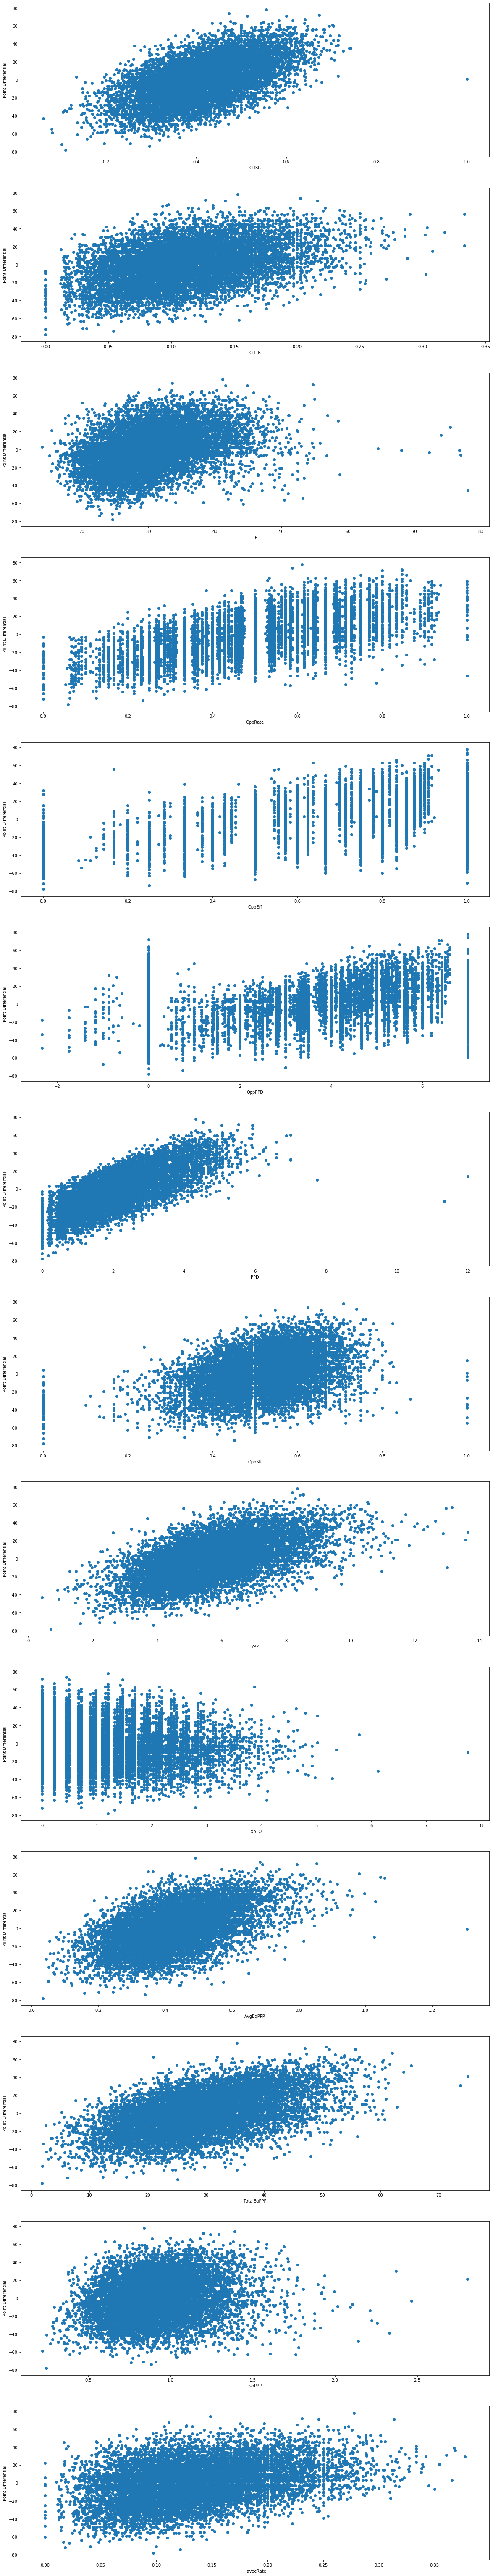

In [240]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

for i in range(len(inputs)):
    inpt = inputs[i]
    axes[i].scatter(stored_game_boxes[inpt], stored_game_boxes.PtsDiff);
    axes[i].set_xlabel(inpt)
    axes[i].set_ylabel("Point Differential");

In [241]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,1.659480,-0.22,0.122680,4.387538,0.04152,0.006633,5.269858,1.039716,1.081095,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-1.659480,0.22,-0.122680,-4.387538,-0.04152,-0.006633,4.230142,-1.039716,1.081095,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,-0.684527,0.22,0.017305,2.138834,-0.42232,0.042920,4.708140,-0.083720,0.087052,0.181656
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0.684527,-0.22,-0.017305,-2.138834,0.42232,-0.042920,4.791860,0.083720,0.087052,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,-0.172264,0.00,0.087917,-6.578618,0.26167,0.059391,4.320653,-0.858694,0.892868,0.499553


In [293]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3.2)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.2)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [294]:
# outliers

In [295]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,1.659480,-0.22,0.122680,4.387538,0.041520,0.006633,5.269858,1.039716,1.081095,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,-0.684527,0.22,0.017305,2.138834,-0.422320,0.042920,4.708140,-0.083720,0.087052,0.181656
1,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,0.172264,0.00,-0.087917,6.578618,-0.261670,-0.059391,5.179347,0.858694,0.892868,0.499553
1,Rice,2012,322430242,24.0,-25.0,0.638687,0.423077,0.089744,5.141026,0.647310,...,-3.901832,0.00,-0.172590,-9.625505,-0.177623,-0.013919,4.315756,-0.868489,0.903053,1.135348
0,UMass,2012,322430041,0.0,-37.0,0.000005,0.148936,0.042553,2.382979,1.437239,...,-3.231307,-0.22,-0.193136,-19.651101,0.428001,-0.134043,3.347098,-2.805804,2.917469,1.680314


In [296]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [297]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {model.score(train_data["5FRDiff"][:,np.newaxis], train_data.PtsDiff)}\n')
# print(f'Linear Regression Model:\nPtsDiff = {model.intercept_:.5f}')
# for i in range(len(inputDiffs)):
#     inptDf = inputDiffs[i]
#     print(f"+ ({model.coef_[i]:.5f} * {inptDf})")
    
test.corr()

Linear Regression: y = 20.82958x + 0.01542
Mean Pred Score: 0.00018541698354456409
Pred Std Dev: 20.49325881539
MAPE: ???%
Mean Abs Error: 7.321172900332731
Mdn Abs Error: 5.67646596814453
R-squared: 0.8116349714660309



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.779920,0.564494,0.506924,0.802075,0.612433,0.600732,0.982888,0.543964,0.783598,-0.473683,0.713384,0.757866,0.210397,0.560395,0.902471,0.902471,0.902471
OffSRDiff,0.779920,1.000000,0.488970,0.317838,0.709460,0.419509,0.446980,0.777186,0.759893,0.736149,-0.328213,0.638116,0.766194,-0.066843,0.572485,0.860180,0.860180,0.860180
OffERDiff,0.564494,0.488970,1.000000,0.171154,0.494769,0.298746,0.326984,0.554673,0.372462,0.798465,-0.200512,0.755835,0.610106,0.559043,0.206748,0.548339,0.548339,0.548339
FPDiff,0.506924,0.317838,0.171154,1.000000,0.621454,0.124409,0.119409,0.486828,0.079226,0.261687,-0.298014,0.240705,0.256149,-0.000358,0.299684,0.633351,0.633351,0.633351
OppRateDiff,0.802075,0.709460,0.494769,0.621454,1.000000,0.236098,0.228222,0.805330,0.310395,0.678393,-0.338471,0.584402,0.742477,0.109023,0.528821,0.915027,0.915027,0.915027
OppEffDiff,0.612433,0.419509,0.298746,0.124409,0.236098,1.000000,0.752660,0.606568,0.519810,0.442897,-0.306107,0.400644,0.376015,0.137906,0.334214,0.462730,0.462730,0.462730
OppPPDDiff,0.600732,0.446980,0.326984,0.119409,0.228222,0.752660,1.000000,0.602458,0.551205,0.479551,-0.326929,0.450878,0.391731,0.176036,0.362648,0.519978,0.519978,0.519978
PPDDiff,0.982888,0.777186,0.554673,0.486828,0.805330,0.606568,0.602458,1.000000,0.537925,0.772302,-0.466186,0.701745,0.738466,0.199973,0.566753,0.899205,0.899205,0.899205
OppSRDiff,0.543964,0.759893,0.372462,0.079226,0.310395,0.519810,0.551205,0.537925,1.000000,0.559028,-0.275421,0.486358,0.479145,-0.037071,0.408055,0.587409,0.587409,0.587409
YPPDiff,0.783598,0.736149,0.798465,0.261687,0.678393,0.442897,0.479551,0.772302,0.559028,1.000000,-0.335566,0.900974,0.790774,0.496746,0.463902,0.772368,0.772368,0.772368


In [247]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [248]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by 0.0 (exact value: 0.45231853212123857)
Z score: 0.04023698742962434
Win Prob for Virginia Tech: 51.60%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,-0.052381,0.118588,0.994779,-0.66,0.103211,2.077885,0.124959,-0.040309,4.740123,-0.019753
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,0.052381,-0.118588,-0.994779,0.66,-0.103211,-2.077885,-0.124959,0.040309,4.759877,0.019753


In [249]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -18.0 (exact value: -17.819564295416114)
Z score: -0.8836867925057504
Win Prob for Georgia Tech: 18.84%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,1.361111,0.07619,-0.330005,-0.66,-0.014422,-0.482035,-0.121075,0.018689,4.319167,-0.861667
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-1.361111,-0.07619,0.330005,0.66,0.014422,0.482035,0.121075,-0.018689,5.180833,0.861667


In [250]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by 3.0 (exact value: 3.075233956150592)
Z score: 0.17286557069569894
Win Prob for Georgia Tech: 56.86%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,0.054545,-0.01919,-1.322588,0.0,-0.06305,6.586287,-0.300725,0.012719,4.67686,-0.146281
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,-0.054545,0.01919,1.322588,0.0,0.06305,-6.586287,0.300725,-0.012719,4.82314,0.146281


In [251]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by -0.0 (exact value: -0.004015305074664813)
Z score: 0.017162316485531074
Win Prob for Mississippi State: 50.68%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,0.068182,-0.059649,0.080622,0.22,0.020976,6.298842,0.092249,0.000243,4.75113,0.00226
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,-0.068182,0.059649,-0.080622,-0.22,-0.020976,-6.298842,-0.092249,-0.000243,4.74887,-0.00226


In [252]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -3.0 (exact value: -2.637711535022091)
Z score: -0.11601140178653009
Win Prob for Texas A&M: 45.38%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.340557,0.014666,0.876496,0.0,-0.103285,-15.374294,-0.349878,0.001282,4.814654,0.129307
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.340557,-0.014666,-0.876496,0.0,0.103285,15.374294,0.349878,-0.001282,4.685346,-0.129307


In [253]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.946313,13,12.0,1.0
2,Clemson,0.944928,13,12.0,1.0
3,Alabama,0.919122,12,11.0,1.0
4,LSU,0.904878,13,12.0,1.0
5,Utah,0.871067,13,11.0,2.0
6,Wisconsin,0.865764,13,11.0,2.0
7,Oregon,0.840646,13,11.0,2.0
8,Georgia,0.829567,13,11.0,2.0
9,Oklahoma,0.826625,13,11.0,2.0
10,Notre Dame,0.811853,12,10.0,2.0


In [254]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.739488,1.260512
21,Clemson,10.831384,2.168616
53,LSU,10.304892,2.695108
128,Wisconsin,9.497965,3.502035
115,Utah,9.418866,3.581134
2,Alabama,9.395546,2.604454
78,Oklahoma,9.210537,3.789463
82,Oregon,8.986458,4.013542
34,Georgia,8.960989,4.039011
75,Notre Dame,8.807958,3.192042


In [255]:
# Matchup Predictor?

def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'].median()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'].median()
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.10333107833481692, -25.316997257906454]

In [256]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5] # Sugar Bowl
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Georgia,Baylor,7.5,4.424499,0.595258,False,Georgia,Baylor
0,LSU,Oklahoma,11.0,1.437577,0.535879,False,LSU,Oklahoma
0,Florida,Virginia,14.0,0.853974,0.524140,False,Florida,Virginia
0,Clemson,Ohio State,2.5,-0.137334,0.504157,False,Ohio State,Ohio State
0,Penn State,Memphis,7.0,-1.044936,0.485852,False,Memphis,Memphis
0,Wisconsin,Oregon,2.5,-1.276745,0.481179,False,Oregon,Oregon


In [257]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by -1.0 (exact value: -1.20283768501041)
Z score: -0.04345653244185331
Win Prob for Virginia: 48.27%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-1.0,0.073684,-2.332187,0.66,-0.135068,2.373916,-0.403644,-0.089435,4.780045,0.06009
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,1.0,-0.073684,2.332187,-0.66,0.135068,-2.373916,0.403644,0.089435,4.719955,-0.06009


In [258]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.560656838953875)
Z score: 0.5513684469220828
Win Prob for North Carolina: 70.93%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,1.230769,-0.123887,-0.349659,0.0,-0.01403,15.633715,-0.235394,0.079888,5.003686,0.507371
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,-1.230769,0.123887,0.349659,0.0,0.01403,-15.633715,0.235394,-0.079888,4.496314,-0.507371


In [259]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 17.0 (exact value: 17.360286275161947)
Z score: 0.895193951395719
Win Prob for Pittsburgh: 81.47%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.659341,0.20743,1.49512,0.0,0.130501,14.249196,-0.248736,0.038746,5.16769,0.835379
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.659341,-0.20743,-1.49512,0.0,-0.130501,-14.249196,0.248736,-0.038746,4.33231,-0.835379


In [260]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -10.0 (exact value: -10.049660392341012)
Z score: -0.4907990396878152
Win Prob for Auburn: 31.18%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.538462,0.114729,1.117419,0.44,0.063274,9.532495,-0.083465,-0.033763,4.993427,0.486853
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.538462,-0.114729,-1.117419,-0.44,-0.063274,-9.532495,0.083465,0.033763,4.506573,-0.486853


In [261]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 38.0 (exact value: 37.55482724550585)
Z score: 1.9163375742773376
Win Prob for Georgia: 97.23%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,3.276786,-0.047059,4.45067,0.0,0.330151,25.998278,0.455922,0.020115,5.654773,1.809547
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,-3.276786,0.047059,-4.45067,0.0,-0.330151,-25.998278,-0.455922,-0.020115,3.845227,-1.809547


In [262]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 24.0 (exact value: 24.2577264754734)
Z score: 1.2439652894072417
Win Prob for Clemson: 89.32%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 9.0 (exact value: 8.559973219066704)
Z score: 0.45020322000003177
Win Prob for Georgia Tech: 67.37%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -10.0 (exact value: -10.151792526400854)
Z score: -0.49596338472242885
Win Prob for The Citadel: 31.00%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 17.0 (exact value: 17.025055623596312)
Z score: 0.8782429029641949
Win Prob for Temple: 81.01%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.560656838953875)
Z score: 0.551368446922

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5804,401111653,2019,Georgia Tech,Clemson,-38.0,10.675617
5900,401112441,2019,Georgia Tech,South Florida,4.0,67.371804
5967,401112452,2019,Georgia Tech,The Citadel,-3.0,69.003988
6107,401112469,2019,Georgia Tech,Temple,-22.0,18.990596
6164,401112475,2019,Georgia Tech,North Carolina,-16.0,29.069056
6198,401112480,2019,Georgia Tech,Duke,-18.0,27.669797
6251,401112488,2019,Georgia Tech,Miami,7.0,18.843266
6384,401112498,2019,Georgia Tech,Pittsburgh,-10.0,18.534171
6418,401112504,2019,Georgia Tech,Virginia,-5.0,18.434677
6475,401112511,2019,Georgia Tech,Virginia Tech,-45.0,0.070793


In [263]:
retrieve_win_probs("Ohio State", 2019)

Game: Florida Atlantic @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 24.0
Proj MOV: Ohio State by 24.0 (exact value: 24.00848176816842)
Z score: 1.2313621485992758
Win Prob for Ohio State: 89.09%
---
Game: Cincinnati @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 42.0
Proj MOV: Ohio State by 40.0 (exact value: 40.07674055804514)
Z score: 2.04385895247264
Win Prob for Ohio State: 97.95%
---
Game: Ohio State @ Indiana
Actual Winner: Ohio State
MOV: Ohio State by 41.0
Proj MOV: Ohio State by 36.0 (exact value: 36.43515562531481)
Z score: 1.8597210096147079
Win Prob for Ohio State: 96.85%
---
Game: Miami (OH) @ Ohio State
Actual Winner: Ohio State
MOV: Ohio State by 71.0
Proj MOV: Ohio State by 66.0 (exact value: 66.13409139921264)
Z score: 3.3614574896080973
Win Prob for Ohio State: 99.96%
---
Game: Ohio State @ Nebraska
Actual Winner: Ohio State
MOV: Ohio State by 41.0
Proj MOV: Ohio State by 39.0 (exact value: 39.44084088752909)
Z score: 2.011704475958737
Win Prob

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5821,401112251,2019,Ohio State,Florida Atlantic,24.0,89.090628
5887,401112252,2019,Ohio State,Cincinnati,42.0,97.951626
5965,401112159,2019,Ohio State,Indiana,41.0,96.853750
6043,401112253,2019,Ohio State,Miami (OH),71.0,99.961234
6125,401112241,2019,Ohio State,Nebraska,41.0,97.787445
6173,401112216,2019,Ohio State,Michigan State,24.0,85.417161
6241,401112248,2019,Ohio State,Northwestern,49.0,97.883143
6307,401112254,2019,Ohio State,Wisconsin,31.0,87.694339
6413,401112209,2019,Ohio State,Maryland,59.0,99.029794
6481,401112255,2019,Ohio State,Rutgers,35.0,95.789322


In [264]:
retrieve_win_probs("Georgia Tech", 2018)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 52.0 (exact value: 51.5257038706355)
Z score: 2.622779557423542
Win Prob for Georgia Tech: 99.56%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 9.0 (exact value: 8.995639917067127)
Z score: 0.4722328502361603
Win Prob for South Florida: 68.16%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 5.0 (exact value: 4.51919408056271)
Z score: 0.24587989050143766
Win Prob for Pittsburgh: 59.71%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 27.0 (exact value: 27.21440233581287)
Z score: 1.3934705791856732
Win Prob for Clemson: 91.83%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 36.0 (exact value: 36.0286026072024)
Z score: 1.

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
4986,401013090,2018,Georgia Tech,Alcorn State,41.0,99.563922
5048,401013100,2018,Georgia Tech,South Florida,-11.0,31.838030
5135,401013112,2018,Georgia Tech,Pittsburgh,-5.0,40.288761
5206,401013120,2018,Georgia Tech,Clemson,-28.0,8.173877
5249,401013134,2018,Georgia Tech,Bowling Green,46.0,96.705443
5304,401013138,2018,Georgia Tech,Louisville,35.0,96.980549
5373,401013145,2018,Georgia Tech,Duke,-14.0,17.309887
5473,401013153,2018,Georgia Tech,Virginia Tech,21.0,81.277317
5545,401013165,2018,Georgia Tech,North Carolina,10.0,84.417637
5636,401013172,2018,Georgia Tech,Miami,6.0,59.147869


In [265]:
retrieve_win_probs("Clemson", 2019)

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 24.0 (exact value: 24.2577264754734)
Z score: 1.2439652894072417
Win Prob for Clemson: 89.32%
---
Game: Texas A&M @ Clemson
Actual Winner: Clemson
MOV: Clemson by 14.0
Proj MOV: Clemson by 11.0 (exact value: 10.931244955231506)
Z score: 0.5701073572151336
Win Prob for Clemson: 71.57%
---
Game: Clemson @ Syracuse
Actual Winner: Clemson
MOV: Clemson by 35.0
Proj MOV: Clemson by 28.0 (exact value: 28.136276988270616)
Z score: 1.4400854749555672
Win Prob for Clemson: 92.51%
---
Game: Charlotte @ Clemson
Actual Winner: Clemson
MOV: Clemson by 42.0
Proj MOV: Clemson by 52.0 (exact value: 51.54368635423677)
Z score: 2.6236888476361777
Win Prob for Clemson: 99.57%
---
Game: Clemson @ North Carolina
Actual Winner: Clemson
MOV: Clemson by 1.0
Proj MOV: Clemson by 3.0 (exact value: 2.6558146892495316)
Z score: 0.15165749717035118
Win Prob for Clemson: 56.03%
---
Game: Florida State @ Clemson
Actual Winne

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
5804,401111653,2019,Clemson,Georgia Tech,38.0,89.324383
5905,401110784,2019,Clemson,Texas A&M,14.0,71.569756
6008,401112449,2019,Clemson,Syracuse,35.0,92.507839
6067,401112456,2019,Clemson,Charlotte,42.0,99.565084
6103,401112467,2019,Clemson,North Carolina,1.0,56.027146
6204,401112479,2019,Clemson,Florida State,31.0,91.569219
6250,401112485,2019,Clemson,Louisville,35.0,95.070888
6344,401112490,2019,Clemson,Boston College,52.0,96.124185
6381,401112496,2019,Clemson,Wofford,45.0,99.111822
6445,401112503,2019,Clemson,NC State,45.0,96.573157


In [266]:
retrieve_win_probs("Georgia Tech", 2016)

Game: Georgia Tech @ Boston College
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by -6.0 (exact value: -6.37262654232836)
Z score: -0.30486861063898285
Win Prob for Georgia Tech: 38.02%
---
Game: Mercer @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 25.0
Proj MOV: Georgia Tech by 29.0 (exact value: 28.84237196899836)
Z score: 1.4757894004757213
Win Prob for Georgia Tech: 93.00%
---
Game: Vanderbilt @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 31.0
Proj MOV: Georgia Tech by 30.0 (exact value: 29.832861737676474)
Z score: 1.5258738422216591
Win Prob for Georgia Tech: 93.65%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 19.0
Proj MOV: Clemson by 23.0 (exact value: 23.315516110768968)
Z score: 1.1963221116423295
Win Prob for Clemson: 88.42%
---
Game: Miami @ Georgia Tech
Actual Winner: Miami
MOV: Miami by 14.0
Proj MOV: Miami by 4.0 (exact value: 4.262228095790185)
Z score: 0.23288632075240015
Win 

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
3312,400869424,2016,Georgia Tech,Boston College,3.0,38.023311
3393,400869433,2016,Georgia Tech,Mercer,25.0,92.999978
3462,400869001,2016,Georgia Tech,Vanderbilt,31.0,93.647936
3513,400869446,2016,Georgia Tech,Clemson,-19.0,11.578544
3576,400869721,2016,Georgia Tech,Miami,-14.0,40.792484
3650,400869458,2016,Georgia Tech,Pittsburgh,-3.0,42.615008
3702,400869464,2016,Georgia Tech,Georgia Southern,11.0,78.923116
3807,400869474,2016,Georgia Tech,Duke,3.0,32.100386
3874,400869480,2016,Georgia Tech,North Carolina,-28.0,24.283252
3946,400869486,2016,Georgia Tech,Virginia Tech,10.0,38.655220


In [267]:
retrieve_win_probs("Alabama", 2012)

Game: Michigan @ Alabama
Actual Winner: Alabama
MOV: Alabama by 27.0
Proj MOV: Alabama by 39.0 (exact value: 38.89318560126016)
Z score: 1.984012105830979
Win Prob for Alabama: 97.64%
---
Game: Western Kentucky @ Alabama
Actual Winner: Alabama
MOV: Alabama by 35.0
Proj MOV: Alabama by 31.0 (exact value: 30.882713586248144)
Z score: 1.5789599471107856
Win Prob for Alabama: 94.28%
---
Game: Alabama @ Arkansas
Actual Winner: Alabama
MOV: Alabama by 52.0
Proj MOV: Alabama by 33.0 (exact value: 33.382908290879186)
Z score: 1.705383116735963
Win Prob for Alabama: 95.59%
---
Game: Florida Atlantic @ Alabama
Actual Winner: Alabama
MOV: Alabama by 33.0
Proj MOV: Alabama by 50.0 (exact value: 50.15766846974846)
Z score: 2.5536043962973958
Win Prob for Alabama: 99.47%
---
Game: Ole Miss @ Alabama
Actual Winner: Alabama
MOV: Alabama by 19.0
Proj MOV: Alabama by 19.0 (exact value: 19.167265358680464)
Z score: 0.9865644445663783
Win Prob for Alabama: 83.81%
---
Game: Alabama @ Missouri
Actual Winner

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
67,322450333,2012,Alabama,Michigan,27.0,97.637275
100,322520333,2012,Alabama,Western Kentucky,35.0,94.282738
167,322590008,2012,Alabama,Arkansas,52.0,95.593850
246,322660333,2012,Alabama,Florida Atlantic,33.0,99.466928
326,322730333,2012,Alabama,Ole Miss,19.0,83.807190
414,322870142,2012,Alabama,Missouri,32.0,89.305462
478,322942633,2012,Alabama,Tennessee,31.0,83.666677
551,323010333,2012,Alabama,Mississippi State,31.0,89.850245
606,323080099,2012,Alabama,LSU,4.0,60.446704
638,323150333,2012,Alabama,Texas A&M,-5.0,50.574865


In [268]:
predict_matchup("Georgia Tech","Georgia", 2015)
# calculate_box_score(400547779, 2014)

[0.3565998306889242, -7.612480957825417]

In [269]:
retrieve_win_probs("Georgia Tech", 2015)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 63.0
Proj MOV: Georgia Tech by 51.0 (exact value: 51.18340663107933)
Z score: 2.6054711846402205
Win Prob for Georgia Tech: 99.54%
---
Game: Tulane @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 55.0
Proj MOV: Georgia Tech by 46.0 (exact value: 46.245090145090956)
Z score: 2.3557635832224144
Win Prob for Georgia Tech: 99.08%
---
Game: Georgia Tech @ Notre Dame
Actual Winner: Notre Dame
MOV: Notre Dame by 8.0
Proj MOV: Notre Dame by 11.0 (exact value: 11.079389408657626)
Z score: 0.5775983303500773
Win Prob for Notre Dame: 71.82%
---
Game: Georgia Tech @ Duke
Actual Winner: Duke
MOV: Duke by 14.0
Proj MOV: Duke by 15.0 (exact value: 14.581434115263074)
Z score: 0.7546803756636126
Win Prob for Duke: 77.48%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 7.0
Proj MOV: North Carolina by 8.0 (exact value: 7.6618560338233825)
Z score: 0.404789628393

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
2460,400756895,2015,Georgia Tech,Alcorn State,63.0,99.541260
2567,400756910,2015,Georgia Tech,Tulane,55.0,99.075766
2641,400756922,2015,Georgia Tech,Notre Dame,-8.0,28.176767
2688,400756933,2015,Georgia Tech,Duke,-14.0,22.522039
2775,400756942,2015,Georgia Tech,North Carolina,-7.0,34.281608
2827,400756948,2015,Georgia Tech,Clemson,-19.0,12.835990
2882,400756955,2015,Georgia Tech,Pittsburgh,-3.0,25.043191
2965,400756962,2015,Georgia Tech,Florida State,6.0,22.026734
2997,400756972,2015,Georgia Tech,Virginia,-6.0,23.007887
3090,400756979,2015,Georgia Tech,Virginia Tech,-2.0,27.757635


In [270]:
predict_matchup("Georgia Tech","Florida State",2015)

[0.22713276861429216, -15.142550302386303]

In [271]:
predict_matchup("Army","Navy", 2019)

[0.39381639392756634, -5.670905047183334]

In [272]:
retrieve_win_probs("Georgia Tech", 2015)

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 63.0
Proj MOV: Georgia Tech by 51.0 (exact value: 51.18340663107933)
Z score: 2.6054711846402205
Win Prob for Georgia Tech: 99.54%
---
Game: Tulane @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 55.0
Proj MOV: Georgia Tech by 46.0 (exact value: 46.245090145090956)
Z score: 2.3557635832224144
Win Prob for Georgia Tech: 99.08%
---
Game: Georgia Tech @ Notre Dame
Actual Winner: Notre Dame
MOV: Notre Dame by 8.0
Proj MOV: Notre Dame by 11.0 (exact value: 11.079389408657626)
Z score: 0.5775983303500773
Win Prob for Notre Dame: 71.82%
---
Game: Georgia Tech @ Duke
Actual Winner: Duke
MOV: Duke by 14.0
Proj MOV: Duke by 15.0 (exact value: 14.581434115263074)
Z score: 0.7546803756636126
Win Prob for Duke: 77.48%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 7.0
Proj MOV: North Carolina by 8.0 (exact value: 7.6618560338233825)
Z score: 0.404789628393

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
2460,400756895,2015,Georgia Tech,Alcorn State,63.0,99.541260
2567,400756910,2015,Georgia Tech,Tulane,55.0,99.075766
2641,400756922,2015,Georgia Tech,Notre Dame,-8.0,28.176767
2688,400756933,2015,Georgia Tech,Duke,-14.0,22.522039
2775,400756942,2015,Georgia Tech,North Carolina,-7.0,34.281608
2827,400756948,2015,Georgia Tech,Clemson,-19.0,12.835990
2882,400756955,2015,Georgia Tech,Pittsburgh,-3.0,25.043191
2965,400756962,2015,Georgia Tech,Florida State,6.0,22.026734
2997,400756972,2015,Georgia Tech,Virginia,-6.0,23.007887
3090,400756979,2015,Georgia Tech,Virginia Tech,-2.0,27.757635


In [273]:
retrieve_win_probs("Georgia Tech", 2013)

Game: Elon @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 70.0
Proj MOV: Georgia Tech by 34.0 (exact value: 34.1443218983527)
Z score: 1.7438842468576459
Win Prob for Georgia Tech: 95.94%
---
Game: Georgia Tech @ Duke
Actual Winner: Georgia Tech
MOV: Georgia Tech by 24.0
Proj MOV: Georgia Tech by 23.0 (exact value: 22.939262800359376)
Z score: 1.17729673894002
Win Prob for Georgia Tech: 88.05%
---
Game: North Carolina @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 8.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.7635716159997176)
Z score: -0.021244898823775227
Win Prob for Georgia Tech: 49.15%
---
Game: Virginia Tech @ Georgia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 7.0
Proj MOV: Virginia Tech by 6.0 (exact value: 5.697771392884118)
Z score: 0.3054750409095268
Win Prob for Virginia Tech: 62.00%
---
Game: Georgia Tech @ Miami
Actual Winner: Miami
MOV: Miami by 15.0
Proj MOV: Miami by 12.0 (exact value: 11.579672521278876)
Z score: 0.6

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
831,332430059,2013,Georgia Tech,Elon,70.0,95.941036
982,332570150,2013,Georgia Tech,Duke,24.0,88.046146
1025,332640059,2013,Georgia Tech,North Carolina,8.0,49.152515
1077,332690059,2013,Georgia Tech,Virginia Tech,-7.0,38.000219
1156,332782390,2013,Georgia Tech,Miami,-15.0,27.328917
1220,332850252,2013,Georgia Tech,BYU,-18.0,31.454761
1246,332920059,2013,Georgia Tech,Syracuse,56.0,98.432373
1294,332990258,2013,Georgia Tech,Virginia,10.0,56.160418
1378,333060059,2013,Georgia Tech,Pittsburgh,11.0,73.369524
1445,333180228,2013,Georgia Tech,Clemson,-24.0,5.826616


In [274]:
predict_matchup("Georgia Tech","Syracuse",2013)

[0.5233534256451845, 0.8149156410868911]

In [275]:
generate_win_prob(401013177,2018)

Game: Virginia @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by -4.0 (exact value: -4.109447582092834)
Z score: -0.19043022028001616
Win Prob for Georgia Tech: 42.45%
---


0.4244860092849033

In [276]:
predict_matchup("Georgia Tech","Georgia",2016)

[0.4099384182704364, -4.8465765653314445]

In [277]:
predict_matchup("Georgia Tech","Georgia",2015)

[0.3565998306889242, -7.612480957825417]